In [11]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch import optim

from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch, onehot_batch_decode, get_mia
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR
from src.data_processing import compute_frequency, batch_compute_frequency
from src.models import Net, ConvBlock, LinearBlock
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

In [12]:
if torch.cuda.is_available():    
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name())
    device = "cuda:0"
else:
    print('No GPU available, using the CPU instead.')
    device='cpu'

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070 Laptop GPU


In [13]:
from src.partition_tools import pipeline_stratified_kfold
# Load data
cedar = pd.read_csv('../data/cedar_neoepitope_220701_scored.csv')
dataset_5fold = pd.read_csv('../data/cedar_neoepitopes_partition_5fold.csv')
dataset_10fold = pipeline_stratified_kfold('../out/cedar_peps_hobohm_0.925.pep', cedar, k=10, shuffle=True)
ics_kl = pkl_load('../output/ics_kl.pkl')
ics_shannon = pkl_load('../output/ics_shannon.pkl')

# NN exploration

In [4]:
# cedar = new_dataset.copy()
# mixed = mixed_subsampled_hp[['Peptide', 'HLA', 'total_count', 'percentage_pos', 'agg_label', 'len', 'trueHLA_EL_rank', 'core', 'icore']].copy()
cedar = pd.read_csv('../data/cedar_neoepitopes_partition_5fold.csv')


## train loops

In [99]:
from src.train_eval import train_loop, nested_kcv_train
from src.models import *
from src.data_processing import get_tensor_dataset
from torch.utils.data import DataLoader
from src.metrics import get_metrics
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Set up hyperparams
n_epochs = 300
lr = 5e-3
batch_size = 128
# init objects
model = Net(n_filters=16, n_hidden=32, act_cnn=nn.SELU(), act_lin=nn.SELU())
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
ics_dict = ics_shannon
# nested_kcv_train(dataset_5fold, ics_shannon, model, criterion, optimizer, device, batch_size,
#                  n_epochs, early_stopping=False, patience=20, delta=1e-6, filename='model')

test = dataset_5fold.query('fold==0')
valid = dataset_5fold.query('fold==1')
train = dataset_5fold.query('fold != 0 and fold !=1')
    
test_dataset = get_tensor_dataset(test, ics_dict, device)

x_test, y_test = test_dataset.tensors[0], test_dataset.tensors[1]

train_loader = DataLoader(get_tensor_dataset(train, ics_dict, device), batch_size=batch_size)
valid_loader = DataLoader(get_tensor_dataset(valid, ics_dict, device), batch_size=batch_size)

model, result_metrics = train_loop(model, criterion, optimizer, train_loader, valid_loader, 
                                   device, n_epochs, early_stopping=False, patience=20, delta=1e-6, filename='xd')

  1%|▌                                                                                       | 2/300 [00:00<00:36,  8.26it/s]

Train Epoch: 0	Train Loss: 0.68768	Eval Loss:0.72073
	Train AUC, Accuracy:	(0.5619370753105685, 0.6122942884801549)
	Eval AUC, Accuracy:	(0.6307249974668152, 0.8033946251768034)


 11%|█████████▌                                                                             | 33/300 [00:02<00:16, 16.20it/s]

Train Epoch: 29	Train Loss: 0.02507	Eval Loss:1.39338
	Train AUC, Accuracy:	(0.9984056866913238, 0.9941916747337851)
	Eval AUC, Accuracy:	(0.6507118249062722, 0.7538896746817539)


 21%|██████████████████▎                                                                    | 63/300 [00:04<00:15, 15.65it/s]

Train Epoch: 59	Train Loss: 0.00871	Eval Loss:1.44138
	Train AUC, Accuracy:	(0.9999708170010936, 0.9980638915779284)
	Eval AUC, Accuracy:	(0.6416176917620833, 0.7553041018387553)


 31%|██████████████████████████▉                                                            | 93/300 [00:06<00:13, 15.80it/s]

Train Epoch: 89	Train Loss: 0.00973	Eval Loss:1.56634
	Train AUC, Accuracy:	(0.9996820589066513, 0.9975798644724104)
	Eval AUC, Accuracy:	(0.6374506028979632, 0.7637906647807637)


 41%|███████████████████████████████████▎                                                  | 123/300 [00:07<00:11, 15.99it/s]

Train Epoch: 119	Train Loss: 0.00904	Eval Loss:1.59537
	Train AUC, Accuracy:	(0.9998955555828613, 0.9975798644724104)
	Eval AUC, Accuracy:	(0.6318142668963421, 0.7227722772277227)


 51%|███████████████████████████████████████████▊                                          | 153/300 [00:09<00:09, 15.63it/s]

Train Epoch: 149	Train Loss: 0.00493	Eval Loss:1.67231
	Train AUC, Accuracy:	(0.9999877124215131, 0.9985479186834463)
	Eval AUC, Accuracy:	(0.6241260512716588, 0.7623762376237624)


 61%|████████████████████████████████████████████████████▍                                 | 183/300 [00:11<00:07, 16.12it/s]

Train Epoch: 179	Train Loss: 0.00534	Eval Loss:1.74294
	Train AUC, Accuracy:	(0.9999831045795805, 0.9985479186834463)
	Eval AUC, Accuracy:	(0.6227581315229507, 0.7581329561527581)


 71%|█████████████████████████████████████████████████████████████                         | 213/300 [00:13<00:05, 16.55it/s]

Train Epoch: 209	Train Loss: 0.00559	Eval Loss:1.72294
	Train AUC, Accuracy:	(0.9999831045795804, 0.9980638915779284)
	Eval AUC, Accuracy:	(0.6214535413922384, 0.7567185289957568)


 81%|█████████████████████████████████████████████████████████████████████▋                | 243/300 [00:15<00:03, 16.39it/s]

Train Epoch: 239	Train Loss: 0.00375	Eval Loss:1.82711
	Train AUC, Accuracy:	(0.9999984640526891, 0.9980638915779284)
	Eval AUC, Accuracy:	(0.618793697436417, 0.7595473833097596)


 91%|██████████████████████████████████████████████████████████████████████████████▎       | 273/300 [00:17<00:01, 16.21it/s]

Train Epoch: 269	Train Loss: 0.00412	Eval Loss:1.86630
	Train AUC, Accuracy:	(0.9999907843161348, 0.9980638915779284)
	Eval AUC, Accuracy:	(0.6249493363056033, 0.7722772277227723)


100%|██████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:18<00:00, 15.84it/s]

Train Epoch: 299	Train Loss: 0.00500	Eval Loss:1.87792
	Train AUC, Accuracy:	(0.9999846405268914, 0.9980638915779284)
	Eval AUC, Accuracy:	(0.6196043165467625, 0.7765205091937766)


In [100]:
y_test_pred = model(x_test)
test_metrics = get_metrics(y_test, y_test_pred)

Text(0.5, 1.0, 'AUC on evaluation set')

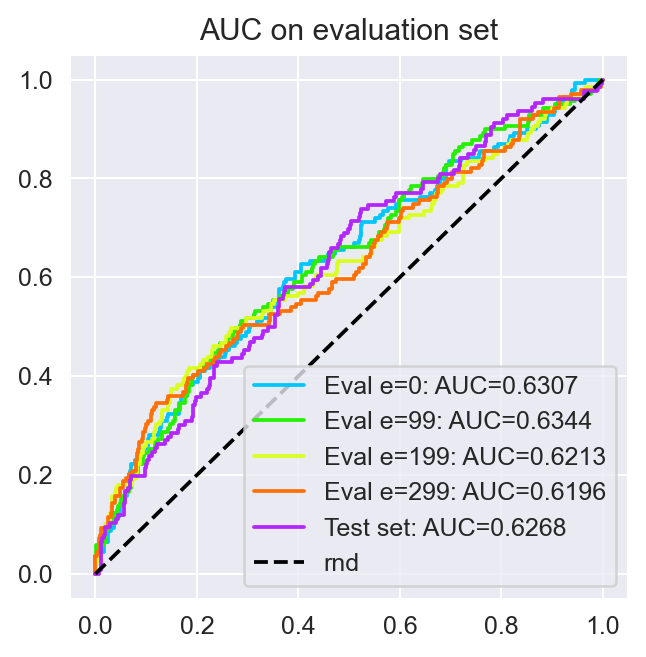

In [112]:
sns.set_palette('gist_ncar', n_colors=5)
f,a = plt.subplots(1,1, figsize=(4,4))
for epoch in [1, 100, 200, 300] :
    fpr=result_metrics['eval']['roc_curve'][epoch-1][0]
    tpr=result_metrics['eval']['roc_curve'][epoch-1][1]
    auc = result_metrics['eval']['auc'][epoch-1]
    sns.lineplot(fpr,tpr, label=f'Eval e={epoch-1}: AUC={auc.round(4)}', ax=a, estimator=None)
    
sns.lineplot(test_metrics['roc_curve'][0],test_metrics['roc_curve'][1], label=f'Test set: AUC={test_metrics["auc"].round(4)}', ax=a, estimator=None)
a.plot([0,1],[0,1],ls='--',c='k',label='rnd')
a.legend()
a.set_title('AUC on evaluation set')

Text(0.5, 0, 'epoch')

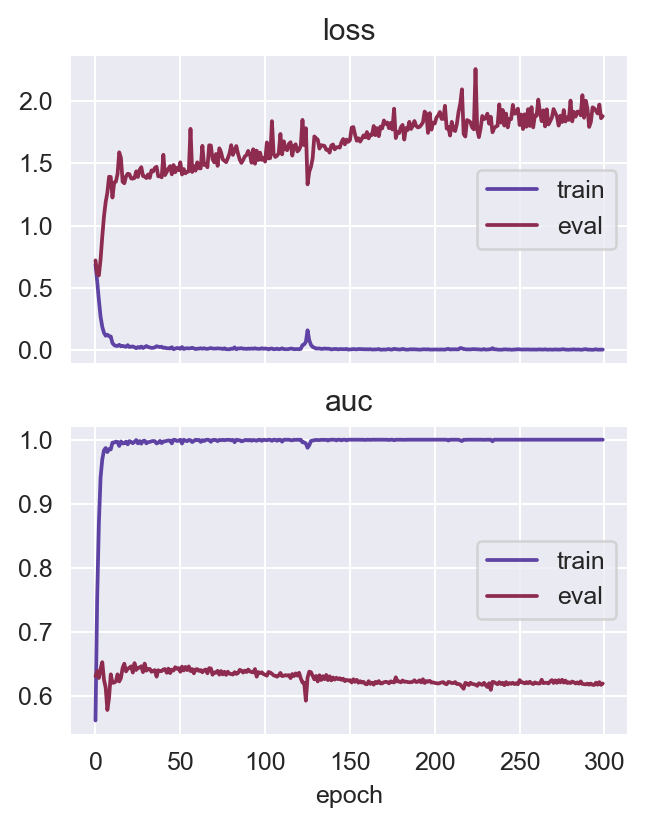

In [117]:
sns.set_palette('twilight', n_colors=2)

f,a = plt.subplots(2,1, figsize=(4,5), sharex=True)

sns.lineplot(x=range(n_epochs), y=result_metrics['train']['losses'], ax=a[0], label = 'train')
sns.lineplot(x=range(n_epochs), y=result_metrics['eval']['losses'], ax=a[0], label = 'eval')
a[0].legend(loc='best')
a[0].set_title('loss')
sns.lineplot(x=range(n_epochs), y=result_metrics['train']['auc'], ax=a[1], label = 'train')
sns.lineplot(x=range(n_epochs), y=result_metrics['eval']['auc'], ax=a[1], label = 'eval')

a[1].legend(loc='best')
a[1].set_title('auc')
a[1].set_xlabel('epoch')

## nested kcv 5fold ; shannon vs KL

In [1]:
import pandas as pd;
dataset_5fold = pd.read_csv('../data/cedar_neoepitopes_partition_5fold.csv')


In [8]:
dataset_5fold.groupby('HLA').count().sort_values('Peptide', ascending=False).head(20)

,Peptide,agg_label,trueHLA_EL_rank,fold,BA_rank,BA_score,PMIDs,core,icore,label,len,percentage_pos,pred_EL_rank,pred_EL_score,pred_HLA,responses,total_count
HLA,,,,,,,,,,,,,,,,,
HLA-A02:01,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294,1294
HLA-B07:02,325,325,325,325,325,325,325,325,325,325,325,325,325,325,325,325,325
HLA-A24:02,310,310,310,310,310,310,310,310,310,310,310,310,310,310,310,310,310
HLA-A11:01,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304
HLA-A03:01,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252,252
HLA-B15:01,153,153,153,153,153,153,153,153,153,153,153,153,153,153,153,153,153
HLA-B35:01,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141,141
HLA-A01:01,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58,58
HLA-B27:05,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53,53


In [6]:
dataset_5fold.groupby(['fold','len'])[['Peptide']].count()

Peptide
fold len         
0    8         35
     9        329
     10       195
     11       148
1    8         46
     9        322
     10       211
     11       127
     12         1
2    8         47
     9        325
     10       176
     11       138
     12         1
3    8         40
     9        332
     10       199
     11       117
4    8         31
     9        345
     10       185
     11       130

In [199]:
from src.train_eval import train_loop, nested_kcv_train
from src.models import *
from src.partition_tools import pipeline_stratified_kfold
import pandas as pd
from src.utils import pkl_load, pkl_dump
from torch import optim, nn

# Load data
cedar = pd.read_csv('../data/cedar_neoepitope_220701_scored.csv')
dataset_5fold = pd.read_csv('../data/cedar_neoepitopes_partition_5fold.csv')
dataset_10fold = pipeline_stratified_kfold('../out/cedar_peps_hobohm_0.925.pep', cedar, k=10, shuffle=True)
ics_kl = pkl_load('../output/ics_kl.pkl')
ics_shannon = pkl_load('../output/ics_shannon.pkl')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Set up hyperparams
n_epochs = 300
lr = 5e-4
batch_size = 128
# init objects
model = Net(n_filters=16, n_hidden=32, act_cnn=nn.SELU(), act_lin=nn.SELU())
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

models_fold_shannon, train_results_shannon, test_results_shannon = nested_kcv_train(dataset_5fold, ics_shannon, model, criterion, optimizer, device, batch_size,
                                                            n_epochs, early_stopping=True, patience=50, delta=1e-6, filename='model')


models_fold_kl, train_results_kl, test_results_kl = nested_kcv_train(dataset_5fold, ics_kl, model, criterion, optimizer, device, batch_size,
                                                            n_epochs, early_stopping=True, patience=50, delta=1e-6, filename='model')

Using cuda
folds: Outer:	0	Inner:	1


  1%|▌                                                                                       | 2/300 [00:00<00:33,  8.97it/s]

Train Epoch: 0	Train Loss: 0.71865	Eval Loss:0.78267
	Train AUC, Accuracy:	(0.533321608935527, 0.5827686350435625)
	Eval AUC, Accuracy:	(0.5533805350086128, 0.8033946251768034)


 10%|████████▉                                                                              | 31/300 [00:02<00:18, 14.45it/s]

Train Epoch: 29	Train Loss: 0.08775	Eval Loss:0.98788
	Train AUC, Accuracy:	(0.9998556209527788, 0.994675701839303)
	Eval AUC, Accuracy:	(0.6462534197993718, 0.6746817538896747)


 21%|██████████████████▎                                                                    | 63/300 [00:04<00:15, 15.66it/s]

Train Epoch: 59	Train Loss: 0.01649	Eval Loss:1.55739
	Train AUC, Accuracy:	(0.9999293464237002, 0.9966118102613747)
	Eval AUC, Accuracy:	(0.6378685783767353, 0.6704384724186704)


Early Stopping at epoch=63;current best valid loss:1.6914087653160095; previous avg losses: (1.19503618819373,), previous losses std: 0.32291923246925813
folds: Outer:	0	Inner:	2


  1%|▌                                                                                       | 2/300 [00:00<00:20, 14.45it/s]

Train Epoch: 0	Train Loss: 0.75413	Eval Loss:0.78694
	Train AUC, Accuracy:	(0.4648541065356453, 0.5158197507190796)
	Eval AUC, Accuracy:	(0.5321775714492964, 0.8195050946142649)


 11%|█████████▎                                                                             | 32/300 [00:02<00:17, 15.10it/s]

Train Epoch: 29	Train Loss: 0.07521	Eval Loss:1.34027
	Train AUC, Accuracy:	(0.9994888404168594, 0.9932885906040269)
	Eval AUC, Accuracy:	(0.5293776294791818, 0.6521106259097526)


Train Epoch: 59	Train Loss: 0.01712	Eval Loss:2.72881
	Train AUC, Accuracy:	(0.9998545839116928, 0.99712368168744)
	Eval AUC, Accuracy:	(0.5243145219788191, 0.6390101892285298)
Early Stopping at epoch=60;current best valid loss:2.737539792060852; previous avg losses: (1.5754634849879208,), previous losses std: 0.6075488213635061
folds: Outer:	0	Inner:	3


  1%|▌                                                                                       | 2/300 [00:00<00:21, 13.81it/s]

Train Epoch: 0	Train Loss: 0.77055	Eval Loss:0.83008
	Train AUC, Accuracy:	(0.5160987017370445, 0.5011990407673861)
	Eval AUC, Accuracy:	(0.5673832964972206, 0.5377906976744186)


 11%|█████████▎                                                                             | 32/300 [00:02<00:16, 15.91it/s]

Train Epoch: 29	Train Loss: 0.08907	Eval Loss:1.28521
	Train AUC, Accuracy:	(0.999308376628856, 0.9908872901678657)
	Eval AUC, Accuracy:	(0.5411693791440626, 0.6671511627906976)


Train Epoch: 59	Train Loss: 0.01673	Eval Loss:2.07274
	Train AUC, Accuracy:	(0.9999713707101269, 0.9980815347721822)
	Eval AUC, Accuracy:	(0.5332261737325028, 0.6729651162790697)
Early Stopping at epoch=59;current best valid loss:2.0727445602416994; previous avg losses: (1.398293846967269,), previous losses std: 0.42422984691938675
folds: Outer:	0	Inner:	4


  1%|█▏                                                                                      | 4/300 [00:00<00:19, 15.15it/s]

Train Epoch: 0	Train Loss: 0.79025	Eval Loss:0.80706
	Train AUC, Accuracy:	(0.48334022310890634, 0.5048030739673391)
	Eval AUC, Accuracy:	(0.5319656488549618, 0.7568740955137482)


 11%|█████████▎                                                                             | 32/300 [00:02<00:18, 14.65it/s]

Train Epoch: 29	Train Loss: 0.09697	Eval Loss:1.03798
	Train AUC, Accuracy:	(0.9982970272116178, 0.9913544668587896)
	Eval AUC, Accuracy:	(0.5973691384950927, 0.6642547033285094)


 21%|█████████████████▉                                                                     | 62/300 [00:04<00:15, 15.40it/s]

Train Epoch: 59	Train Loss: 0.02022	Eval Loss:1.54450
	Train AUC, Accuracy:	(0.9997438800819584, 0.9966378482228626)
	Eval AUC, Accuracy:	(0.5870910577971646, 0.6714905933429812)


Early Stopping at epoch=67;current best valid loss:1.8224939107894897; previous avg losses: (1.2872672587024923,), previous losses std: 0.2769927369765349
folds: Outer:	1	Inner:	0


  1%|▌                                                                                       | 2/300 [00:00<00:22, 13.38it/s]

Train Epoch: 0	Train Loss: 0.74471	Eval Loss:0.76247
	Train AUC, Accuracy:	(0.49774446137399697, 0.5590513068731849)
	Eval AUC, Accuracy:	(0.4917356500833265, 0.8217821782178217)


 11%|█████████▎                                                                             | 32/300 [00:02<00:19, 14.09it/s]

Train Epoch: 29	Train Loss: 0.08333	Eval Loss:1.19535
	Train AUC, Accuracy:	(0.9998080065861421, 0.9941916747337851)
	Eval AUC, Accuracy:	(0.5355571947654564, 0.652050919377652)


Train Epoch: 59	Train Loss: 0.01587	Eval Loss:1.86294
	Train AUC, Accuracy:	(0.9999416340021872, 0.9980638915779284)
	Eval AUC, Accuracy:	(0.5313157391470644, 0.6605374823196606)
Early Stopping at epoch=60;current best valid loss:1.8514668226242066; previous avg losses: (1.3187431036209574,), previous losses std: 0.3820327487026815
folds: Outer:	1	Inner:	2


  1%|▌                                                                                       | 2/300 [00:00<00:24, 12.29it/s]

Train Epoch: 0	Train Loss: 0.77080	Eval Loss:0.80023
	Train AUC, Accuracy:	(0.48219556417608367, 0.5095877277085331)
	Eval AUC, Accuracy:	(0.5157841288263455, 0.7816593886462883)


 11%|█████████▎                                                                             | 32/300 [00:02<00:18, 14.88it/s]

Train Epoch: 29	Train Loss: 0.08612	Eval Loss:1.27314
	Train AUC, Accuracy:	(0.999756041731923, 0.9918504314477469)
	Eval AUC, Accuracy:	(0.5260409110692007, 0.6477438136826783)


Early Stopping at epoch=58;current best valid loss:1.9936803102493286; previous avg losses: (1.3604630915486082,), previous losses std: 0.44605876396525507
folds: Outer:	1	Inner:	3


  1%|▌                                                                                       | 2/300 [00:00<00:21, 13.57it/s]

Train Epoch: 0	Train Loss: 0.82499	Eval Loss:0.84853
	Train AUC, Accuracy:	(0.5236593181909572, 0.47865707434052757)
	Eval AUC, Accuracy:	(0.48062420467483763, 0.2921511627906977)


 11%|█████████▎                                                                             | 32/300 [00:02<00:17, 15.01it/s]

Train Epoch: 29	Train Loss: 0.11153	Eval Loss:1.26641
	Train AUC, Accuracy:	(0.9988323068975864, 0.9894484412470024)
	Eval AUC, Accuracy:	(0.5364811466077289, 0.6177325581395349)


Early Stopping at epoch=56;current best valid loss:2.1534021377563475; previous avg losses: (1.3437211987923603,), previous losses std: 0.40629710020873894
folds: Outer:	1	Inner:	4


  1%|▌                                                                                       | 2/300 [00:00<00:21, 13.78it/s]

Train Epoch: 0	Train Loss: 0.77210	Eval Loss:0.81986
	Train AUC, Accuracy:	(0.5092213665848595, 0.5067243035542748)
	Eval AUC, Accuracy:	(0.5432660850599782, 0.6816208393632417)


 11%|█████████▎                                                                             | 32/300 [00:02<00:16, 15.89it/s]

Train Epoch: 29	Train Loss: 0.10149	Eval Loss:1.11424
	Train AUC, Accuracy:	(0.9996926467266107, 0.9923150816522575)
	Eval AUC, Accuracy:	(0.5590648854961833, 0.6570188133140377)


 21%|█████████████████▉                                                                     | 62/300 [00:03<00:14, 16.15it/s]

Train Epoch: 59	Train Loss: 0.02087	Eval Loss:1.73311
	Train AUC, Accuracy:	(0.9999231616816527, 0.9966378482228626)
	Eval AUC, Accuracy:	(0.5642993456924754, 0.6613603473227206)


Early Stopping at epoch=64;current best valid loss:1.7852300167083741; previous avg losses: (1.3717372395554368,), previous losses std: 0.33384901688743807
folds: Outer:	2	Inner:	0


  1%|█▏                                                                                      | 4/300 [00:00<00:19, 15.45it/s]

Train Epoch: 0	Train Loss: 0.81055	Eval Loss:0.83267
	Train AUC, Accuracy:	(0.5231865218381182, 0.4884947267497603)
	Eval AUC, Accuracy:	(0.5431522006392919, 0.4837340876944837)


 11%|█████████▎                                                                             | 32/300 [00:02<00:16, 15.93it/s]

Train Epoch: 29	Train Loss: 0.08383	Eval Loss:1.27807
	Train AUC, Accuracy:	(0.9989732742855884, 0.9928092042186002)
	Eval AUC, Accuracy:	(0.5474824467939786, 0.620933521923621)


Train Epoch: 59	Train Loss: 0.01914	Eval Loss:1.89402
	Train AUC, Accuracy:	(0.9980376172325409, 0.99712368168744)
	Eval AUC, Accuracy:	(0.5500505423052756, 0.6478076379066479)
Early Stopping at epoch=59;current best valid loss:1.894020915031433; previous avg losses: (1.3026978609513262,), previous losses std: 0.3687590673351066
folds: Outer:	2	Inner:	1


  1%|█▏                                                                                      | 4/300 [00:00<00:20, 14.52it/s]

Train Epoch: 0	Train Loss: 0.75092	Eval Loss:0.76492
	Train AUC, Accuracy:	(0.4720517191528324, 0.5551294343240653)
	Eval AUC, Accuracy:	(0.5398596615665214, 0.8033946251768034)


 11%|█████████▎                                                                             | 32/300 [00:02<00:16, 15.78it/s]

Train Epoch: 29	Train Loss: 0.11381	Eval Loss:0.99232
	Train AUC, Accuracy:	(0.9980513456858541, 0.9865771812080537)
	Eval AUC, Accuracy:	(0.6254179754787719, 0.6803394625176803)


Train Epoch: 59	Train Loss: 0.01708	Eval Loss:1.71276
	Train AUC, Accuracy:	(0.9996581572416452, 0.99712368168744)
	Eval AUC, Accuracy:	(0.6213015503090485, 0.6661951909476662)
Early Stopping at epoch=61;current best valid loss:1.7674694061279297; previous avg losses: (1.1793328934786271,), previous losses std: 0.3439586544562699
folds: Outer:	2	Inner:	3


  1%|▌                                                                                       | 2/300 [00:00<00:22, 13.01it/s]

Train Epoch: 0	Train Loss: 0.73336	Eval Loss:0.78808
	Train AUC, Accuracy:	(0.5392869597082587, 0.578147268408551)
	Eval AUC, Accuracy:	(0.5712544370772219, 0.7994186046511628)


 11%|█████████▎                                                                             | 32/300 [00:02<00:17, 15.38it/s]

Train Epoch: 29	Train Loss: 0.07554	Eval Loss:1.09955
	Train AUC, Accuracy:	(0.9999128204218901, 0.9966745843230403)
	Eval AUC, Accuracy:	(0.6219945080704574, 0.690406976744186)


Early Stopping at epoch=55;current best valid loss:1.7371292114257812; previous avg losses: (1.1531651083303958,), previous losses std: 0.34907299557851906
folds: Outer:	2	Inner:	4


  1%|▌                                                                                       | 2/300 [00:00<00:23, 12.73it/s]

Train Epoch: 0	Train Loss: 0.78140	Eval Loss:0.83021
	Train AUC, Accuracy:	(0.5539585781433608, 0.5247383444338725)
	Eval AUC, Accuracy:	(0.5675436205016358, 0.5238784370477568)


 11%|█████████▎                                                                             | 32/300 [00:02<00:16, 16.00it/s]

Train Epoch: 29	Train Loss: 0.08251	Eval Loss:1.21366
	Train AUC, Accuracy:	(0.9998413631022327, 0.9938154138915318)
	Eval AUC, Accuracy:	(0.6235687022900764, 0.6700434153400868)


Train Epoch: 59	Train Loss: 0.01582	Eval Loss:1.79431
	Train AUC, Accuracy:	(0.999819330199765, 0.9966698382492863)
	Eval AUC, Accuracy:	(0.6141494002181025, 0.683068017366136)
Early Stopping at epoch=59;current best valid loss:1.794306993484497; previous avg losses: (1.2941823562797237,), previous losses std: 0.3537628583013997
folds: Outer:	3	Inner:	0


  1%|▌                                                                                       | 2/300 [00:00<00:20, 14.41it/s]

Train Epoch: 0	Train Loss: 0.82672	Eval Loss:0.84663
	Train AUC, Accuracy:	(0.4839028050676857, 0.4748201438848921)
	Eval AUC, Accuracy:	(0.5674261672540503, 0.32673267326732675)


 11%|█████████▎                                                                             | 32/300 [00:02<00:16, 16.03it/s]

Train Epoch: 29	Train Loss: 0.10535	Eval Loss:1.05696
	Train AUC, Accuracy:	(0.9992059139072049, 0.9875299760191847)
	Eval AUC, Accuracy:	(0.5869737453214218, 0.6633663366336634)


 21%|█████████████████▉                                                                     | 62/300 [00:03<00:15, 15.83it/s]

Train Epoch: 59	Train Loss: 0.02149	Eval Loss:1.67478
	Train AUC, Accuracy:	(0.9976780139108213, 0.9976019184652278)
	Eval AUC, Accuracy:	(0.5756222167581893, 0.6562942008486563)


Early Stopping at epoch=64;current best valid loss:1.6951133370399476; previous avg losses: (1.2577198152639428,), previous losses std: 0.3198378200386786
folds: Outer:	3	Inner:	1


  1%|▌                                                                                       | 2/300 [00:00<00:21, 14.01it/s]

Train Epoch: 0	Train Loss: 0.77846	Eval Loss:0.81194
	Train AUC, Accuracy:	(0.5352434524122529, 0.5117505995203837)
	Eval AUC, Accuracy:	(0.5058769885500051, 0.7340876944837341)


 11%|█████████▎                                                                             | 32/300 [00:02<00:16, 16.25it/s]

Train Epoch: 29	Train Loss: 0.09394	Eval Loss:1.34282
	Train AUC, Accuracy:	(0.9996210797217333, 0.9942446043165467)
	Eval AUC, Accuracy:	(0.5551727631978924, 0.6393210749646393)


Train Epoch: 59	Train Loss: 0.02020	Eval Loss:2.11502
	Train AUC, Accuracy:	(0.9999072031971592, 0.9985611510791367)
	Eval AUC, Accuracy:	(0.5656728138615867, 0.6633663366336634)
Early Stopping at epoch=60;current best valid loss:2.068231773376465; previous avg losses: (1.4635727064950126,), previous losses std: 0.44553186028982733
folds: Outer:	3	Inner:	2


  1%|▌                                                                                       | 2/300 [00:00<00:23, 12.75it/s]

Train Epoch: 0	Train Loss: 0.83239	Eval Loss:0.88603
	Train AUC, Accuracy:	(0.51358671560544, 0.4346793349168646)
	Eval AUC, Accuracy:	(0.5155229943420861, 0.17758369723435224)


 11%|█████████▎                                                                             | 32/300 [00:02<00:16, 15.79it/s]

Train Epoch: 29	Train Loss: 0.09585	Eval Loss:0.98747
	Train AUC, Accuracy:	(0.9998079094041645, 0.9919239904988123)
	Eval AUC, Accuracy:	(0.6214420426519658, 0.727802037845706)


Train Epoch: 59	Train Loss: 0.01553	Eval Loss:1.66333
	Train AUC, Accuracy:	(0.9999231637616658, 0.9990498812351544)
	Eval AUC, Accuracy:	(0.6180037719425504, 0.6986899563318777)
Early Stopping at epoch=59;current best valid loss:1.663325047492981; previous avg losses: (1.175282819903627,), previous losses std: 0.293598129798768
folds: Outer:	3	Inner:	4


  1%|▌                                                                                       | 2/300 [00:00<00:26, 11.22it/s]

Train Epoch: 0	Train Loss: 0.72442	Eval Loss:0.76545
	Train AUC, Accuracy:	(0.5484971009380116, 0.584007615421228)
	Eval AUC, Accuracy:	(0.5261723009814613, 0.8104196816208393)


 11%|█████████▎                                                                             | 32/300 [00:02<00:18, 14.77it/s]

Train Epoch: 29	Train Loss: 0.08535	Eval Loss:1.06417
	Train AUC, Accuracy:	(0.9996261220108605, 0.9938124702522608)
	Eval AUC, Accuracy:	(0.6028898582333697, 0.6801736613603473)


 21%|█████████████████▉                                                                     | 62/300 [00:04<00:14, 15.87it/s]

Train Epoch: 59	Train Loss: 0.01701	Eval Loss:1.64620
	Train AUC, Accuracy:	(0.9996381825911553, 0.9976201808662541)
	Eval AUC, Accuracy:	(0.6028217011995638, 0.6758321273516642)


Early Stopping at epoch=67;current best valid loss:1.6403815627098084; previous avg losses: (1.3401290973838496,), previous losses std: 0.3032531668917892
folds: Outer:	4	Inner:	0


  1%|█▏                                                                                      | 4/300 [00:00<00:19, 15.43it/s]

Train Epoch: 0	Train Loss: 0.80813	Eval Loss:0.87364
	Train AUC, Accuracy:	(0.5135578801059227, 0.4663784822286263)
	Eval AUC, Accuracy:	(0.5459115373056853, 0.1867043847241867)


 11%|█████████▎                                                                             | 32/300 [00:02<00:16, 15.83it/s]

Train Epoch: 29	Train Loss: 0.10073	Eval Loss:1.21786
	Train AUC, Accuracy:	(0.9982505961153647, 0.9860710854947167)
	Eval AUC, Accuracy:	(0.5546266699450865, 0.6449787835926449)


Train Epoch: 59	Train Loss: 0.02584	Eval Loss:1.73551
	Train AUC, Accuracy:	(0.997408845273614, 0.9961575408261287)
	Eval AUC, Accuracy:	(0.5413490697483813, 0.6661951909476662)
Early Stopping at epoch=60;current best valid loss:1.750932478904724; previous avg losses: (1.2940793446132115,), previous losses std: 0.35788710043750344
folds: Outer:	4	Inner:	1


  1%|▌                                                                                       | 2/300 [00:00<00:21, 14.16it/s]

Train Epoch: 0	Train Loss: 0.73518	Eval Loss:0.78396
	Train AUC, Accuracy:	(0.5080933800715212, 0.5739673390970221)
	Eval AUC, Accuracy:	(0.4830276623771405, 0.8005657708628006)


 11%|█████████▎                                                                             | 32/300 [00:02<00:18, 14.50it/s]

Train Epoch: 29	Train Loss: 0.09418	Eval Loss:1.12550
	Train AUC, Accuracy:	(0.9992485212465634, 0.9927953890489913)
	Eval AUC, Accuracy:	(0.5995288276421117, 0.6704384724186704)


Train Epoch: 59	Train Loss: 0.02241	Eval Loss:1.62806
	Train AUC, Accuracy:	(0.998945778272275, 0.9971181556195965)
	Eval AUC, Accuracy:	(0.6038479075894214, 0.6746817538896747)
Early Stopping at epoch=61;current best valid loss:1.6688131809234619; previous avg losses: (1.283897273151242,), previous losses std: 0.31724154420131634
folds: Outer:	4	Inner:	2


  1%|▌                                                                                       | 2/300 [00:00<00:21, 13.91it/s]

Train Epoch: 0	Train Loss: 0.74979	Eval Loss:0.81568
	Train AUC, Accuracy:	(0.5558857226792009, 0.5428163653663178)
	Eval AUC, Accuracy:	(0.5489046859132454, 0.7292576419213974)


 11%|█████████▎                                                                             | 32/300 [00:02<00:17, 14.96it/s]

Train Epoch: 29	Train Loss: 0.09601	Eval Loss:1.02638
	Train AUC, Accuracy:	(0.9990364277320799, 0.9881065651760228)
	Eval AUC, Accuracy:	(0.6108080661540694, 0.7074235807860262)


Train Epoch: 59	Train Loss: 0.01766	Eval Loss:1.55519
	Train AUC, Accuracy:	(0.9996636310223267, 0.9971455756422455)
	Eval AUC, Accuracy:	(0.6263745829101988, 0.7001455604075691)
Early Stopping at epoch=61;current best valid loss:1.5779523134231568; previous avg losses: (1.1589311860045608,), previous losses std: 0.27993660758180766
folds: Outer:	4	Inner:	3


  1%|▌                                                                                       | 2/300 [00:00<00:20, 14.33it/s]

Train Epoch: 0	Train Loss: 0.81038	Eval Loss:0.83974
	Train AUC, Accuracy:	(0.503773454059742, 0.4792955735364112)
	Eval AUC, Accuracy:	(0.5924854329917622, 0.4069767441860465)


 11%|█████████▎                                                                             | 32/300 [00:02<00:18, 14.64it/s]

Train Epoch: 29	Train Loss: 0.09526	Eval Loss:1.10755
	Train AUC, Accuracy:	(0.9992175698533734, 0.991432651118515)
	Eval AUC, Accuracy:	(0.6233741879311498, 0.690406976744186)


Train Epoch: 59	Train Loss: 0.02096	Eval Loss:1.60721
	Train AUC, Accuracy:	(0.9978743227230379, 0.997144217039505)
	Eval AUC, Accuracy:	(0.6250887415444377, 0.7136627906976745)
Early Stopping at epoch=60;current best valid loss:1.7237772226333619; previous avg losses: (1.2348594745811152,), previous losses std: 0.31878620852989153
Using cuda
folds: Outer:	0	Inner:	1


  1%|▌                                                                                       | 2/300 [00:00<00:23, 12.83it/s]

Train Epoch: 0	Train Loss: 0.71922	Eval Loss:0.78031
	Train AUC, Accuracy:	(0.5327463966676087, 0.5827686350435625)
	Eval AUC, Accuracy:	(0.5532918735434188, 0.8033946251768034)


 11%|█████████▎                                                                             | 32/300 [00:02<00:17, 15.41it/s]

Train Epoch: 29	Train Loss: 0.08806	Eval Loss:0.98032
	Train AUC, Accuracy:	(0.9998310457958051, 0.994675701839303)
	Eval AUC, Accuracy:	(0.6327642111662782, 0.6845827439886846)


 21%|█████████████████▉                                                                     | 62/300 [00:04<00:15, 15.40it/s]

Train Epoch: 59	Train Loss: 0.01643	Eval Loss:1.52867
	Train AUC, Accuracy:	(0.9998894117936179, 0.9970958373668926)
	Eval AUC, Accuracy:	(0.6268998885398723, 0.685997171145686)


Early Stopping at epoch=63;current best valid loss:1.6589999437332152; previous avg losses: (1.178047268244685,), previous losses std: 0.3132807842037335
folds: Outer:	0	Inner:	2


  1%|▌                                                                                       | 2/300 [00:00<00:23, 12.53it/s]

Train Epoch: 0	Train Loss: 0.75343	Eval Loss:0.78375
	Train AUC, Accuracy:	(0.4678277920990592, 0.5230105465004794)
	Eval AUC, Accuracy:	(0.5365443203249673, 0.8195050946142649)


 11%|█████████▎                                                                             | 32/300 [00:02<00:17, 15.56it/s]

Train Epoch: 29	Train Loss: 0.07322	Eval Loss:1.28731
	Train AUC, Accuracy:	(0.9996797908358488, 0.9937679769894535)
	Eval AUC, Accuracy:	(0.5217466995502684, 0.6724890829694323)


Train Epoch: 59	Train Loss: 0.01634	Eval Loss:2.67279
	Train AUC, Accuracy:	(0.9997532333046908, 0.9966442953020134)
	Eval AUC, Accuracy:	(0.509183229363122, 0.6128093158660844)
Early Stopping at epoch=60;current best valid loss:2.6163427591323853; previous avg losses: (1.6095343402453834,), previous losses std: 0.6400667612912266
folds: Outer:	0	Inner:	3


  1%|▌                                                                                       | 2/300 [00:00<00:23, 12.81it/s]

Train Epoch: 0	Train Loss: 0.77038	Eval Loss:0.82851
	Train AUC, Accuracy:	(0.5183227455187628, 0.497841726618705)
	Eval AUC, Accuracy:	(0.5708659835242114, 0.5770348837209303)


 11%|█████████▎                                                                             | 32/300 [00:02<00:17, 15.22it/s]

Train Epoch: 29	Train Loss: 0.09132	Eval Loss:1.26860
	Train AUC, Accuracy:	(0.9993219378714274, 0.9908872901678657)
	Eval AUC, Accuracy:	(0.5500100462125779, 0.6715116279069767)


Train Epoch: 59	Train Loss: 0.01984	Eval Loss:2.03613
	Train AUC, Accuracy:	(0.9989874272213315, 0.996642685851319)
	Eval AUC, Accuracy:	(0.5676980778246601, 0.6933139534883721)
Early Stopping at epoch=60;current best valid loss:2.1070073366165163; previous avg losses: (1.4391865489434224,), previous losses std: 0.4318520348591375
folds: Outer:	0	Inner:	4


  1%|▌                                                                                       | 2/300 [00:00<00:21, 13.61it/s]

Train Epoch: 0	Train Loss: 0.79024	Eval Loss:0.80442
	Train AUC, Accuracy:	(0.4827965299495548, 0.5048030739673391)
	Eval AUC, Accuracy:	(0.53113413304253, 0.7655571635311144)


 11%|█████████▎                                                                             | 32/300 [00:02<00:18, 14.88it/s]

Train Epoch: 29	Train Loss: 0.09942	Eval Loss:1.02833
	Train AUC, Accuracy:	(0.9988032759385073, 0.989433237271854)
	Eval AUC, Accuracy:	(0.6117775354416576, 0.6700434153400868)


 21%|█████████████████▉                                                                     | 62/300 [00:04<00:15, 15.61it/s]

Train Epoch: 59	Train Loss: 0.02258	Eval Loss:1.52314
	Train AUC, Accuracy:	(0.9995866134656171, 0.9966378482228626)
	Eval AUC, Accuracy:	(0.6053162486368593, 0.6642547033285094)


Early Stopping at epoch=67;current best valid loss:1.5558823108673097; previous avg losses: (1.267304304181313,), previous losses std: 0.2602118903399738
folds: Outer:	1	Inner:	0


  1%|▌                                                                                       | 2/300 [00:00<00:21, 14.10it/s]

Train Epoch: 0	Train Loss: 0.74472	Eval Loss:0.76011
	Train AUC, Accuracy:	(0.49914140545322727, 0.5590513068731849)
	Eval AUC, Accuracy:	(0.4951096904625304, 0.8217821782178217)


 11%|█████████▎                                                                             | 32/300 [00:02<00:17, 15.57it/s]

Train Epoch: 29	Train Loss: 0.08466	Eval Loss:1.17097
	Train AUC, Accuracy:	(0.9997696079033704, 0.9932236205227493)
	Eval AUC, Accuracy:	(0.5261317378356966, 0.652050919377652)


Train Epoch: 59	Train Loss: 0.01640	Eval Loss:1.82476
	Train AUC, Accuracy:	(0.9999093791086591, 0.9975798644724104)
	Eval AUC, Accuracy:	(0.5171297434636506, 0.6633663366336634)
Early Stopping at epoch=60;current best valid loss:1.9233594417572022; previous avg losses: (1.3068318023973582,), previous losses std: 0.37629626152217627
folds: Outer:	1	Inner:	2


  1%|▌                                                                                       | 2/300 [00:00<00:21, 13.61it/s]

Train Epoch: 0	Train Loss: 0.77068	Eval Loss:0.79819
	Train AUC, Accuracy:	(0.4836728670216611, 0.5067114093959731)
	Eval AUC, Accuracy:	(0.5187726679239808, 0.7962154294032023)


 11%|█████████▎                                                                             | 32/300 [00:02<00:18, 14.54it/s]

Train Epoch: 29	Train Loss: 0.08625	Eval Loss:1.29190
	Train AUC, Accuracy:	(0.9997711008842735, 0.9923298178331735)
	Eval AUC, Accuracy:	(0.521935296677789, 0.6491994177583698)


Early Stopping at epoch=58;current best valid loss:2.0283454179763796; previous avg losses: (1.3913126548942252,), previous losses std: 0.4658173826289134
folds: Outer:	1	Inner:	3


  1%|▌                                                                                       | 2/300 [00:00<00:24, 12.37it/s]

Train Epoch: 0	Train Loss: 0.82613	Eval Loss:0.84804
	Train AUC, Accuracy:	(0.522235660574041, 0.47817745803357314)
	Eval AUC, Accuracy:	(0.47532650190878034, 0.2877906976744186)


 11%|█████████▎                                                                             | 32/300 [00:02<00:18, 14.64it/s]

Train Epoch: 29	Train Loss: 0.10889	Eval Loss:1.29948
	Train AUC, Accuracy:	(0.9989544893546601, 0.9913669064748202)
	Eval AUC, Accuracy:	(0.54773290469493, 0.6206395348837209)


Early Stopping at epoch=56;current best valid loss:2.0495203733444214; previous avg losses: (1.3230630628916682,), previous losses std: 0.39996608623044116
folds: Outer:	1	Inner:	4


  1%|▌                                                                                       | 2/300 [00:00<00:20, 14.67it/s]

Train Epoch: 0	Train Loss: 0.77145	Eval Loss:0.81520
	Train AUC, Accuracy:	(0.511282170282934, 0.510566762728146)
	Eval AUC, Accuracy:	(0.54976826608506, 0.7293777134587555)


 11%|█████████▎                                                                             | 32/300 [00:02<00:17, 15.41it/s]

Train Epoch: 29	Train Loss: 0.10239	Eval Loss:1.19660
	Train AUC, Accuracy:	(0.9996772790629413, 0.9903938520653218)
	Eval AUC, Accuracy:	(0.5648173391494002, 0.6396526772793053)


 21%|█████████████████▉                                                                     | 62/300 [00:04<00:15, 15.03it/s]

Train Epoch: 59	Train Loss: 0.02800	Eval Loss:1.83758
	Train AUC, Accuracy:	(0.9967343714702398, 0.9971181556195965)
	Eval AUC, Accuracy:	(0.5619002181025082, 0.6439942112879884)


Early Stopping at epoch=63;current best valid loss:1.893263006210327; previous avg losses: (1.3915660167226984,), previous losses std: 0.35281998268100295
folds: Outer:	2	Inner:	0


  1%|▌                                                                                       | 2/300 [00:00<00:20, 14.49it/s]

Train Epoch: 0	Train Loss: 0.81062	Eval Loss:0.82786
	Train AUC, Accuracy:	(0.5242426245400665, 0.48897411313518696)
	Eval AUC, Accuracy:	(0.5488484550446686, 0.5728429985855729)


 11%|█████████▎                                                                             | 32/300 [00:02<00:18, 14.82it/s]

Train Epoch: 29	Train Loss: 0.08401	Eval Loss:1.20147
	Train AUC, Accuracy:	(0.9992141655833902, 0.9928092042186002)
	Eval AUC, Accuracy:	(0.5573040461164386, 0.6534653465346535)


Train Epoch: 59	Train Loss: 0.01844	Eval Loss:1.87438
	Train AUC, Accuracy:	(0.998644252025176, 0.99712368168744)
	Eval AUC, Accuracy:	(0.5691063574023988, 0.6421499292786421)
Early Stopping at epoch=61;current best valid loss:1.851792860031128; previous avg losses: (1.3267934027983217,), previous losses std: 0.3482820358104029
folds: Outer:	2	Inner:	1


  1%|▌                                                                                       | 2/300 [00:00<00:18, 15.85it/s]

Train Epoch: 0	Train Loss: 0.75130	Eval Loss:0.76406
	Train AUC, Accuracy:	(0.4715999445823193, 0.5517737296260786)
	Eval AUC, Accuracy:	(0.5413289087040227, 0.8033946251768034)


 11%|█████████▎                                                                             | 32/300 [00:02<00:16, 16.18it/s]

Train Epoch: 29	Train Loss: 0.11107	Eval Loss:0.98250
	Train AUC, Accuracy:	(0.9990482615714527, 0.9841802492809204)
	Eval AUC, Accuracy:	(0.6170078022089371, 0.6619519094766619)


 21%|█████████████████▉                                                                     | 62/300 [00:03<00:15, 15.13it/s]

Train Epoch: 59	Train Loss: 0.01613	Eval Loss:1.75328
	Train AUC, Accuracy:	(0.9999487988820085, 0.99712368168744)
	Eval AUC, Accuracy:	(0.6089016111054818, 0.6435643564356436)


Early Stopping at epoch=66;current best valid loss:1.8598520755767822; previous avg losses: (1.3003033333895158,), previous losses std: 0.36596109970165663
folds: Outer:	2	Inner:	3


  1%|▌                                                                                       | 2/300 [00:00<00:22, 13.00it/s]

Train Epoch: 0	Train Loss: 0.73411	Eval Loss:0.78756
	Train AUC, Accuracy:	(0.537699995862664, 0.580522565320665)
	Eval AUC, Accuracy:	(0.5667537338423414, 0.8008720930232558)


 11%|█████████▎                                                                             | 32/300 [00:02<00:17, 15.56it/s]

Train Epoch: 29	Train Loss: 0.07583	Eval Loss:1.07504
	Train AUC, Accuracy:	(0.9999290742415377, 0.9966745843230403)
	Eval AUC, Accuracy:	(0.6174402250351616, 0.7107558139534884)


Early Stopping at epoch=58;current best valid loss:1.7277019023895264; previous avg losses: (1.2217986459634742,), previous losses std: 0.36085007238179545
folds: Outer:	2	Inner:	4


  1%|▌                                                                                       | 2/300 [00:00<00:21, 13.71it/s]

Train Epoch: 0	Train Loss: 0.77774	Eval Loss:0.82345
	Train AUC, Accuracy:	(0.5568272620446534, 0.5237868696479543)
	Eval AUC, Accuracy:	(0.5735414394765539, 0.6193921852387844)


 11%|█████████▎                                                                             | 32/300 [00:02<00:17, 15.25it/s]

Train Epoch: 29	Train Loss: 0.08278	Eval Loss:1.22740
	Train AUC, Accuracy:	(0.9998736780258519, 0.9938154138915318)
	Eval AUC, Accuracy:	(0.6354689203925845, 0.6700434153400868)


 21%|█████████████████▉                                                                     | 62/300 [00:04<00:15, 15.03it/s]

Train Epoch: 59	Train Loss: 0.01660	Eval Loss:1.81482
	Train AUC, Accuracy:	(0.9994256756756756, 0.9966698382492863)
	Eval AUC, Accuracy:	(0.6261450381679388, 0.6743849493487699)


Early Stopping at epoch=63;current best valid loss:1.8390000581741333; previous avg losses: (1.3802528276735424,), previous losses std: 0.3555344691279086
folds: Outer:	3	Inner:	0


  1%|▌                                                                                       | 2/300 [00:00<00:24, 12.20it/s]

Train Epoch: 0	Train Loss: 0.82814	Eval Loss:0.84720
	Train AUC, Accuracy:	(0.48214888436177783, 0.47434052757793765)
	Eval AUC, Accuracy:	(0.5667431631287052, 0.31966053748231965)


 11%|█████████▎                                                                             | 32/300 [00:02<00:18, 14.49it/s]

Train Epoch: 29	Train Loss: 0.10984	Eval Loss:1.00033
	Train AUC, Accuracy:	(0.9990024952686332, 0.9875299760191847)
	Eval AUC, Accuracy:	(0.5838592465098489, 0.6732673267326733)


 21%|█████████████████▉                                                                     | 62/300 [00:04<00:15, 15.12it/s]

Train Epoch: 59	Train Loss: 0.02089	Eval Loss:1.68406
	Train AUC, Accuracy:	(0.9984133346191401, 0.9976019184652278)
	Eval AUC, Accuracy:	(0.5747752916427615, 0.6562942008486563)


Early Stopping at epoch=67;current best valid loss:1.6317339062690734; previous avg losses: (1.2827409037521906,), previous losses std: 0.2910502346871979
folds: Outer:	3	Inner:	1


  1%|▌                                                                                       | 2/300 [00:00<00:20, 14.57it/s]

Train Epoch: 0	Train Loss: 0.77894	Eval Loss:0.81249
	Train AUC, Accuracy:	(0.5347810150114295, 0.5107913669064749)
	Eval AUC, Accuracy:	(0.5098414226365386, 0.7326732673267327)


 11%|█████████▎                                                                             | 32/300 [00:02<00:18, 14.69it/s]

Train Epoch: 29	Train Loss: 0.09673	Eval Loss:1.32274
	Train AUC, Accuracy:	(0.9996365458555402, 0.9918465227817745)
	Eval AUC, Accuracy:	(0.5510183402573715, 0.6534653465346535)


Early Stopping at epoch=55;current best valid loss:2.11285138130188; previous avg losses: (1.3835103273391725,), previous losses std: 0.47080153371620137
folds: Outer:	3	Inner:	2


  1%|█▏                                                                                      | 4/300 [00:00<00:20, 14.24it/s]

Train Epoch: 0	Train Loss: 0.83165	Eval Loss:0.88278
	Train AUC, Accuracy:	(0.5162892825268484, 0.4356294536817102)
	Eval AUC, Accuracy:	(0.5211954156390541, 0.1804949053857351)


 11%|█████████▎                                                                             | 32/300 [00:02<00:17, 14.96it/s]

Train Epoch: 29	Train Loss: 0.09810	Eval Loss:0.96513
	Train AUC, Accuracy:	(0.9997665360450615, 0.9919239904988123)
	Eval AUC, Accuracy:	(0.620237922530103, 0.735080058224163)


Early Stopping at epoch=58;current best valid loss:1.8978885412216187; previous avg losses: (1.1979278756647693,), previous losses std: 0.33118575222315116
folds: Outer:	3	Inner:	4


  1%|▌                                                                                       | 2/300 [00:00<00:20, 14.44it/s]

Train Epoch: 0	Train Loss: 0.72424	Eval Loss:0.76435
	Train AUC, Accuracy:	(0.5484352904640007, 0.5830556877677296)
	Eval AUC, Accuracy:	(0.5254362050163578, 0.8104196816208393)


 11%|█████████▎                                                                             | 32/300 [00:02<00:17, 15.32it/s]

Train Epoch: 29	Train Loss: 0.08688	Eval Loss:1.07027
	Train AUC, Accuracy:	(0.9996035084228078, 0.9938124702522608)
	Eval AUC, Accuracy:	(0.6037213740458016, 0.6743849493487699)


Train Epoch: 59	Train Loss: 0.01641	Eval Loss:1.64158
	Train AUC, Accuracy:	(0.9996999930651663, 0.997144217039505)
	Eval AUC, Accuracy:	(0.59467693565976, 0.6772793053545586)
Early Stopping at epoch=61;current best valid loss:1.6773780584335327; previous avg losses: (1.2125963473806576,), previous losses std: 0.321881619615159
folds: Outer:	4	Inner:	0


  1%|▌                                                                                       | 2/300 [00:00<00:20, 14.45it/s]

Train Epoch: 0	Train Loss: 0.80878	Eval Loss:0.87360
	Train AUC, Accuracy:	(0.5089462238038751, 0.46349663784822287)
	Eval AUC, Accuracy:	(0.5458432368931508, 0.18811881188118812)


 11%|█████████▎                                                                             | 32/300 [00:02<00:16, 15.90it/s]

Train Epoch: 29	Train Loss: 0.09928	Eval Loss:1.14666
	Train AUC, Accuracy:	(0.9986085648897037, 0.9875120076849183)
	Eval AUC, Accuracy:	(0.5806627872032347, 0.6562942008486563)


 21%|█████████████████▉                                                                     | 62/300 [00:04<00:15, 15.17it/s]

Train Epoch: 59	Train Loss: 0.02737	Eval Loss:1.59513
	Train AUC, Accuracy:	(0.996931054315396, 0.9956772334293948)
	Eval AUC, Accuracy:	(0.5932983635221157, 0.6987270155586988)


Early Stopping at epoch=65;current best valid loss:1.6927542448043824; previous avg losses: (1.2842672243410227,), previous losses std: 0.27524729175812396
folds: Outer:	4	Inner:	1


  1%|▌                                                                                       | 2/300 [00:00<00:24, 12.29it/s]

Train Epoch: 0	Train Loss: 0.73539	Eval Loss:0.78255
	Train AUC, Accuracy:	(0.5084191745413136, 0.5720461095100865)
	Eval AUC, Accuracy:	(0.48207771810720434, 0.8005657708628006)


 11%|█████████▎                                                                             | 32/300 [00:02<00:17, 15.17it/s]

Train Epoch: 29	Train Loss: 0.09448	Eval Loss:1.14637
	Train AUC, Accuracy:	(0.9992592786111321, 0.9932756964457252)
	Eval AUC, Accuracy:	(0.6006054311480393, 0.6732673267326733)


Early Stopping at epoch=57;current best valid loss:1.7033360719680786; previous avg losses: (1.2292618167643645,), previous losses std: 0.35453233412499713
folds: Outer:	4	Inner:	2


  1%|▌                                                                                       | 2/300 [00:00<00:19, 14.97it/s]

Train Epoch: 0	Train Loss: 0.74911	Eval Loss:0.81272
	Train AUC, Accuracy:	(0.5581110458284372, 0.5428163653663178)
	Eval AUC, Accuracy:	(0.5488248948208327, 0.7540029112081513)


 11%|█████████▎                                                                             | 32/300 [00:02<00:16, 16.06it/s]

Train Epoch: 29	Train Loss: 0.09364	Eval Loss:1.08207
	Train AUC, Accuracy:	(0.9991980023501763, 0.9885823025689819)
	Eval AUC, Accuracy:	(0.6118090816770636, 0.6783114992721979)


Early Stopping at epoch=58;current best valid loss:1.6306339502334595; previous avg losses: (1.1516284893970101,), previous losses std: 0.3031480785408453
folds: Outer:	4	Inner:	3


  1%|▌                                                                                       | 2/300 [00:00<00:20, 14.82it/s]

Train Epoch: 0	Train Loss: 0.80950	Eval Loss:0.83406
	Train AUC, Accuracy:	(0.5062277821497381, 0.4792955735364112)
	Eval AUC, Accuracy:	(0.598660504989619, 0.47674418604651164)


 11%|█████████▎                                                                             | 32/300 [00:02<00:17, 15.45it/s]

Train Epoch: 29	Train Loss: 0.09449	Eval Loss:1.13339
	Train AUC, Accuracy:	(0.9992266152885946, 0.991432651118515)
	Eval AUC, Accuracy:	(0.6218873484696269, 0.6831395348837209)


Early Stopping at epoch=57;current best valid loss:1.9515109300613402; previous avg losses: (1.2226166469710213,), previous losses std: 0.3473172399767397


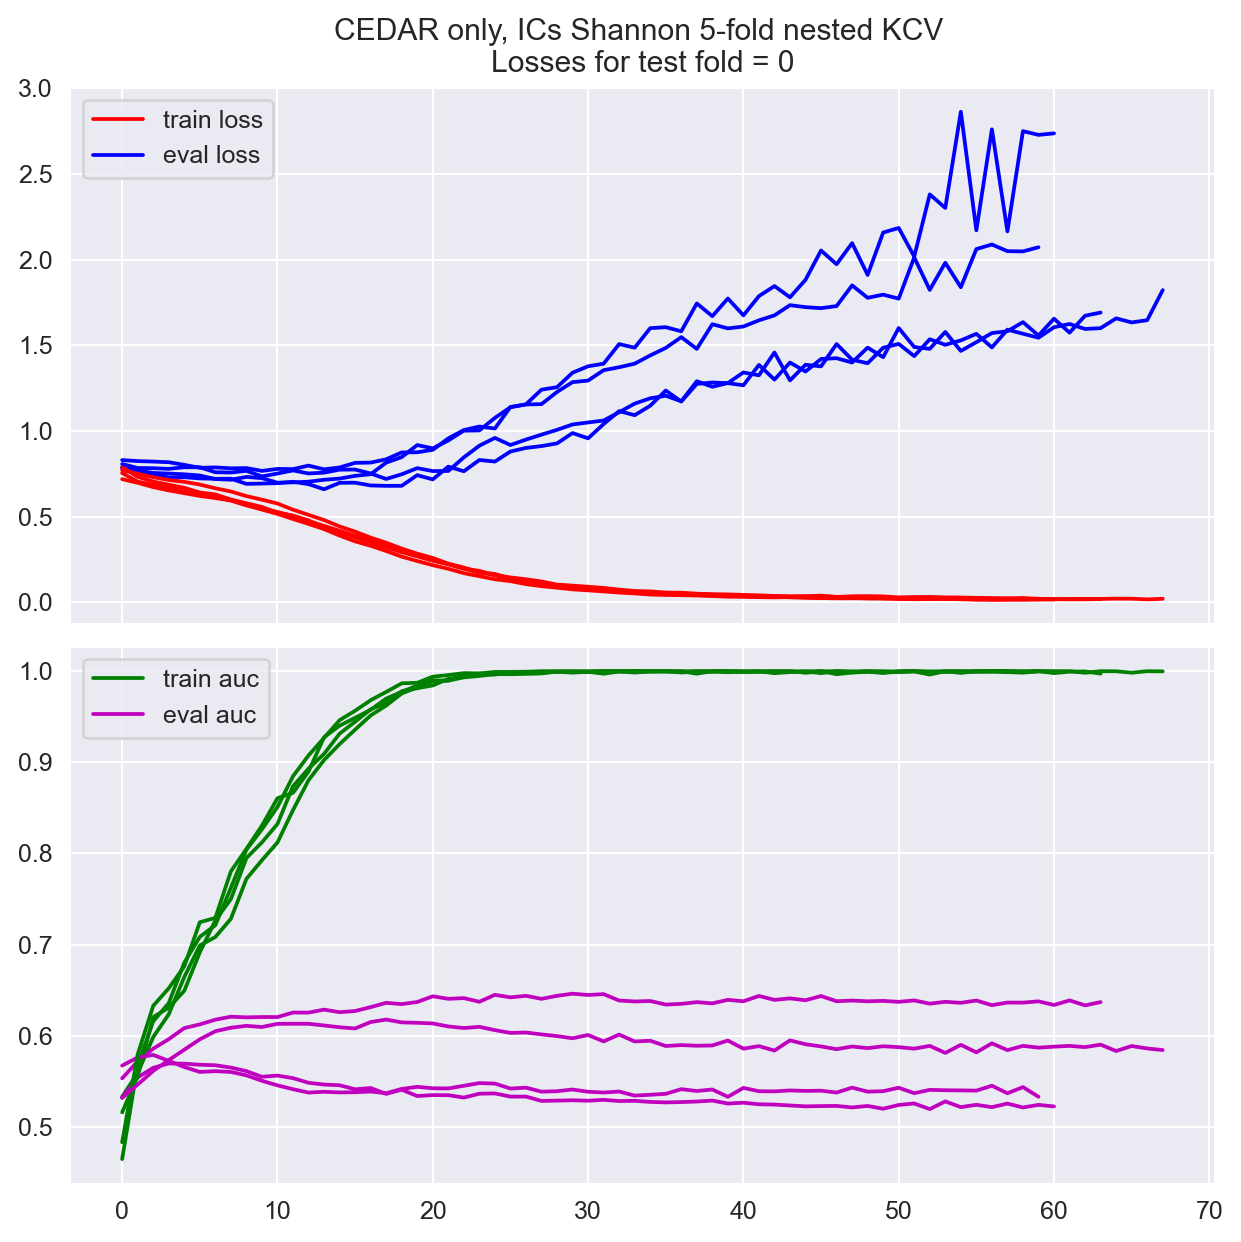

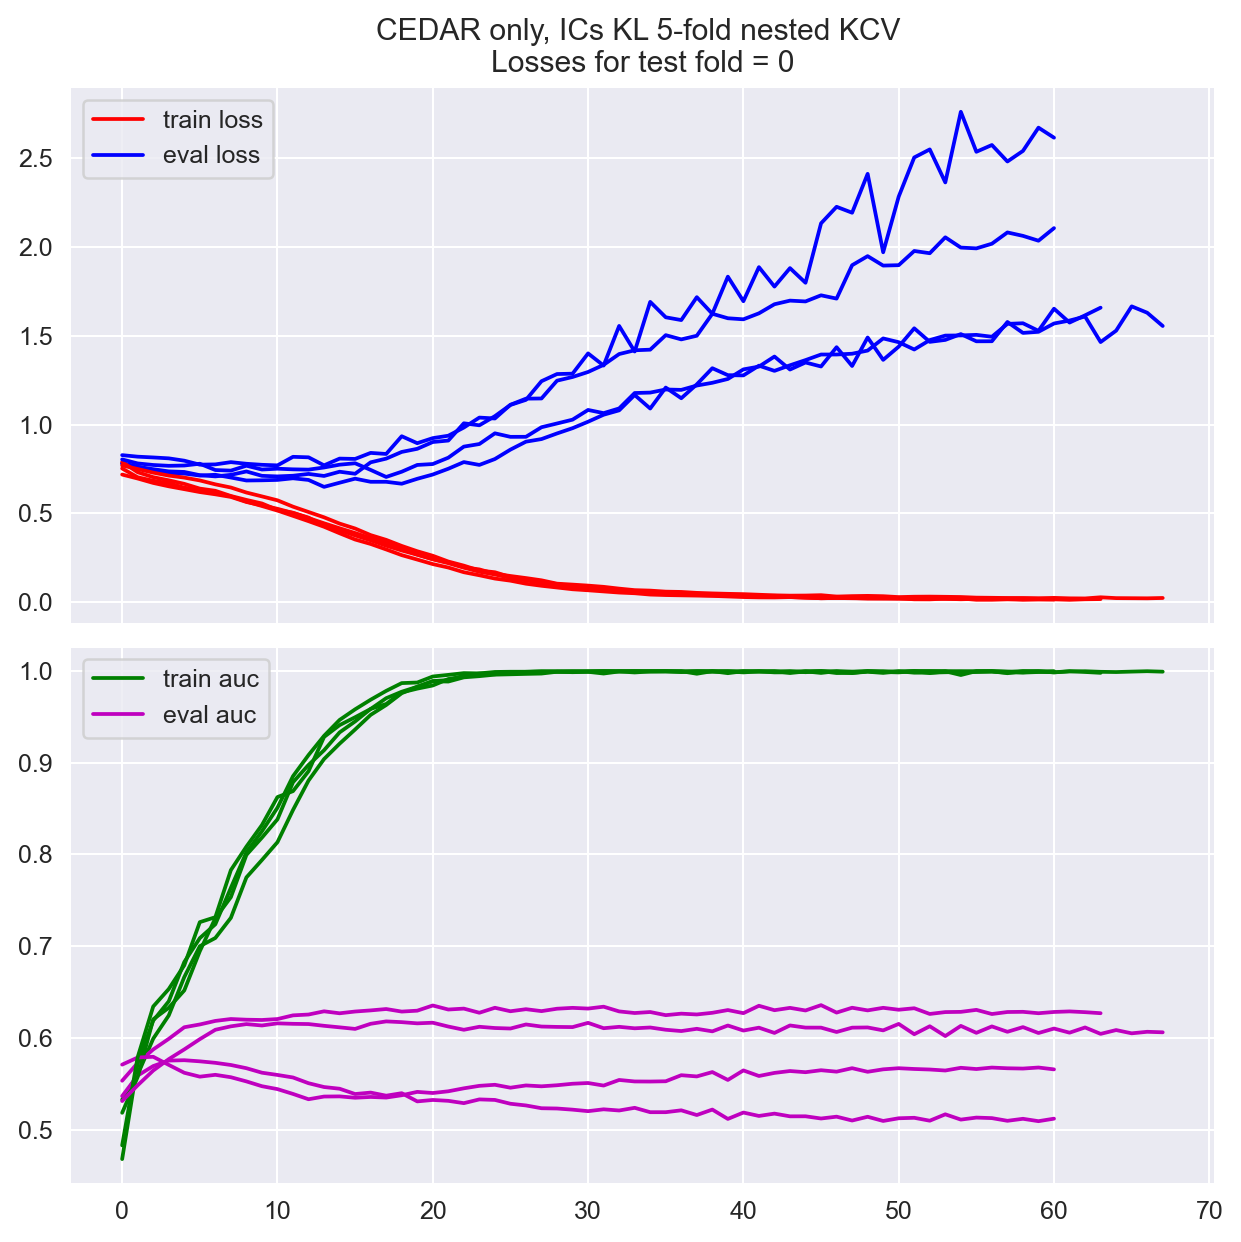

In [201]:
# SHANNON
f,a = plt.subplots(2,1,figsize=(7,7), sharex=True)
for k,v in train_results_shannon[0].items():
    a[0].plot(range(len(v['train']['losses'])), v['train']['losses'], label='train loss', color = 'r')
    a[0].plot(range(len(v['eval']['losses'])), v['eval']['losses'], label='eval loss', color = 'b')
h,l = a[0].get_legend_handles_labels()
a[0].legend(h[:2], l[:2], loc='upper left')
a[0].set_title('CEDAR only, ICs Shannon 5-fold nested KCV \nLosses for test fold = 0')
a[0].set_xlabel(None)

for k,v in train_results_shannon[0].items():
    a[1].plot(range(len(v['train']['auc'])), v['train']['auc'], label='train auc', color = 'g')
    a[1].plot(range(len(v['eval']['auc'])), v['eval']['auc'], label='eval auc', color = 'm')
h,l = a[1].get_legend_handles_labels()
a[1].legend(h[:2], l[:2], loc='upper left')

plt.tight_layout(h_pad=0.9, w_pad=0.9)

# KL
f,a = plt.subplots(2,1,figsize=(7,7), sharex=True)
for k,v in train_results_kl[0].items():
    a[0].plot(range(len(v['train']['losses'])), v['train']['losses'], label='train loss', color = 'r')
    a[0].plot(range(len(v['eval']['losses'])), v['eval']['losses'], label='eval loss', color = 'b')
h,l = a[0].get_legend_handles_labels()
a[0].legend(h[:2], l[:2], loc='upper left')
a[0].set_title('CEDAR only, ICs KL 5-fold nested KCV \nLosses for test fold = 0')
a[0].set_xlabel(None)

for k,v in train_results_kl[0].items():
    a[1].plot(range(len(v['train']['auc'])), v['train']['auc'], label='train auc', color = 'g')
    a[1].plot(range(len(v['eval']['auc'])), v['eval']['auc'], label='eval auc', color = 'm')
h,l = a[1].get_legend_handles_labels()
a[1].legend(h[:2], l[:2], loc='upper left')

plt.tight_layout(h_pad=0.9, w_pad=0.9)
# a[1].set_title('CEDAR only, 5fold nested KCV \nLosses for test fold = 0')

In [208]:
sns.set_palette([pal[0], pal[1]])

Text(0.5, 1.0, '10 fold crossvalidation (CEDAR only)\nPerformance for average prediction on test set')

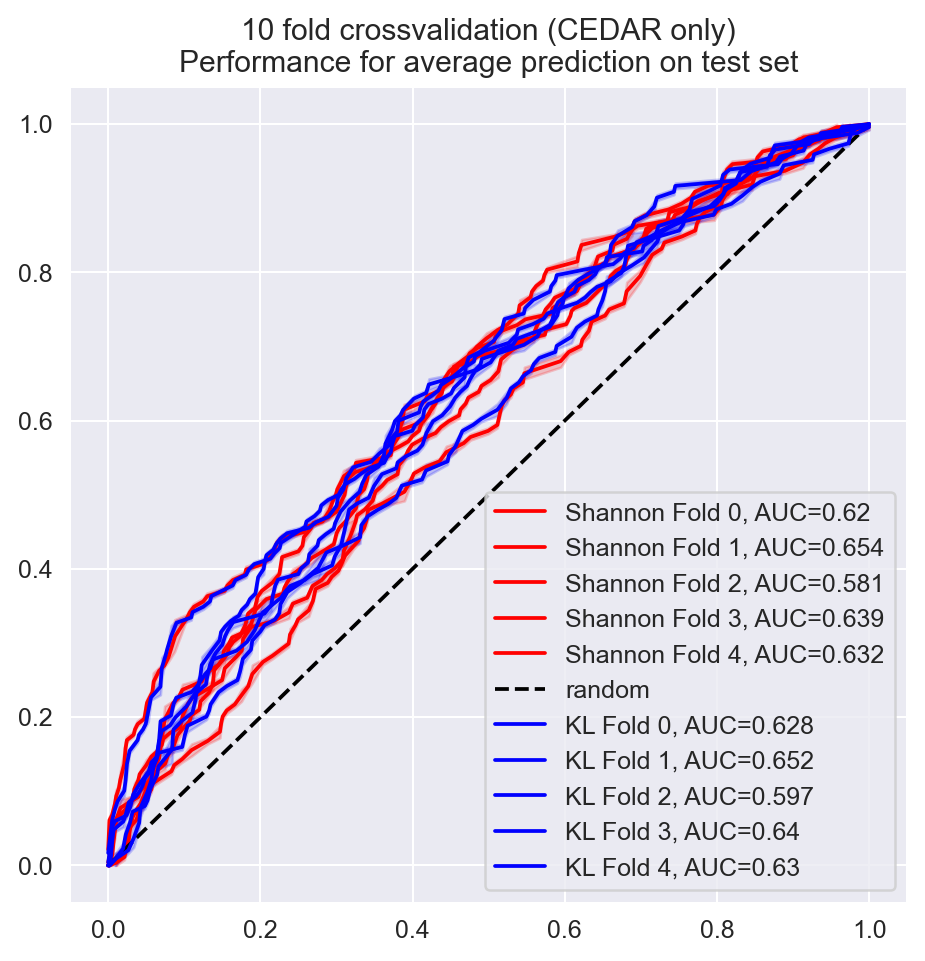

In [212]:
pal = sns.color_palette('icefire',n_colors=2)
f,a = plt.subplots(1,1, figsize= (6,6))

# sns.set_palette([pal[0]])
for k,v in test_results_shannon.items():
    fpr=v['roc_curve'][0]
    tpr=v['roc_curve'][1]
    auc=v['auc']
    sns.lineplot(fpr, tpr, ax=a, label=f'Shannon Fold {k}, AUC={auc.round(3)}', n_boot=100, color='r')
sns.lineplot([0,1],[0,1], ls='--', color='k', label='random')

# sns.set_palette([pal[1]])
for k,v in test_results_kl.items():
    fpr=v['roc_curve'][0]
    tpr=v['roc_curve'][1]
    auc=v['auc']
    sns.lineplot(fpr, tpr, ax=a, label=f'KL Fold {k}, AUC={auc.round(3)}', n_boot=100, color='b')
a.legend(loc='lower right')
a.set_title('10 fold crossvalidation (CEDAR only)\nPerformance for average prediction on test set')

<AxesSubplot:>

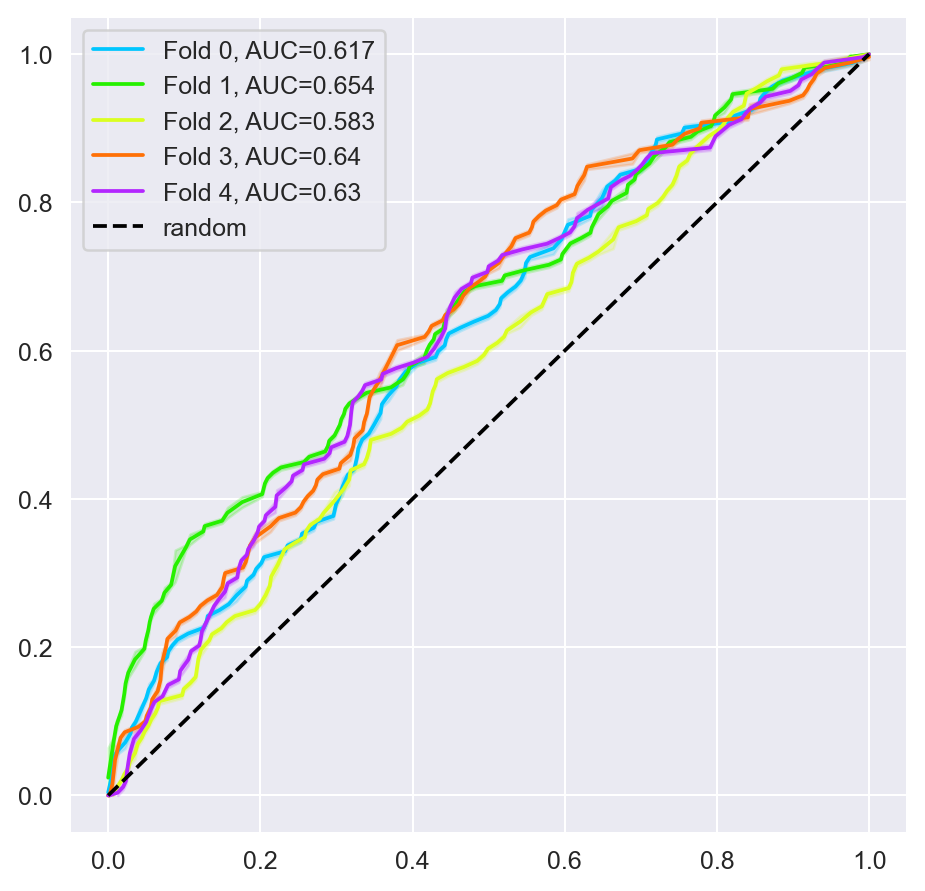

In [145]:
sns.set_palette('gist_ncar',n_colors=5)
f,a = plt.subplots(1,1, figsize= (6,6))
for k in test_results:
    fpr=test_results[k]['roc_curve'][0]
    tpr=test_results[k]['roc_curve'][1]
    auc=test_results[k]['auc']
    sns.lineplot(fpr, tpr, ax=a, label=f'Fold {k}, AUC={auc.round(3)}', n_boot=100)
sns.lineplot([0,1],[0,1], ls='--', color='k', label='random')

## 10fold

In [ ]:
from src.train_eval import train_loop, nested_kcv_train
from src.models import *
from src.partition_tools import pipeline_stratified_kfold
import pandas as pd
from src.utils import pkl_load, pkl_dump
from torch import optim, nn

# Load data
cedar = pd.read_csv('../data/cedar_neoepitope_220701_scored.csv')
# This has seed=13 by default
dataset_10fold = pipeline_stratified_kfold('../out/cedar_peps_hobohm_0.925.pep', cedar, k=10, shuffle=True)
ics_kl = pkl_load('../output/ics_kl.pkl')
ics_shannon = pkl_load('../output/ics_shannon.pkl')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Set up hyperparams
n_epochs = 300
lr = 5e-4
batch_size = 256
# init objects
model = Net(n_filters=16, n_hidden=32, act_cnn=nn.SELU(), act_lin=nn.SELU())
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2)

models_fold_10_sh, train_results_10_sh, test_results_10_sh= nested_kcv_train(dataset_10fold, ics_shannon, model, criterion, optimizer, device, batch_size,
                                                            n_epochs, early_stopping=True, patience=25, delta=1e-4, filename='model_cedar_10fold_sh')


models_fold_10_kl, train_results_10_kl, test_results_10_kl= nested_kcv_train(dataset_10fold, ics_kl, model, criterion, optimizer, device, batch_size,
                                                            n_epochs, early_stopping=True, patience=25, delta=1e-4, filename='model_cedar_10fold_kl')

Using cuda
folds: Outer:	0	Inner:	1


  1%|▌                                                                                           | 2/300 [00:00<00:35,  8.39it/s]

Train Epoch: 0	Train Loss: 0.74630	Eval Loss:1.30801
	Train AUC, Accuracy:	(0.525845466155811, 0.5815295815295816)
	Eval AUC, Accuracy:	(0.5394192937895314, 0.8083333333333333)


 11%|█████████▋                                                                                 | 32/300 [00:02<00:17, 15.70it/s]

Train Epoch: 29	Train Loss: 0.16529	Eval Loss:1.34047
	Train AUC, Accuracy:	(0.9989280544912729, 0.9812409812409812)
	Eval AUC, Accuracy:	(0.6586483390607102, 0.7027777777777777)


Early Stopping at epoch=44;current best valid loss:1.7603800892829895; previous avg losses: (1.4209981958071392,), previous losses std: 0.21468518358154629
folds: Outer:	0	Inner:	2


  1%|█▏                                                                                          | 4/300 [00:00<00:18, 15.67it/s]

Train Epoch: 0	Train Loss: 0.77528	Eval Loss:1.32598
	Train AUC, Accuracy:	(0.4741924321375258, 0.525411596277738)
	Eval AUC, Accuracy:	(0.5536492374727668, 0.7988165680473372)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:15, 17.18it/s]

Train Epoch: 29	Train Loss: 0.17681	Eval Loss:1.46790
	Train AUC, Accuracy:	(0.998145206035363, 0.9817465998568361)
	Eval AUC, Accuracy:	(0.6633986928104574, 0.7307692307692307)


Early Stopping at epoch=41;current best valid loss:2.042447090148926; previous avg losses: (1.5619361301263173,), previous losses std: 0.2481163921936067
folds: Outer:	0	Inner:	3


  1%|█▏                                                                                          | 4/300 [00:00<00:20, 14.73it/s]

Train Epoch: 0	Train Loss: 0.80823	Eval Loss:1.38806
	Train AUC, Accuracy:	(0.5083039832780663, 0.4661627069834413)
	Eval AUC, Accuracy:	(0.5137609795049243, 0.4604519774011299)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.65it/s]

Train Epoch: 29	Train Loss: 0.20722	Eval Loss:1.66153
	Train AUC, Accuracy:	(0.9961268057459698, 0.9683225341972642)
	Eval AUC, Accuracy:	(0.592653713068938, 0.6497175141242938)


Early Stopping at epoch=33;current best valid loss:1.868971586227417; previous avg losses: (1.4308953831593196,), previous losses std: 0.15294522285777015
folds: Outer:	0	Inner:	4


  1%|▌                                                                                           | 2/300 [00:00<00:22, 13.26it/s]

Train Epoch: 0	Train Loss: 0.82521	Eval Loss:1.35749
	Train AUC, Accuracy:	(0.49120407067426936, 0.5059288537549407)
	Eval AUC, Accuracy:	(0.5222354576136589, 0.7306590257879656)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:15, 17.16it/s]

Train Epoch: 29	Train Loss: 0.21139	Eval Loss:1.59462
	Train AUC, Accuracy:	(0.9962148525062432, 0.9637082285303629)
	Eval AUC, Accuracy:	(0.5488882271193171, 0.6590257879656161)


Early Stopping at epoch=40;current best valid loss:2.085052490234375; previous avg losses: (1.6017653743426006,), previous losses std: 0.22181493077390158
folds: Outer:	0	Inner:	5


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 16.59it/s]

Train Epoch: 0	Train Loss: 0.77966	Eval Loss:1.26322
	Train AUC, Accuracy:	(0.47729105492612556, 0.5460078768349445)
	Eval AUC, Accuracy:	(0.5738498789346247, 0.8259587020648967)


 11%|█████████▋                                                                                 | 32/300 [00:02<00:18, 14.53it/s]

Train Epoch: 29	Train Loss: 0.19117	Eval Loss:1.25466
	Train AUC, Accuracy:	(0.9959014076544745, 0.9767275331185106)
	Eval AUC, Accuracy:	(0.7030266343825666, 0.7433628318584071)


Early Stopping at epoch=45;current best valid loss:1.8235987424850464; previous avg losses: (1.4313522924979527,), previous losses std: 0.23024099388724334
folds: Outer:	0	Inner:	6


  1%|▌                                                                                           | 2/300 [00:00<00:27, 10.99it/s]

Train Epoch: 0	Train Loss: 0.79340	Eval Loss:1.33949
	Train AUC, Accuracy:	(0.5019074330741428, 0.5189828080229226)
	Eval AUC, Accuracy:	(0.45862937062937065, 0.7794117647058824)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 17.90it/s]

Train Epoch: 29	Train Loss: 0.18631	Eval Loss:1.92169
	Train AUC, Accuracy:	(0.9979302232707673, 0.9774355300859598)
	Eval AUC, Accuracy:	(0.6204195804195805, 0.6205882352941177)


Early Stopping at epoch=40;current best valid loss:2.231436610221863; previous avg losses: (1.6696148738265038,), previous losses std: 0.2783640217345008
folds: Outer:	0	Inner:	7


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.28it/s]

Train Epoch: 0	Train Loss: 0.85243	Eval Loss:1.43561
	Train AUC, Accuracy:	(0.5369667867146859, 0.47595118449389806)
	Eval AUC, Accuracy:	(0.5711580086580087, 0.1936416184971098)


 11%|██████████                                                                                 | 33/300 [00:01<00:14, 18.18it/s]

Train Epoch: 29	Train Loss: 0.21820	Eval Loss:1.54549
	Train AUC, Accuracy:	(0.9954642909795497, 0.9601579325197416)
	Eval AUC, Accuracy:	(0.6074675324675324, 0.653179190751445)


Early Stopping at epoch=43;current best valid loss:2.1595524549484253; previous avg losses: (1.7092756231625874,), previous losses std: 0.2537813428645453
folds: Outer:	0	Inner:	8


  1%|█▏                                                                                          | 4/300 [00:00<00:18, 15.94it/s]

Train Epoch: 0	Train Loss: 0.80092	Eval Loss:1.37288
	Train AUC, Accuracy:	(0.5267360060322543, 0.5016216216216216)
	Eval AUC, Accuracy:	(0.5503161222339304, 0.6470588235294118)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:17, 15.64it/s]

Train Epoch: 29	Train Loss: 0.19606	Eval Loss:1.29583
	Train AUC, Accuracy:	(0.9972188737875897, 0.9704504504504504)
	Eval AUC, Accuracy:	(0.6968914646996839, 0.7282913165266106)


Early Stopping at epoch=43;current best valid loss:1.6719613671302795; previous avg losses: (1.3512886787454288,), previous losses std: 0.19880465669897496
folds: Outer:	0	Inner:	9


  1%|█▏                                                                                          | 4/300 [00:00<00:19, 15.50it/s]

Train Epoch: 0	Train Loss: 0.84006	Eval Loss:1.38209
	Train AUC, Accuracy:	(0.5055012603740087, 0.48293208767517065)
	Eval AUC, Accuracy:	(0.5619023224043717, 0.5243553008595988)


 11%|██████████                                                                                 | 33/300 [00:01<00:15, 17.66it/s]

Train Epoch: 29	Train Loss: 0.19609	Eval Loss:1.27955
	Train AUC, Accuracy:	(0.9981508931487576, 0.9748472871002515)
	Eval AUC, Accuracy:	(0.6752049180327869, 0.7363896848137536)


Early Stopping at epoch=44;current best valid loss:1.8603106141090393; previous avg losses: (1.446783942480882,), previous losses std: 0.21513517572733734
folds: Outer:	1	Inner:	0


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.40it/s]

Train Epoch: 0	Train Loss: 0.77836	Eval Loss:1.27918
	Train AUC, Accuracy:	(0.4807364836100468, 0.5458152958152959)
	Eval AUC, Accuracy:	(0.4011955786149335, 0.8218390804597702)


Early Stopping at epoch=27;current best valid loss:1.7154030203819275; previous avg losses: (1.3611229409774144,), previous losses std: 0.09400172400249551
folds: Outer:	1	Inner:	2


  1%|█▏                                                                                          | 4/300 [00:00<00:18, 16.40it/s]

Train Epoch: 0	Train Loss: 0.77162	Eval Loss:1.31632
	Train AUC, Accuracy:	(0.5094017050158391, 0.5618260244428469)
	Eval AUC, Accuracy:	(0.6043572984749456, 0.7988165680473372)


 11%|██████████                                                                                 | 33/300 [00:01<00:14, 19.03it/s]

Train Epoch: 29	Train Loss: 0.17588	Eval Loss:1.41285
	Train AUC, Accuracy:	(0.9986752259556504, 0.9791516894320632)
	Eval AUC, Accuracy:	(0.6222222222222222, 0.7485207100591716)


Early Stopping at epoch=42;current best valid loss:1.82710200548172; previous avg losses: (1.4495445638895035,), previous losses std: 0.21806797664646882
folds: Outer:	1	Inner:	3


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.25it/s]

Train Epoch: 0	Train Loss: 0.81586	Eval Loss:1.36944
	Train AUC, Accuracy:	(0.5389236601488776, 0.5151843817787418)
	Eval AUC, Accuracy:	(0.5395262177269098, 0.6242937853107344)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.21it/s]

Train Epoch: 29	Train Loss: 0.17917	Eval Loss:1.31762
	Train AUC, Accuracy:	(0.9986983286642948, 0.9757772957339118)
	Eval AUC, Accuracy:	(0.7167420814479638, 0.7457627118644068)


Early Stopping at epoch=42;current best valid loss:1.7360281944274902; previous avg losses: (1.3415132115284603,), previous losses std: 0.19268205348505124
folds: Outer:	1	Inner:	4


  1%|█▏                                                                                          | 4/300 [00:00<00:19, 15.15it/s]

Train Epoch: 0	Train Loss: 0.85245	Eval Loss:1.42478
	Train AUC, Accuracy:	(0.5072450340300989, 0.48466257668711654)
	Eval AUC, Accuracy:	(0.5110680960889418, 0.2607449856733524)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.26it/s]

Train Epoch: 29	Train Loss: 0.24393	Eval Loss:1.78276
	Train AUC, Accuracy:	(0.9900715238210692, 0.9527246481414652)
	Eval AUC, Accuracy:	(0.5782211633909072, 0.6103151862464183)


Early Stopping at epoch=38;current best valid loss:2.0886725783348083; previous avg losses: (1.6773219630122185,), previous losses std: 0.21756328570787914
folds: Outer:	1	Inner:	5


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.69it/s]

Train Epoch: 0	Train Loss: 0.81768	Eval Loss:1.36424
	Train AUC, Accuracy:	(0.48978638973319827, 0.4955052139518159)
	Eval AUC, Accuracy:	(0.5662227602905568, 0.7079646017699115)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.13it/s]

Train Epoch: 29	Train Loss: 0.22265	Eval Loss:1.46195
	Train AUC, Accuracy:	(0.9946740965889902, 0.9582883854728514)
	Eval AUC, Accuracy:	(0.6285108958837773, 0.640117994100295)


Early Stopping at epoch=40;current best valid loss:1.746840238571167; previous avg losses: (1.4142216245333354,), previous losses std: 0.17573052412351226
folds: Outer:	1	Inner:	6


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 18.03it/s]

Train Epoch: 0	Train Loss: 0.85435	Eval Loss:1.48345
	Train AUC, Accuracy:	(0.5121806556513692, 0.4456834532374101)
	Eval AUC, Accuracy:	(0.5516923076923076, 0.19117647058823528)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.59it/s]

Train Epoch: 29	Train Loss: 0.21722	Eval Loss:1.47478
	Train AUC, Accuracy:	(0.9966568921453582, 0.9589928057553957)
	Eval AUC, Accuracy:	(0.6279160839160839, 0.6558823529411765)


Early Stopping at epoch=45;current best valid loss:2.0722668170928955; previous avg losses: (1.6341378477712472,), previous losses std: 0.26085869859013566
folds: Outer:	1	Inner:	7


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.54it/s]

Train Epoch: 0	Train Loss: 0.76733	Eval Loss:1.29575
	Train AUC, Accuracy:	(0.5185451408855664, 0.5731795241528479)
	Eval AUC, Accuracy:	(0.5252705627705628, 0.8092485549132948)


 10%|█████████▍                                                                                 | 31/300 [00:01<00:13, 19.46it/s]

Train Epoch: 29	Train Loss: 0.19784	Eval Loss:1.61277
	Train AUC, Accuracy:	(0.9963811645992497, 0.9689978370583994)
	Eval AUC, Accuracy:	(0.5519480519480521, 0.661849710982659)


Early Stopping at epoch=33;current best valid loss:1.6760886907577515; previous avg losses: (1.3566970452666283,), previous losses std: 0.15612890803371715
folds: Outer:	1	Inner:	8


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.02it/s]

Train Epoch: 0	Train Loss: 0.84159	Eval Loss:1.47680
	Train AUC, Accuracy:	(0.5095446130808252, 0.4654361201592472)
	Eval AUC, Accuracy:	(0.5252370916754479, 0.18207282913165265)


 11%|██████████▎                                                                                | 34/300 [00:01<00:14, 18.85it/s]

Train Epoch: 29	Train Loss: 0.20735	Eval Loss:2.02833
	Train AUC, Accuracy:	(0.9960571371656036, 0.9638074556641332)
	Eval AUC, Accuracy:	(0.5375658587987355, 0.6610644257703081)


Early Stopping at epoch=34;current best valid loss:2.4568188190460205; previous avg losses: (1.6549410050113995,), previous losses std: 0.3063417740299028
folds: Outer:	1	Inner:	9


  1%|▌                                                                                           | 2/300 [00:00<00:18, 16.29it/s]

Train Epoch: 0	Train Loss: 0.76901	Eval Loss:1.30283
	Train AUC, Accuracy:	(0.4950616821921164, 0.5492601948754963)
	Eval AUC, Accuracy:	(0.5384221311475409, 0.8252148997134671)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:13, 19.74it/s]

Train Epoch: 29	Train Loss: 0.16706	Eval Loss:1.57609
	Train AUC, Accuracy:	(0.9986518715595082, 0.9841212558643089)
	Eval AUC, Accuracy:	(0.6303506375227687, 0.6934097421203438)


Early Stopping at epoch=42;current best valid loss:2.082435131072998; previous avg losses: (1.5964332496126492,), previous losses std: 0.3147822685197969
folds: Outer:	2	Inner:	0


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.29it/s]

Train Epoch: 0	Train Loss: 0.79298	Eval Loss:1.38064
	Train AUC, Accuracy:	(0.5074511695810422, 0.5021474588403723)
	Eval AUC, Accuracy:	(0.5368824723663433, 0.603448275862069)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:15, 17.31it/s]

Train Epoch: 29	Train Loss: 0.20161	Eval Loss:1.54866
	Train AUC, Accuracy:	(0.9967450597061798, 0.9688618468146027)
	Eval AUC, Accuracy:	(0.6156101962553576, 0.6896551724137931)


Early Stopping at epoch=48;current best valid loss:2.1491485834121704; previous avg losses: (1.6789829408129056,), previous losses std: 0.21456205397560285
folds: Outer:	2	Inner:	1


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.64it/s]

Train Epoch: 0	Train Loss: 0.83422	Eval Loss:1.39165
	Train AUC, Accuracy:	(0.5315251749830662, 0.49065420560747663)
	Eval AUC, Accuracy:	(0.5391453757657254, 0.4583333333333333)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 19.05it/s]

Train Epoch: 29	Train Loss: 0.22033	Eval Loss:1.54987
	Train AUC, Accuracy:	(0.9962565939366571, 0.9608195542774982)
	Eval AUC, Accuracy:	(0.6659694207878878, 0.65)


Early Stopping at epoch=38;current best valid loss:1.6849632859230042; previous avg losses: (1.4039759039878845,), previous losses std: 0.14881199056771924
folds: Outer:	2	Inner:	3


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.07it/s]

Train Epoch: 0	Train Loss: 0.89441	Eval Loss:1.50486
	Train AUC, Accuracy:	(0.4978598561931895, 0.44763271162123386)
	Eval AUC, Accuracy:	(0.5304232100079851, 0.18361581920903955)


 11%|██████████                                                                                 | 33/300 [00:01<00:13, 19.33it/s]

Train Epoch: 29	Train Loss: 0.27287	Eval Loss:1.35310
	Train AUC, Accuracy:	(0.9884335571835572, 0.9408177905308465)
	Eval AUC, Accuracy:	(0.6078253926004791, 0.6779661016949152)


Early Stopping at epoch=45;current best valid loss:1.9466478824615479; previous avg losses: (1.4973770280679066,), previous losses std: 0.18638121683508427
folds: Outer:	2	Inner:	4


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 18.02it/s]

Train Epoch: 0	Train Loss: 0.79310	Eval Loss:1.31808
	Train AUC, Accuracy:	(0.5255730080008768, 0.5316863587540279)
	Eval AUC, Accuracy:	(0.5502779432201708, 0.7908309455587392)


 11%|██████████                                                                                 | 33/300 [00:01<00:14, 18.69it/s]

Train Epoch: 29	Train Loss: 0.20977	Eval Loss:1.57834
	Train AUC, Accuracy:	(0.9963917278605875, 0.9641962047977085)
	Eval AUC, Accuracy:	(0.6159420289855072, 0.6962750716332379)


Early Stopping at epoch=41;current best valid loss:2.473784327507019; previous avg losses: (1.7121053089698155,), previous losses std: 0.29108981512452115
folds: Outer:	2	Inner:	5


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 16.57it/s]

Train Epoch: 0	Train Loss: 0.82036	Eval Loss:1.40322
	Train AUC, Accuracy:	(0.48156052173245095, 0.47770246164823404)
	Eval AUC, Accuracy:	(0.49364406779661013, 0.3746312684365782)


 10%|█████████                                                                                  | 30/300 [00:01<00:14, 18.47it/s]

Train Epoch: 29	Train Loss: 0.19487	Eval Loss:1.58025
	Train AUC, Accuracy:	(0.9982199244887293, 0.9696753478415983)
	Eval AUC, Accuracy:	(0.6059927360774818, 0.6607669616519174)


Early Stopping at epoch=41;current best valid loss:2.1557043194770813; previous avg losses: (1.5978335663676262,), previous losses std: 0.2876286279051691
folds: Outer:	2	Inner:	6


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 18.05it/s]

Train Epoch: 0	Train Loss: 0.88031	Eval Loss:1.46725
	Train AUC, Accuracy:	(0.4980339445830243, 0.45895788722341185)
	Eval AUC, Accuracy:	(0.5527272727272727, 0.19117647058823528)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:13, 19.15it/s]

Train Epoch: 29	Train Loss: 0.27147	Eval Loss:1.35147
	Train AUC, Accuracy:	(0.9893320636418795, 0.9296930763740185)
	Eval AUC, Accuracy:	(0.6261258741258742, 0.6411764705882353)


Early Stopping at epoch=55;current best valid loss:1.9614209532737732; previous avg losses: (1.649236047019561,), previous losses std: 0.16573159738621762
folds: Outer:	2	Inner:	7


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 16.62it/s]

Train Epoch: 0	Train Loss: 0.83761	Eval Loss:1.40447
	Train AUC, Accuracy:	(0.444184663083884, 0.46816881258941345)
	Eval AUC, Accuracy:	(0.49512987012987014, 0.3265895953757225)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:15, 17.44it/s]

Train Epoch: 29	Train Loss: 0.21631	Eval Loss:1.42147
	Train AUC, Accuracy:	(0.9951961603130239, 0.9610157367668097)
	Eval AUC, Accuracy:	(0.6382034632034632, 0.6907514450867052)


Early Stopping at epoch=44;current best valid loss:2.0556068420410156; previous avg losses: (1.603296011686325,), previous losses std: 0.2283105606802225
folds: Outer:	2	Inner:	8


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.41it/s]

Train Epoch: 0	Train Loss: 0.78170	Eval Loss:1.32262
	Train AUC, Accuracy:	(0.4805000849040585, 0.5350089766606823)
	Eval AUC, Accuracy:	(0.44726027397260276, 0.8179271708683473)


 11%|██████████                                                                                 | 33/300 [00:01<00:14, 18.48it/s]

Train Epoch: 29	Train Loss: 0.19273	Eval Loss:1.29164
	Train AUC, Accuracy:	(0.9981389030395653, 0.9734290843806104)
	Eval AUC, Accuracy:	(0.6456796628029505, 0.7198879551820728)


Early Stopping at epoch=42;current best valid loss:1.8090118765830994; previous avg losses: (1.426172412931919,), previous losses std: 0.2565934564524938
folds: Outer:	2	Inner:	9


  1%|█▏                                                                                          | 4/300 [00:00<00:19, 15.30it/s]

Train Epoch: 0	Train Loss: 0.83560	Eval Loss:1.41848
	Train AUC, Accuracy:	(0.49819042925053575, 0.48549946294307195)
	Eval AUC, Accuracy:	(0.5225979052823315, 0.20630372492836677)


 11%|██████████▎                                                                                | 34/300 [00:01<00:13, 19.74it/s]

Train Epoch: 29	Train Loss: 0.19722	Eval Loss:1.43016
	Train AUC, Accuracy:	(0.998065529758881, 0.9713569638381668)
	Eval AUC, Accuracy:	(0.6461748633879782, 0.6819484240687679)


Early Stopping at epoch=36;current best valid loss:1.7537278532981873; previous avg losses: (1.4364690283934276,), previous losses std: 0.11562270834753369
folds: Outer:	3	Inner:	0


  1%|▌                                                                                           | 2/300 [00:00<00:19, 14.93it/s]

Train Epoch: 0	Train Loss: 0.78627	Eval Loss:1.33393
	Train AUC, Accuracy:	(0.5230002566371084, 0.5341972642188625)
	Eval AUC, Accuracy:	(0.4802616738100609, 0.8160919540229885)


 11%|██████████▎                                                                                | 34/300 [00:01<00:13, 19.60it/s]

Train Epoch: 29	Train Loss: 0.19677	Eval Loss:1.42264
	Train AUC, Accuracy:	(0.99719556423019, 0.9672426205903528)
	Eval AUC, Accuracy:	(0.5478231445973382, 0.7126436781609196)


Early Stopping at epoch=43;current best valid loss:2.0193085074424744; previous avg losses: (1.5682532091935475,), previous losses std: 0.20779133181802942
folds: Outer:	3	Inner:	1


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.40it/s]

Train Epoch: 0	Train Loss: 0.87038	Eval Loss:1.47007
	Train AUC, Accuracy:	(0.4998760925507185, 0.4403470715835141)
	Eval AUC, Accuracy:	(0.5461925394690971, 0.19166666666666668)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 17.89it/s]

Train Epoch: 29	Train Loss: 0.23668	Eval Loss:1.62758
	Train AUC, Accuracy:	(0.9926084275930313, 0.9522776572668112)
	Eval AUC, Accuracy:	(0.6340455201952289, 0.6333333333333333)


Early Stopping at epoch=40;current best valid loss:2.1665152311325073; previous avg losses: (1.5572545205553372,), previous losses std: 0.2729285928164173
folds: Outer:	3	Inner:	2


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.52it/s]

Train Epoch: 0	Train Loss: 0.79470	Eval Loss:1.34177
	Train AUC, Accuracy:	(0.5350215371048704, 0.5355093256814921)
	Eval AUC, Accuracy:	(0.5514161220043573, 0.7958579881656804)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.58it/s]

Train Epoch: 29	Train Loss: 0.21216	Eval Loss:1.32890
	Train AUC, Accuracy:	(0.9963760005426673, 0.9644906743185079)
	Eval AUC, Accuracy:	(0.6429738562091505, 0.7041420118343196)


Early Stopping at epoch=41;current best valid loss:1.7580779194831848; previous avg losses: (1.5021578818559647,), previous losses std: 0.13016403821147426
folds: Outer:	3	Inner:	4


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.86it/s]

Train Epoch: 0	Train Loss: 0.79605	Eval Loss:1.38781
	Train AUC, Accuracy:	(0.5266350767857296, 0.5153042851998559)
	Eval AUC, Accuracy:	(0.48679769704188997, 0.48424068767908307)


Early Stopping at epoch=28;current best valid loss:1.6970202326774597; previous avg losses: (1.4272051031390827,), previous losses std: 0.08245528017019504
folds: Outer:	3	Inner:	5


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.74it/s]

Train Epoch: 0	Train Loss: 0.85887	Eval Loss:1.41826
	Train AUC, Accuracy:	(0.49118195167444967, 0.4804449228561177)
	Eval AUC, Accuracy:	(0.52227602905569, 0.26253687315634217)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:15, 17.55it/s]

Train Epoch: 29	Train Loss: 0.21113	Eval Loss:1.31664
	Train AUC, Accuracy:	(0.997449103460747, 0.9677072120559742)
	Eval AUC, Accuracy:	(0.626997578692494, 0.6755162241887905)


Early Stopping at epoch=42;current best valid loss:1.9078702330589294; previous avg losses: (1.451472779115041,), previous losses std: 0.2247470107520366
folds: Outer:	3	Inner:	6


  1%|█▏                                                                                          | 4/300 [00:00<00:19, 14.92it/s]

Train Epoch: 0	Train Loss: 0.80073	Eval Loss:1.39567
	Train AUC, Accuracy:	(0.518358766726177, 0.5025125628140703)
	Eval AUC, Accuracy:	(0.5379020979020979, 0.4)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:13, 19.51it/s]

Train Epoch: 29	Train Loss: 0.18275	Eval Loss:1.57215
	Train AUC, Accuracy:	(0.9988331704052811, 0.9770279971284996)
	Eval AUC, Accuracy:	(0.6200839160839161, 0.6264705882352941)


Early Stopping at epoch=41;current best valid loss:2.062819480895996; previous avg losses: (1.6609751855333645,), previous losses std: 0.25347355685751927
folds: Outer:	3	Inner:	7


  1%|█▏                                                                                          | 4/300 [00:00<00:19, 15.35it/s]

Train Epoch: 0	Train Loss: 0.80904	Eval Loss:1.34818
	Train AUC, Accuracy:	(0.45833630276683335, 0.4996402877697842)
	Eval AUC, Accuracy:	(0.43073593073593075, 0.8034682080924855)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.13it/s]

Train Epoch: 29	Train Loss: 0.19961	Eval Loss:1.62378
	Train AUC, Accuracy:	(0.9963764427204762, 0.9712230215827338)
	Eval AUC, Accuracy:	(0.5192099567099567, 0.6445086705202312)


Early Stopping at epoch=38;current best valid loss:2.150359869003296; previous avg losses: (1.5757414723436038,), previous losses std: 0.2496339415277706
folds: Outer:	3	Inner:	8


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.31it/s]

Train Epoch: 0	Train Loss: 0.79997	Eval Loss:1.32751
	Train AUC, Accuracy:	(0.4971796046168331, 0.5359335500180571)
	Eval AUC, Accuracy:	(0.5272918861959959, 0.8179271708683473)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:17, 15.47it/s]

Train Epoch: 29	Train Loss: 0.21363	Eval Loss:1.38692
	Train AUC, Accuracy:	(0.9938603406268037, 0.9628024557602023)
	Eval AUC, Accuracy:	(0.6349841938883034, 0.6890756302521008)


Early Stopping at epoch=39;current best valid loss:1.5124410390853882; previous avg losses: (1.3228296438852947,), previous losses std: 0.10635664811155376
folds: Outer:	3	Inner:	9


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 18.11it/s]

Train Epoch: 0	Train Loss: 0.83626	Eval Loss:1.41120
	Train AUC, Accuracy:	(0.498504743833017, 0.4890169247389269)
	Eval AUC, Accuracy:	(0.44894125683060104, 0.332378223495702)


Train Epoch: 29	Train Loss: 0.21004	Eval Loss:1.77820
	Train AUC, Accuracy:	(0.9963997469955724, 0.9643500180050414)
	Eval AUC, Accuracy:	(0.559938524590164, 0.6504297994269341)
Early Stopping at epoch=31;current best valid loss:1.8825817704200745; previous avg losses: (1.4506468176841736,), previous losses std: 0.15155111574148042
folds: Outer:	4	Inner:	0


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.60it/s]

Train Epoch: 0	Train Loss: 0.77246	Eval Loss:1.37885
	Train AUC, Accuracy:	(0.5102670314590845, 0.5382680560546174)
	Eval AUC, Accuracy:	(0.5949131513647644, 0.6149425287356322)


 11%|██████████                                                                                 | 33/300 [00:01<00:14, 18.86it/s]

Train Epoch: 29	Train Loss: 0.19309	Eval Loss:1.51658
	Train AUC, Accuracy:	(0.9971694494873302, 0.9752066115702479)
	Eval AUC, Accuracy:	(0.5702684412361833, 0.6982758620689655)


Early Stopping at epoch=37;current best valid loss:1.8377243876457214; previous avg losses: (1.4140632450580597,), previous losses std: 0.18575128677085023
folds: Outer:	4	Inner:	1


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 16.70it/s]

Train Epoch: 0	Train Loss: 0.76728	Eval Loss:1.29260
	Train AUC, Accuracy:	(0.510140623105831, 0.5745218332731866)
	Eval AUC, Accuracy:	(0.5168584092833308, 0.8083333333333333)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.08it/s]

Train Epoch: 29	Train Loss: 0.20135	Eval Loss:1.34018
	Train AUC, Accuracy:	(0.9962090643021665, 0.9714904366654638)
	Eval AUC, Accuracy:	(0.6602918472035461, 0.6888888888888889)


Early Stopping at epoch=44;current best valid loss:1.9905275702476501; previous avg losses: (1.5315345550576847,), previous losses std: 0.2611098712750033
folds: Outer:	4	Inner:	2


  1%|▉                                                                                           | 3/300 [00:00<00:28, 10.24it/s]

Train Epoch: 0	Train Loss: 0.83853	Eval Loss:1.40889
	Train AUC, Accuracy:	(0.5184155455392372, 0.4790547798066595)
	Eval AUC, Accuracy:	(0.5595860566448801, 0.3047337278106509)


 11%|██████████                                                                                 | 33/300 [00:01<00:14, 18.68it/s]

Train Epoch: 29	Train Loss: 0.24073	Eval Loss:1.61055
	Train AUC, Accuracy:	(0.9943238642590969, 0.9573934837092731)
	Eval AUC, Accuracy:	(0.5709694989106754, 0.6153846153846154)


Early Stopping at epoch=36;current best valid loss:1.7399739623069763; previous avg losses: (1.4682740444938343,), previous losses std: 0.15404749449115338
folds: Outer:	4	Inner:	3


  1%|█▏                                                                                          | 4/300 [00:00<00:18, 15.97it/s]

Train Epoch: 0	Train Loss: 0.86561	Eval Loss:1.48259
	Train AUC, Accuracy:	(0.5185873829328801, 0.4609290601368383)
	Eval AUC, Accuracy:	(0.44495608198030345, 0.18361581920903955)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:15, 17.59it/s]

Train Epoch: 29	Train Loss: 0.20536	Eval Loss:1.30073
	Train AUC, Accuracy:	(0.9976650957568266, 0.9683111271155924)
	Eval AUC, Accuracy:	(0.6214000532339633, 0.731638418079096)


Early Stopping at epoch=45;current best valid loss:1.7465956807136536; previous avg losses: (1.3934676212569077,), previous losses std: 0.20052690363579823
folds: Outer:	4	Inner:	5


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.51it/s]

Train Epoch: 0	Train Loss: 0.80303	Eval Loss:1.36238
	Train AUC, Accuracy:	(0.5015775136896748, 0.5250716332378224)
	Eval AUC, Accuracy:	(0.5572033898305084, 0.6991150442477876)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.93it/s]

Train Epoch: 29	Train Loss: 0.20905	Eval Loss:1.26767
	Train AUC, Accuracy:	(0.9956913127297283, 0.9627507163323782)
	Eval AUC, Accuracy:	(0.6262106537530268, 0.7168141592920354)


Early Stopping at epoch=44;current best valid loss:1.8983489871025085; previous avg losses: (1.4595423166950543,), previous losses std: 0.23274236888123342
folds: Outer:	4	Inner:	6


  1%|▌                                                                                           | 2/300 [00:00<00:32,  9.09it/s]

Train Epoch: 0	Train Loss: 0.81202	Eval Loss:1.38685
	Train AUC, Accuracy:	(0.4810752128585323, 0.5026872088857041)
	Eval AUC, Accuracy:	(0.44246153846153846, 0.4852941176470588)


 11%|██████████▎                                                                                | 34/300 [00:01<00:13, 19.80it/s]

Train Epoch: 29	Train Loss: 0.20132	Eval Loss:1.83001
	Train AUC, Accuracy:	(0.996848499326019, 0.968828376925833)
	Eval AUC, Accuracy:	(0.5135664335664336, 0.6294117647058823)


Early Stopping at epoch=37;current best valid loss:2.300701379776001; previous avg losses: (1.6975960830847423,), previous losses std: 0.31697282278750477
folds: Outer:	4	Inner:	7


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.13it/s]

Train Epoch: 0	Train Loss: 0.78487	Eval Loss:1.31176
	Train AUC, Accuracy:	(0.5187322131356796, 0.5482944344703771)
	Eval AUC, Accuracy:	(0.5579545454545455, 0.8092485549132948)


Early Stopping at epoch=28;current best valid loss:1.5917605757713318; previous avg losses: (1.3958545252680779,), previous losses std: 0.11413497268817874
folds: Outer:	4	Inner:	8


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.19it/s]

Train Epoch: 0	Train Loss: 0.76566	Eval Loss:1.26779
	Train AUC, Accuracy:	(0.4944480975773282, 0.5663302090843547)
	Eval AUC, Accuracy:	(0.5585353003161222, 0.8179271708683473)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:13, 19.48it/s]

Train Epoch: 29	Train Loss: 0.20227	Eval Loss:1.41376
	Train AUC, Accuracy:	(0.9963743730579301, 0.9664744051910599)
	Eval AUC, Accuracy:	(0.6358798735511063, 0.7058823529411765)


Early Stopping at epoch=43;current best valid loss:1.8885590434074402; previous avg losses: (1.4518073548873265,), previous losses std: 0.19374452229769085
folds: Outer:	4	Inner:	9


  1%|▌                                                                                           | 2/300 [00:00<00:20, 14.76it/s]

Train Epoch: 0	Train Loss: 0.79555	Eval Loss:1.38140
	Train AUC, Accuracy:	(0.534773609468564, 0.5305535585909418)
	Eval AUC, Accuracy:	(0.5361452641165755, 0.5873925501432665)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.13it/s]

Train Epoch: 29	Train Loss: 0.18428	Eval Loss:1.72114
	Train AUC, Accuracy:	(0.9984231547632731, 0.9744787922358016)
	Eval AUC, Accuracy:	(0.595002276867031, 0.6790830945558739)


Early Stopping at epoch=42;current best valid loss:2.187601089477539; previous avg losses: (1.7196581562360127,), previous losses std: 0.32367736242742357
folds: Outer:	5	Inner:	0


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 18.37it/s]

Train Epoch: 0	Train Loss: 0.82842	Eval Loss:1.45086
	Train AUC, Accuracy:	(0.5155098050300453, 0.4872896527031865)
	Eval AUC, Accuracy:	(0.4917662982179111, 0.1839080459770115)


Train Epoch: 29	Train Loss: 0.22603	Eval Loss:1.92618
	Train AUC, Accuracy:	(0.9958839491475261, 0.9624060150375939)
	Eval AUC, Accuracy:	(0.5345138732235506, 0.5660919540229885)
Early Stopping at epoch=30;current best valid loss:1.9079859852790833; previous avg losses: (1.59365517894427,), previous losses std: 0.1295830911836772
folds: Outer:	5	Inner:	1


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 18.05it/s]

Train Epoch: 0	Train Loss: 0.79046	Eval Loss:1.22933
	Train AUC, Accuracy:	(0.5108696386355961, 0.5569938870909744)
	Eval AUC, Accuracy:	(0.44817969022361676, 0.8083333333333333)


 11%|██████████                                                                                 | 33/300 [00:01<00:14, 18.85it/s]

Train Epoch: 29	Train Loss: 0.21553	Eval Loss:1.55659
	Train AUC, Accuracy:	(0.9954795677136102, 0.9651204602660913)
	Eval AUC, Accuracy:	(0.6106877832561382, 0.6388888888888888)


Early Stopping at epoch=38;current best valid loss:1.8819352984428406; previous avg losses: (1.4474280700087547,), previous losses std: 0.21782803328083084
folds: Outer:	5	Inner:	2


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 18.14it/s]

Train Epoch: 0	Train Loss: 0.75350	Eval Loss:1.26517
	Train AUC, Accuracy:	(0.5293846048516242, 0.5733143061006065)
	Eval AUC, Accuracy:	(0.5478213507625272, 0.7988165680473372)


 11%|██████████                                                                                 | 33/300 [00:01<00:16, 15.96it/s]

Train Epoch: 29	Train Loss: 0.21462	Eval Loss:1.55025
	Train AUC, Accuracy:	(0.9951139765985195, 0.962183374955405)
	Eval AUC, Accuracy:	(0.564161220043573, 0.6390532544378699)


Early Stopping at epoch=38;current best valid loss:1.7843406200408936; previous avg losses: (1.4488095094760258,), previous losses std: 0.19617657673589273
folds: Outer:	5	Inner:	3


  1%|█▏                                                                                          | 4/300 [00:00<00:18, 16.17it/s]

Train Epoch: 0	Train Loss: 0.85116	Eval Loss:1.47276
	Train AUC, Accuracy:	(0.5286316579069421, 0.45174022246142803)
	Eval AUC, Accuracy:	(0.570721320202289, 0.18361581920903955)


 11%|██████████                                                                                 | 33/300 [00:01<00:13, 19.37it/s]

Train Epoch: 29	Train Loss: 0.21169	Eval Loss:1.61081
	Train AUC, Accuracy:	(0.9976416555460861, 0.9669895945461069)
	Eval AUC, Accuracy:	(0.622784136278946, 0.652542372881356)


Early Stopping at epoch=48;current best valid loss:2.279964327812195; previous avg losses: (1.8942752902706463,), previous losses std: 0.2752524730023735
folds: Outer:	5	Inner:	4


  1%|█▏                                                                                          | 4/300 [00:00<00:19, 15.16it/s]

Train Epoch: 0	Train Loss: 0.80242	Eval Loss:1.35026
	Train AUC, Accuracy:	(0.507109164961532, 0.5211318051575932)
	Eval AUC, Accuracy:	(0.5628846535636292, 0.7564469914040115)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.17it/s]

Train Epoch: 29	Train Loss: 0.21899	Eval Loss:1.48128
	Train AUC, Accuracy:	(0.9951622350068585, 0.9609598853868195)
	Eval AUC, Accuracy:	(0.5987194758784989, 0.6991404011461319)


Early Stopping at epoch=44;current best valid loss:1.944705843925476; previous avg losses: (1.600113682448864,), previous losses std: 0.20276976938918737
folds: Outer:	5	Inner:	6


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.53it/s]

Train Epoch: 0	Train Loss: 0.85077	Eval Loss:1.38642
	Train AUC, Accuracy:	(0.5014177693761815, 0.47197429489468046)
	Eval AUC, Accuracy:	(0.5493146853146853, 0.5)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:16, 16.57it/s]

Train Epoch: 29	Train Loss: 0.22903	Eval Loss:1.72211
	Train AUC, Accuracy:	(0.9942032868287227, 0.9550160656908248)
	Eval AUC, Accuracy:	(0.6347972027972028, 0.6470588235294118)


Early Stopping at epoch=37;current best valid loss:2.056623697280884; previous avg losses: (1.5950531288981438,), previous losses std: 0.2536925426425901
folds: Outer:	5	Inner:	7


  1%|█▏                                                                                          | 4/300 [00:00<00:18, 15.72it/s]

Train Epoch: 0	Train Loss: 0.80084	Eval Loss:1.37633
	Train AUC, Accuracy:	(0.5471187392228416, 0.5148479427549195)
	Eval AUC, Accuracy:	(0.5674242424242424, 0.6011560693641619)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 19.11it/s]

Train Epoch: 29	Train Loss: 0.22001	Eval Loss:1.61404
	Train AUC, Accuracy:	(0.9944401558594325, 0.9635062611806798)
	Eval AUC, Accuracy:	(0.6065476190476191, 0.6473988439306358)


Early Stopping at epoch=37;current best valid loss:1.8356156945228577; previous avg losses: (1.5029152755935986,), previous losses std: 0.18141610116543613
folds: Outer:	5	Inner:	8


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.91it/s]

Train Epoch: 0	Train Loss: 0.80121	Eval Loss:1.34796
	Train AUC, Accuracy:	(0.524316054640182, 0.5118534482758621)
	Eval AUC, Accuracy:	(0.4350105374077977, 0.7871148459383753)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.28it/s]

Train Epoch: 29	Train Loss: 0.20335	Eval Loss:1.43516
	Train AUC, Accuracy:	(0.9961161711634301, 0.9673132183908046)
	Eval AUC, Accuracy:	(0.6068493150684932, 0.7170868347338936)


Early Stopping at epoch=42;current best valid loss:2.140836238861084; previous avg losses: (1.5506805901726086,), previous losses std: 0.2596340039711051
folds: Outer:	5	Inner:	9


  1%|█▏                                                                                          | 4/300 [00:00<00:19, 15.46it/s]

Train Epoch: 0	Train Loss: 0.80283	Eval Loss:1.35300
	Train AUC, Accuracy:	(0.4842036897230756, 0.5082378223495702)
	Eval AUC, Accuracy:	(0.4538934426229508, 0.7879656160458453)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.48it/s]

Train Epoch: 29	Train Loss: 0.19388	Eval Loss:1.75492
	Train AUC, Accuracy:	(0.9961612794184944, 0.9745702005730659)
	Eval AUC, Accuracy:	(0.5460496357012751, 0.6819484240687679)


Early Stopping at epoch=36;current best valid loss:2.208732783794403; previous avg losses: (1.6027783652146657,), previous losses std: 0.27890201237680295
folds: Outer:	6	Inner:	0


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 16.72it/s]

Train Epoch: 0	Train Loss: 0.84349	Eval Loss:1.44936
	Train AUC, Accuracy:	(0.5112365300910467, 0.4910458452722063)
	Eval AUC, Accuracy:	(0.4816151590345139, 0.1896551724137931)


 11%|██████████                                                                                 | 33/300 [00:01<00:15, 17.57it/s]

Train Epoch: 29	Train Loss: 0.21920	Eval Loss:1.72486
	Train AUC, Accuracy:	(0.996048379248202, 0.9570200573065902)
	Eval AUC, Accuracy:	(0.5128581096323033, 0.6264367816091954)


Early Stopping at epoch=35;current best valid loss:1.8584693670272827; previous avg losses: (1.5900610263148944,), previous losses std: 0.15532665990294653
folds: Outer:	6	Inner:	1


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.13it/s]

Train Epoch: 0	Train Loss: 0.87101	Eval Loss:1.41309
	Train AUC, Accuracy:	(0.4754345912383816, 0.46258992805755395)
	Eval AUC, Accuracy:	(0.5099357537725981, 0.3333333333333333)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.06it/s]

Train Epoch: 29	Train Loss: 0.24169	Eval Loss:1.48110
	Train AUC, Accuracy:	(0.9929848422484295, 0.9485611510791367)
	Eval AUC, Accuracy:	(0.6384780118531799, 0.6861111111111111)


Early Stopping at epoch=43;current best valid loss:1.8886560797691345; previous avg losses: (1.5497809648513794,), previous losses std: 0.2285254194386685
folds: Outer:	6	Inner:	2


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.17it/s]

Train Epoch: 0	Train Loss: 0.88139	Eval Loss:1.44186
	Train AUC, Accuracy:	(0.5215752039371672, 0.45538900785153463)
	Eval AUC, Accuracy:	(0.5339324618736383, 0.22189349112426035)


 11%|██████████▎                                                                                | 34/300 [00:01<00:14, 18.85it/s]

Train Epoch: 29	Train Loss: 0.26096	Eval Loss:1.65783
	Train AUC, Accuracy:	(0.9913697498820198, 0.9343326195574589)
	Eval AUC, Accuracy:	(0.548474945533769, 0.6035502958579881)


Early Stopping at epoch=44;current best valid loss:2.404124140739441; previous avg losses: (1.8078507110476494,), previous losses std: 0.34447885286810664
folds: Outer:	6	Inner:	3


  1%|▌                                                                                           | 2/300 [00:00<00:22, 12.99it/s]

Train Epoch: 0	Train Loss: 0.74634	Eval Loss:1.28909
	Train AUC, Accuracy:	(0.5214110273423407, 0.5721464465183058)
	Eval AUC, Accuracy:	(0.5586904445035933, 0.8163841807909604)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.05it/s]

Train Epoch: 29	Train Loss: 0.17421	Eval Loss:1.42637
	Train AUC, Accuracy:	(0.9976731001420305, 0.9798994974874372)
	Eval AUC, Accuracy:	(0.6297045515038595, 0.7203389830508474)


Early Stopping at epoch=45;current best valid loss:2.0698310136795044; previous avg losses: (1.6257827803492546,), previous losses std: 0.2529902829151999
folds: Outer:	6	Inner:	4


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.83it/s]

Train Epoch: 0	Train Loss: 0.87765	Eval Loss:1.46909
	Train AUC, Accuracy:	(0.5331828962410633, 0.4607667502687209)
	Eval AUC, Accuracy:	(0.5240718681755012, 0.20916905444126074)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 19.05it/s]

Train Epoch: 29	Train Loss: 0.22817	Eval Loss:1.53528
	Train AUC, Accuracy:	(0.9957948709198561, 0.9494804729487639)
	Eval AUC, Accuracy:	(0.5995632320825889, 0.6504297994269341)


Early Stopping at epoch=42;current best valid loss:2.1433106660842896; previous avg losses: (1.6496283213297527,), previous losses std: 0.19921471506161306
folds: Outer:	6	Inner:	5


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 18.45it/s]

Train Epoch: 0	Train Loss: 0.76429	Eval Loss:1.26520
	Train AUC, Accuracy:	(0.5413990321893554, 0.5462334880399857)
	Eval AUC, Accuracy:	(0.6520581113801452, 0.8259587020648967)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.43it/s]

Train Epoch: 29	Train Loss: 0.18379	Eval Loss:1.33956
	Train AUC, Accuracy:	(0.9973791235123406, 0.9742948946804713)
	Eval AUC, Accuracy:	(0.6521186440677966, 0.6873156342182891)


Early Stopping at epoch=45;current best valid loss:1.8438409566879272; previous avg losses: (1.4377167448401451,), previous losses std: 0.19276813777123927
folds: Outer:	6	Inner:	7


  1%|▌                                                                                           | 2/300 [00:00<00:20, 14.82it/s]

Train Epoch: 0	Train Loss: 0.76749	Eval Loss:1.28201
	Train AUC, Accuracy:	(0.5018060951918407, 0.5486757337151038)
	Eval AUC, Accuracy:	(0.5415584415584415, 0.8092485549132948)


Train Epoch: 29	Train Loss: 0.17807	Eval Loss:1.70749
	Train AUC, Accuracy:	(0.9979510684798445, 0.9763779527559056)
	Eval AUC, Accuracy:	(0.6305735930735931, 0.661849710982659)
Early Stopping at epoch=32;current best valid loss:1.9530922174453735; previous avg losses: (1.4005801180998485,), previous losses std: 0.12339447425602944
folds: Outer:	6	Inner:	8


  1%|▌                                                                                           | 2/300 [00:00<00:25, 11.90it/s]

Train Epoch: 0	Train Loss: 0.81149	Eval Loss:1.36155
	Train AUC, Accuracy:	(0.4925929372747424, 0.48149478979518506)
	Eval AUC, Accuracy:	(0.5657007376185458, 0.7703081232492998)


 11%|█████████▋                                                                                 | 32/300 [00:02<00:17, 15.09it/s]

Train Epoch: 29	Train Loss: 0.21131	Eval Loss:1.29178
	Train AUC, Accuracy:	(0.9961995972859101, 0.9698167445203019)
	Eval AUC, Accuracy:	(0.6837723919915701, 0.7142857142857143)


Early Stopping at epoch=48;current best valid loss:1.9594593048095703; previous avg losses: (1.4847101271152496,), previous losses std: 0.24492152613357318
folds: Outer:	6	Inner:	9


  1%|▌                                                                                           | 2/300 [00:00<00:24, 12.12it/s]

Train Epoch: 0	Train Loss: 0.81523	Eval Loss:1.37133
	Train AUC, Accuracy:	(0.5316646663224733, 0.514152633464708)
	Eval AUC, Accuracy:	(0.5708105646630237, 0.6446991404011462)


 11%|█████████▋                                                                                 | 32/300 [00:02<00:17, 15.09it/s]

Train Epoch: 29	Train Loss: 0.20894	Eval Loss:1.66928
	Train AUC, Accuracy:	(0.9960867568274319, 0.9659620207810821)
	Eval AUC, Accuracy:	(0.5981898907103824, 0.6790830945558739)


Early Stopping at epoch=39;current best valid loss:2.2025492191314697; previous avg losses: (1.6378727704286575,), previous losses std: 0.3133826050412419
folds: Outer:	7	Inner:	0


  1%|█▏                                                                                          | 4/300 [00:00<00:19, 15.43it/s]

Train Epoch: 0	Train Loss: 0.83415	Eval Loss:1.37348
	Train AUC, Accuracy:	(0.4667087887786694, 0.46590093323761667)
	Eval AUC, Accuracy:	(0.4730994811639973, 0.6494252873563219)


Early Stopping at epoch=27;current best valid loss:1.6875213980674744; previous avg losses: (1.466682717204094,), previous losses std: 0.0871511823544373
folds: Outer:	7	Inner:	1


  1%|█▏                                                                                          | 4/300 [00:00<00:19, 14.95it/s]

Train Epoch: 0	Train Loss: 0.85011	Eval Loss:1.40571
	Train AUC, Accuracy:	(0.5031781401462252, 0.47801009372746933)
	Eval AUC, Accuracy:	(0.5079934259674287, 0.3138888888888889)


 11%|█████████▋                                                                                 | 32/300 [00:02<00:16, 16.11it/s]

Train Epoch: 29	Train Loss: 0.21517	Eval Loss:1.62529
	Train AUC, Accuracy:	(0.9970811426928448, 0.9664744051910599)
	Eval AUC, Accuracy:	(0.6440559788834105, 0.675)


Early Stopping at epoch=38;current best valid loss:2.0039520263671875; previous avg losses: (1.59635125597318,), previous losses std: 0.17674138595442954
folds: Outer:	7	Inner:	2


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 16.51it/s]

Train Epoch: 0	Train Loss: 0.83824	Eval Loss:1.40542
	Train AUC, Accuracy:	(0.5170368339506315, 0.49105865522174535)
	Eval AUC, Accuracy:	(0.49308278867102395, 0.378698224852071)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.35it/s]

Train Epoch: 29	Train Loss: 0.22683	Eval Loss:1.49691
	Train AUC, Accuracy:	(0.9943829684970675, 0.9588698140200286)
	Eval AUC, Accuracy:	(0.552124183006536, 0.6597633136094675)


Early Stopping at epoch=42;current best valid loss:2.1534392833709717; previous avg losses: (1.5873902688423793,), previous losses std: 0.27214908840625246
folds: Outer:	7	Inner:	3


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 16.47it/s]

Train Epoch: 0	Train Loss: 0.81086	Eval Loss:1.35215
	Train AUC, Accuracy:	(0.5205756289260153, 0.5097122302158273)
	Eval AUC, Accuracy:	(0.5042853340431196, 0.7740112994350282)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:15, 17.20it/s]

Train Epoch: 29	Train Loss: 0.22653	Eval Loss:1.68418
	Train AUC, Accuracy:	(0.9945328487217862, 0.9539568345323741)
	Eval AUC, Accuracy:	(0.578812882619111, 0.632768361581921)


Early Stopping at epoch=40;current best valid loss:1.8914332389831543; previous avg losses: (1.5249997551242511,), previous losses std: 0.16948444804036072
folds: Outer:	7	Inner:	4


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 18.07it/s]

Train Epoch: 0	Train Loss: 0.81180	Eval Loss:1.30241
	Train AUC, Accuracy:	(0.45287990857487487, 0.5199281867145422)
	Eval AUC, Accuracy:	(0.5098769108596386, 0.7908309455587392)


Early Stopping at epoch=28;current best valid loss:1.640550434589386; previous avg losses: (1.3628509491682053,), previous losses std: 0.09088886392163771
folds: Outer:	7	Inner:	5


  1%|█▏                                                                                          | 4/300 [00:00<00:18, 16.03it/s]

Train Epoch: 0	Train Loss: 0.79129	Eval Loss:1.31047
	Train AUC, Accuracy:	(0.4732676344387857, 0.5291592128801431)
	Eval AUC, Accuracy:	(0.48226392251815986, 0.8259587020648967)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:15, 17.17it/s]

Train Epoch: 29	Train Loss: 0.19744	Eval Loss:1.44438
	Train AUC, Accuracy:	(0.9969857373915602, 0.9728085867620752)
	Eval AUC, Accuracy:	(0.646731234866828, 0.6755162241887905)


Early Stopping at epoch=40;current best valid loss:2.0094027519226074; previous avg losses: (1.4718021353085835,), previous losses std: 0.23053993479688029
folds: Outer:	7	Inner:	6


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.38it/s]

Train Epoch: 0	Train Loss: 0.79693	Eval Loss:1.34136
	Train AUC, Accuracy:	(0.48573673843829257, 0.5085898353614889)
	Eval AUC, Accuracy:	(0.5438321678321679, 0.7852941176470588)


 11%|██████████▎                                                                                | 34/300 [00:01<00:15, 16.95it/s]

Train Epoch: 29	Train Loss: 0.18135	Eval Loss:1.49153
	Train AUC, Accuracy:	(0.9977495480546111, 0.9785254115962777)
	Eval AUC, Accuracy:	(0.6662377622377622, 0.6676470588235294)


Early Stopping at epoch=43;current best valid loss:2.1212376952171326; previous avg losses: (1.6047891614337761,), previous losses std: 0.33182392963365437
folds: Outer:	7	Inner:	8


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.62it/s]

Train Epoch: 0	Train Loss: 0.80325	Eval Loss:1.34093
	Train AUC, Accuracy:	(0.5039592731350511, 0.5250270075621174)
	Eval AUC, Accuracy:	(0.48113804004214955, 0.7983193277310925)


 11%|██████████▎                                                                                | 34/300 [00:01<00:13, 19.56it/s]

Train Epoch: 29	Train Loss: 0.21203	Eval Loss:1.22876
	Train AUC, Accuracy:	(0.995381909931952, 0.9647101188332733)
	Eval AUC, Accuracy:	(0.6336670179135931, 0.7787114845938375)


Early Stopping at epoch=43;current best valid loss:1.6052790880203247; previous avg losses: (1.3072824453314145,), previous losses std: 0.15384802767537756
folds: Outer:	7	Inner:	9


  1%|▌                                                                                           | 2/300 [00:00<00:22, 13.16it/s]

Train Epoch: 0	Train Loss: 0.77731	Eval Loss:1.30361
	Train AUC, Accuracy:	(0.507547334952543, 0.5296229802513465)
	Eval AUC, Accuracy:	(0.6036543715846995, 0.8252148997134671)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.46it/s]

Train Epoch: 29	Train Loss: 0.14908	Eval Loss:1.62021
	Train AUC, Accuracy:	(0.9989665335279079, 0.9874326750448833)
	Eval AUC, Accuracy:	(0.6288706739526411, 0.670487106017192)


Early Stopping at epoch=37;current best valid loss:1.9739388227462769; previous avg losses: (1.5077527662118275,), previous losses std: 0.20093699370965734
folds: Outer:	8	Inner:	0


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.62it/s]

Train Epoch: 0	Train Loss: 0.79649	Eval Loss:1.40184
	Train AUC, Accuracy:	(0.5387726188403126, 0.52)
	Eval AUC, Accuracy:	(0.5347958493119783, 0.3649425287356322)


 11%|██████████                                                                                 | 33/300 [00:01<00:17, 15.62it/s]

Train Epoch: 29	Train Loss: 0.16899	Eval Loss:1.59099
	Train AUC, Accuracy:	(0.9996229841061595, 0.9841441441441442)
	Eval AUC, Accuracy:	(0.5792916760658696, 0.6666666666666666)


Early Stopping at epoch=38;current best valid loss:1.9247244596481323; previous avg losses: (1.572047896683216,), previous losses std: 0.18894932608948778
folds: Outer:	8	Inner:	1


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.36it/s]

Train Epoch: 0	Train Loss: 0.85858	Eval Loss:1.46086
	Train AUC, Accuracy:	(0.5022384676413918, 0.48498009410061527)
	Eval AUC, Accuracy:	(0.4683500174311469, 0.19444444444444445)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 19.00it/s]

Train Epoch: 29	Train Loss: 0.23290	Eval Loss:1.60462
	Train AUC, Accuracy:	(0.9945837154269661, 0.9562070213536011)
	Eval AUC, Accuracy:	(0.5996314557497883, 0.6722222222222223)


Early Stopping at epoch=37;current best valid loss:2.0266917943954468; previous avg losses: (1.5237897510329883,), previous losses std: 0.2552981470866263
folds: Outer:	8	Inner:	2


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.48it/s]

Train Epoch: 0	Train Loss: 0.76164	Eval Loss:1.27802
	Train AUC, Accuracy:	(0.4873993886907795, 0.5730700179533214)
	Eval AUC, Accuracy:	(0.5533769063180828, 0.7988165680473372)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:13, 19.72it/s]

Train Epoch: 29	Train Loss: 0.18897	Eval Loss:1.55193
	Train AUC, Accuracy:	(0.9961750721684497, 0.9701974865350089)
	Eval AUC, Accuracy:	(0.6290849673202614, 0.6863905325443787)


Early Stopping at epoch=36;current best valid loss:1.7779160737991333; previous avg losses: (1.4335407689213753,), previous losses std: 0.1667641631786046
folds: Outer:	8	Inner:	3


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.23it/s]

Train Epoch: 0	Train Loss: 0.80130	Eval Loss:1.37376
	Train AUC, Accuracy:	(0.5296375625926866, 0.5124593716143012)
	Eval AUC, Accuracy:	(0.5351077987756189, 0.632768361581921)


 11%|██████████▎                                                                                | 34/300 [00:01<00:13, 19.59it/s]

Train Epoch: 29	Train Loss: 0.20111	Eval Loss:1.42976
	Train AUC, Accuracy:	(0.9976086656711997, 0.9700252798844348)
	Eval AUC, Accuracy:	(0.6019696566409369, 0.7203389830508474)


Early Stopping at epoch=41;current best valid loss:1.8376739621162415; previous avg losses: (1.4631776387492816,), previous losses std: 0.18741659936747213
folds: Outer:	8	Inner:	4


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.37it/s]

Train Epoch: 0	Train Loss: 0.81404	Eval Loss:1.38080
	Train AUC, Accuracy:	(0.5076986552173185, 0.496395097332372)
	Eval AUC, Accuracy:	(0.5911256700416914, 0.5959885386819485)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.05it/s]

Train Epoch: 29	Train Loss: 0.24508	Eval Loss:1.54763
	Train AUC, Accuracy:	(0.9932120493215918, 0.9477289113193944)
	Eval AUC, Accuracy:	(0.6017470716696447, 0.7163323782234957)


Early Stopping at epoch=39;current best valid loss:2.0381799936294556; previous avg losses: (1.6030536393324535,), previous losses std: 0.20506247168235558
folds: Outer:	8	Inner:	5


  1%|█▏                                                                                          | 4/300 [00:00<00:19, 15.11it/s]

Train Epoch: 0	Train Loss: 0.82979	Eval Loss:1.36160
	Train AUC, Accuracy:	(0.5290767418758566, 0.4849137931034483)
	Eval AUC, Accuracy:	(0.5652542372881355, 0.7286135693215339)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.66it/s]

Train Epoch: 29	Train Loss: 0.19431	Eval Loss:1.51818
	Train AUC, Accuracy:	(0.997173263363498, 0.9669540229885057)
	Eval AUC, Accuracy:	(0.6098668280871671, 0.6519174041297935)


Early Stopping at epoch=42;current best valid loss:2.035908341407776; previous avg losses: (1.602701519926389,), previous losses std: 0.22946944577872536
folds: Outer:	8	Inner:	6


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.14it/s]

Train Epoch: 0	Train Loss: 0.77800	Eval Loss:1.33609
	Train AUC, Accuracy:	(0.5299345166584883, 0.543298598634567)
	Eval AUC, Accuracy:	(0.49986013986013983, 0.8088235294117647)


Train Epoch: 29	Train Loss: 0.18620	Eval Loss:1.66498
	Train AUC, Accuracy:	(0.9983688387282357, 0.9784405318002156)
	Eval AUC, Accuracy:	(0.5837762237762237, 0.6647058823529411)
Early Stopping at epoch=29;current best valid loss:1.664980173110962; previous avg losses: (1.4062257657448451,), previous losses std: 0.10105434220727508
folds: Outer:	8	Inner:	7


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.42it/s]

Train Epoch: 0	Train Loss: 0.79983	Eval Loss:1.38213
	Train AUC, Accuracy:	(0.5459617198052857, 0.518545192653943)
	Eval AUC, Accuracy:	(0.579193722943723, 0.5317919075144508)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.63it/s]

Train Epoch: 29	Train Loss: 0.21332	Eval Loss:1.66552
	Train AUC, Accuracy:	(0.9953275394822914, 0.9672308246308966)
	Eval AUC, Accuracy:	(0.5458874458874459, 0.6358381502890174)


Early Stopping at epoch=33;current best valid loss:1.9238427877426147; previous avg losses: (1.4634845480322838,), previous losses std: 0.1734925012325094
folds: Outer:	8	Inner:	9


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 16.52it/s]

Train Epoch: 0	Train Loss: 0.78563	Eval Loss:1.35642
	Train AUC, Accuracy:	(0.5202990451531833, 0.5313626532083634)
	Eval AUC, Accuracy:	(0.5923269581056465, 0.7736389684813754)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.03it/s]

Train Epoch: 29	Train Loss: 0.20733	Eval Loss:1.44714
	Train AUC, Accuracy:	(0.9963907178789514, 0.9682768565248738)
	Eval AUC, Accuracy:	(0.5609631147540983, 0.7134670487106017)


Early Stopping at epoch=40;current best valid loss:2.0057588815689087; previous avg losses: (1.470256693661213,), previous losses std: 0.27585313132675643
folds: Outer:	9	Inner:	0


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 16.55it/s]

Train Epoch: 0	Train Loss: 0.82985	Eval Loss:1.38943
	Train AUC, Accuracy:	(0.48843721997504375, 0.4746676248652533)
	Eval AUC, Accuracy:	(0.4699977441912926, 0.40804597701149425)


 11%|██████████▎                                                                                | 34/300 [00:01<00:13, 19.28it/s]

Train Epoch: 29	Train Loss: 0.19121	Eval Loss:1.57428
	Train AUC, Accuracy:	(0.9979834015861452, 0.9748472871002515)
	Eval AUC, Accuracy:	(0.5669411233927363, 0.6149425287356322)


Early Stopping at epoch=42;current best valid loss:2.1973686814308167; previous avg losses: (1.6445744807521503,), previous losses std: 0.23137639030265159
folds: Outer:	9	Inner:	1


  1%|█▏                                                                                          | 4/300 [00:00<00:19, 15.45it/s]

Train Epoch: 0	Train Loss: 0.76646	Eval Loss:1.31364
	Train AUC, Accuracy:	(0.5063459850438546, 0.5535907614579574)
	Eval AUC, Accuracy:	(0.4887942626624832, 0.8083333333333333)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:15, 17.47it/s]

Train Epoch: 29	Train Loss: 0.19003	Eval Loss:1.73351
	Train AUC, Accuracy:	(0.9974721528548002, 0.9747383616023096)
	Eval AUC, Accuracy:	(0.5798097514816475, 0.65)


Early Stopping at epoch=35;current best valid loss:2.09511661529541; previous avg losses: (1.5215435946981113,), previous losses std: 0.22983711652155078
folds: Outer:	9	Inner:	2


  1%|█▏                                                                                          | 4/300 [00:00<00:18, 16.15it/s]

Train Epoch: 0	Train Loss: 0.84854	Eval Loss:1.39254
	Train AUC, Accuracy:	(0.5445929033538668, 0.4747583243823845)
	Eval AUC, Accuracy:	(0.5532679738562092, 0.4230769230769231)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:13, 19.19it/s]

Train Epoch: 29	Train Loss: 0.20653	Eval Loss:1.85880
	Train AUC, Accuracy:	(0.9955843614061411, 0.966344432509846)
	Eval AUC, Accuracy:	(0.5925381263616557, 0.6479289940828402)


Early Stopping at epoch=38;current best valid loss:2.3171331882476807; previous avg losses: (1.724901055296262,), previous losses std: 0.2875217453784298
folds: Outer:	9	Inner:	3


  1%|█▏                                                                                          | 4/300 [00:00<00:20, 14.78it/s]

Train Epoch: 0	Train Loss: 0.80009	Eval Loss:1.35919
	Train AUC, Accuracy:	(0.5133856209150327, 0.5160244868563197)
	Eval AUC, Accuracy:	(0.5116848549374501, 0.7175141242937854)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 17.91it/s]

Train Epoch: 29	Train Loss: 0.21366	Eval Loss:1.40229
	Train AUC, Accuracy:	(0.9949559350621969, 0.9672308246308966)
	Eval AUC, Accuracy:	(0.5852541921746074, 0.7033898305084746)


Early Stopping at epoch=48;current best valid loss:1.840788185596466; previous avg losses: (1.6438797985514004,), previous losses std: 0.1883945384910164
folds: Outer:	9	Inner:	4


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 16.62it/s]

Train Epoch: 0	Train Loss: 0.82606	Eval Loss:1.42002
	Train AUC, Accuracy:	(0.5053763440860215, 0.47375988497483823)
	Eval AUC, Accuracy:	(0.49161207067699025, 0.23782234957020057)


 11%|█████████▋                                                                                 | 32/300 [00:02<00:20, 12.78it/s]

Train Epoch: 29	Train Loss: 0.21183	Eval Loss:1.59539
	Train AUC, Accuracy:	(0.996401863946864, 0.9658519051042416)
	Eval AUC, Accuracy:	(0.5896863212229501, 0.6303724928366762)


Early Stopping at epoch=46;current best valid loss:2.446828842163086; previous avg losses: (1.908764789501826,), previous losses std: 0.3412612124946027
folds: Outer:	9	Inner:	5


  1%|█▏                                                                                          | 4/300 [00:00<00:18, 16.44it/s]

Train Epoch: 0	Train Loss: 0.85108	Eval Loss:1.46899
	Train AUC, Accuracy:	(0.4901822769376943, 0.4376790830945559)
	Eval AUC, Accuracy:	(0.5969733656174334, 0.17404129793510326)


 11%|█████████▋                                                                                 | 32/300 [00:02<00:18, 14.31it/s]

Train Epoch: 29	Train Loss: 0.20007	Eval Loss:1.16276
	Train AUC, Accuracy:	(0.9970906451326236, 0.9681232091690545)
	Eval AUC, Accuracy:	(0.7001210653753027, 0.7345132743362832)


Early Stopping at epoch=53;current best valid loss:1.652377963066101; previous avg losses: (1.4073882525165875,), previous losses std: 0.16916742645987182
folds: Outer:	9	Inner:	6


  1%|█▏                                                                                          | 4/300 [00:00<00:18, 15.81it/s]

Train Epoch: 0	Train Loss: 0.81187	Eval Loss:1.37092
	Train AUC, Accuracy:	(0.4904729417128757, 0.4955213185238266)
	Eval AUC, Accuracy:	(0.4918601398601399, 0.6205882352941177)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:15, 16.80it/s]

Train Epoch: 29	Train Loss: 0.20001	Eval Loss:1.47587
	Train AUC, Accuracy:	(0.9965561113308883, 0.9677534933715514)
	Eval AUC, Accuracy:	(0.6129790209790211, 0.6558823529411765)


Early Stopping at epoch=41;current best valid loss:2.1838632822036743; previous avg losses: (1.5435685863097508,), previous losses std: 0.2524149745538415
folds: Outer:	9	Inner:	7


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.39it/s]

Train Epoch: 0	Train Loss: 0.79882	Eval Loss:1.31674
	Train AUC, Accuracy:	(0.5132069945818754, 0.5357271095152604)
	Eval AUC, Accuracy:	(0.6330627705627706, 0.8121387283236994)


 10%|█████████▍                                                                                 | 31/300 [00:01<00:14, 18.65it/s]

Train Epoch: 29	Train Loss: 0.17947	Eval Loss:1.45574
	Train AUC, Accuracy:	(0.9982486614589382, 0.9770197486535009)
	Eval AUC, Accuracy:	(0.6175865800865802, 0.6763005780346821)


Early Stopping at epoch=36;current best valid loss:1.7988485097885132; previous avg losses: (1.3923001289367676,), previous losses std: 0.1759277994058406
folds: Outer:	9	Inner:	8


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 18.34it/s]

Train Epoch: 0	Train Loss: 0.83642	Eval Loss:1.37828
	Train AUC, Accuracy:	(0.49468361357204926, 0.47909156452775775)
	Eval AUC, Accuracy:	(0.5792939936775554, 0.6050420168067226)


 11%|██████████▎                                                                                | 34/300 [00:01<00:14, 18.61it/s]

Train Epoch: 29	Train Loss: 0.21812	Eval Loss:1.42276
	Train AUC, Accuracy:	(0.9960613729965909, 0.9639509733237203)
	Eval AUC, Accuracy:	(0.6697576396206534, 0.7198879551820728)


Early Stopping at epoch=44;current best valid loss:2.0081427693367004; previous avg losses: (1.5630579193433125,), previous losses std: 0.32519126157539957
Using cuda
folds: Outer:	0	Inner:	1


  1%|▌                                                                                           | 2/300 [00:00<00:19, 15.50it/s]

Train Epoch: 0	Train Loss: 0.74657	Eval Loss:1.30603
	Train AUC, Accuracy:	(0.5254091102596851, 0.5808080808080808)
	Eval AUC, Accuracy:	(0.5401663429453658, 0.8083333333333333)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.24it/s]

Train Epoch: 29	Train Loss: 0.16761	Eval Loss:1.44405
	Train AUC, Accuracy:	(0.9988326947637293, 0.9808802308802309)
	Eval AUC, Accuracy:	(0.6409681757059614, 0.6916666666666667)


Early Stopping at epoch=41;current best valid loss:1.878603458404541; previous avg losses: (1.433963317424059,), previous losses std: 0.2363109740689226
folds: Outer:	0	Inner:	2


  1%|▌                                                                                           | 2/300 [00:00<00:23, 12.42it/s]

Train Epoch: 0	Train Loss: 0.77460	Eval Loss:1.32356
	Train AUC, Accuracy:	(0.4771215416259378, 0.5257695060844667)
	Eval AUC, Accuracy:	(0.5562091503267974, 0.7988165680473372)


 11%|█████████▋                                                                                 | 32/300 [00:02<00:15, 17.78it/s]

Train Epoch: 29	Train Loss: 0.17760	Eval Loss:1.52084
	Train AUC, Accuracy:	(0.998394420294797, 0.9795991410164638)
	Eval AUC, Accuracy:	(0.6416666666666667, 0.7041420118343196)


Early Stopping at epoch=41;current best valid loss:1.9597445726394653; previous avg losses: (1.6322856545448303,), previous losses std: 0.24267000577518938
folds: Outer:	0	Inner:	3


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.90it/s]

Train Epoch: 0	Train Loss: 0.80770	Eval Loss:1.38519
	Train AUC, Accuracy:	(0.5099117641099757, 0.4661627069834413)
	Eval AUC, Accuracy:	(0.5193505456481236, 0.5028248587570622)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.23it/s]

Train Epoch: 29	Train Loss: 0.20735	Eval Loss:1.74827
	Train AUC, Accuracy:	(0.9961234289419121, 0.9643628509719222)
	Eval AUC, Accuracy:	(0.6107532605802503, 0.635593220338983)


Early Stopping at epoch=33;current best valid loss:1.829005479812622; previous avg losses: (1.4455450450380642,), previous losses std: 0.15155467581573234
folds: Outer:	0	Inner:	4


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 16.47it/s]

Train Epoch: 0	Train Loss: 0.82530	Eval Loss:1.35521
	Train AUC, Accuracy:	(0.4908520630374935, 0.5062881782249371)
	Eval AUC, Accuracy:	(0.52451856263649, 0.7392550143266475)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.01it/s]

Train Epoch: 29	Train Loss: 0.21313	Eval Loss:1.78794
	Train AUC, Accuracy:	(0.9956795963418479, 0.9622709306503773)
	Eval AUC, Accuracy:	(0.5299781616041295, 0.5988538681948424)


Early Stopping at epoch=39;current best valid loss:2.1140043139457703; previous avg losses: (1.6419434323906898,), previous losses std: 0.23606483802632605
folds: Outer:	0	Inner:	5


  1%|█▏                                                                                          | 4/300 [00:00<00:21, 14.04it/s]

Train Epoch: 0	Train Loss: 0.77949	Eval Loss:1.26250
	Train AUC, Accuracy:	(0.4789500287649686, 0.5463659147869674)
	Eval AUC, Accuracy:	(0.5812953995157386, 0.8259587020648967)


 11%|█████████▋                                                                                 | 32/300 [00:02<00:17, 15.18it/s]

Train Epoch: 29	Train Loss: 0.19338	Eval Loss:1.48646
	Train AUC, Accuracy:	(0.9956328791904573, 0.9731471535982814)
	Eval AUC, Accuracy:	(0.6901937046004842, 0.6666666666666666)


Early Stopping at epoch=40;current best valid loss:1.7671051621437073; previous avg losses: (1.3837226902445157,), previous losses std: 0.234893411232136
folds: Outer:	0	Inner:	6


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.92it/s]

Train Epoch: 0	Train Loss: 0.79355	Eval Loss:1.33649
	Train AUC, Accuracy:	(0.5038845019279882, 0.5196991404011462)
	Eval AUC, Accuracy:	(0.46008391608391613, 0.7823529411764706)


 11%|██████████                                                                                 | 33/300 [00:01<00:14, 18.03it/s]

Train Epoch: 29	Train Loss: 0.18727	Eval Loss:1.92543
	Train AUC, Accuracy:	(0.9978102483732075, 0.9749283667621776)
	Eval AUC, Accuracy:	(0.6193006993006993, 0.6176470588235294)


Early Stopping at epoch=37;current best valid loss:2.09827721118927; previous avg losses: (1.628575826684634,), previous losses std: 0.2484691161866521
folds: Outer:	0	Inner:	7


  1%|█▏                                                                                          | 4/300 [00:00<00:18, 16.02it/s]

Train Epoch: 0	Train Loss: 0.85244	Eval Loss:1.43687
	Train AUC, Accuracy:	(0.5367170025905099, 0.47738693467336685)
	Eval AUC, Accuracy:	(0.5666125541125541, 0.1907514450867052)


 11%|██████████▎                                                                                | 34/300 [00:01<00:14, 18.26it/s]

Train Epoch: 29	Train Loss: 0.21722	Eval Loss:1.75196
	Train AUC, Accuracy:	(0.9954600787683494, 0.9594400574300072)
	Eval AUC, Accuracy:	(0.6, 0.5982658959537572)


Early Stopping at epoch=43;current best valid loss:2.5518486499786377; previous avg losses: (1.843551789720853,), previous losses std: 0.31881593004704634
folds: Outer:	0	Inner:	8


  1%|█▏                                                                                          | 4/300 [00:00<00:19, 15.24it/s]

Train Epoch: 0	Train Loss: 0.80014	Eval Loss:1.36703
	Train AUC, Accuracy:	(0.5286168588658753, 0.505945945945946)
	Eval AUC, Accuracy:	(0.5526870389884089, 0.7030812324929971)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:16, 16.67it/s]

Train Epoch: 29	Train Loss: 0.20464	Eval Loss:1.43317
	Train AUC, Accuracy:	(0.9968951135020718, 0.969009009009009)
	Eval AUC, Accuracy:	(0.7051106427818756, 0.7058823529411765)


Early Stopping at epoch=44;current best valid loss:1.8306837677955627; previous avg losses: (1.4000096544623375,), previous losses std: 0.20242895178640596
folds: Outer:	0	Inner:	9


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.10it/s]

Train Epoch: 0	Train Loss: 0.83938	Eval Loss:1.37755
	Train AUC, Accuracy:	(0.5061528025525714, 0.48113546532518864)
	Eval AUC, Accuracy:	(0.5610769581056466, 0.6045845272206304)


 11%|██████████▎                                                                                | 34/300 [00:01<00:14, 18.75it/s]

Train Epoch: 29	Train Loss: 0.20177	Eval Loss:1.33957
	Train AUC, Accuracy:	(0.998034486512742, 0.9676607977003234)
	Eval AUC, Accuracy:	(0.6733834244080147, 0.6991404011461319)


Early Stopping at epoch=44;current best valid loss:2.0041061639785767; previous avg losses: (1.5071661273638408,), previous losses std: 0.2448482632513107
folds: Outer:	1	Inner:	0


  1%|█▏                                                                                          | 4/300 [00:00<00:18, 16.07it/s]

Train Epoch: 0	Train Loss: 0.77887	Eval Loss:1.28018
	Train AUC, Accuracy:	(0.48035249042145595, 0.5454545454545454)
	Eval AUC, Accuracy:	(0.39972930295510944, 0.8218390804597702)


Early Stopping at epoch=28;current best valid loss:1.6465084552764893; previous avg losses: (1.3807603319485982,), previous losses std: 0.12908952127735307
folds: Outer:	1	Inner:	2


  1%|█▏                                                                                          | 4/300 [00:00<00:19, 15.41it/s]

Train Epoch: 0	Train Loss: 0.77301	Eval Loss:1.31670
	Train AUC, Accuracy:	(0.5075466792558687, 0.5575125808770669)
	Eval AUC, Accuracy:	(0.604520697167756, 0.7988165680473372)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.41it/s]

Train Epoch: 29	Train Loss: 0.17843	Eval Loss:1.36804
	Train AUC, Accuracy:	(0.998844564406768, 0.9780733285406182)
	Eval AUC, Accuracy:	(0.6482570806100217, 0.742603550295858)


Early Stopping at epoch=41;current best valid loss:1.6875116229057312; previous avg losses: (1.357976237932841,), previous losses std: 0.17820285558141147
folds: Outer:	1	Inner:	3


  1%|█▏                                                                                          | 4/300 [00:00<00:19, 15.41it/s]

Train Epoch: 0	Train Loss: 0.81264	Eval Loss:1.36314
	Train AUC, Accuracy:	(0.54228588235395, 0.5137382501807665)
	Eval AUC, Accuracy:	(0.549800372637743, 0.6666666666666666)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:15, 17.37it/s]

Train Epoch: 29	Train Loss: 0.18123	Eval Loss:1.33067
	Train AUC, Accuracy:	(0.9985379778475776, 0.9725234996384671)
	Eval AUC, Accuracy:	(0.7273356401384083, 0.7203389830508474)


Early Stopping at epoch=43;current best valid loss:1.6786251664161682; previous avg losses: (1.3474144438902538,), previous losses std: 0.17853339407288302
folds: Outer:	1	Inner:	4


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.73it/s]

Train Epoch: 0	Train Loss: 0.85393	Eval Loss:1.42336
	Train AUC, Accuracy:	(0.5054725248082018, 0.48357993504150126)
	Eval AUC, Accuracy:	(0.5125074449076832, 0.25787965616045844)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:15, 17.09it/s]

Train Epoch: 29	Train Loss: 0.24832	Eval Loss:1.73562
	Train AUC, Accuracy:	(0.9898888176921878, 0.948394081559004)
	Eval AUC, Accuracy:	(0.6079511614055986, 0.6332378223495702)


Early Stopping at epoch=35;current best valid loss:1.9397653341293335; previous avg losses: (1.5616475567221642,), previous losses std: 0.13735442932391895
folds: Outer:	1	Inner:	5


  1%|▌                                                                                           | 2/300 [00:00<00:18, 15.70it/s]

Train Epoch: 0	Train Loss: 0.81853	Eval Loss:1.36151
	Train AUC, Accuracy:	(0.48991810199257013, 0.49766271125494427)
	Eval AUC, Accuracy:	(0.5701573849878935, 0.7227138643067846)


 11%|█████████▋                                                                                 | 32/300 [00:02<00:14, 18.10it/s]

Train Epoch: 29	Train Loss: 0.22030	Eval Loss:1.49595
	Train AUC, Accuracy:	(0.9965138466734211, 0.9608054656598346)
	Eval AUC, Accuracy:	(0.635048426150121, 0.6430678466076696)


Early Stopping at epoch=41;current best valid loss:1.8181856274604797; previous avg losses: (1.4404985407988231,), previous losses std: 0.21167589344775
folds: Outer:	1	Inner:	6


  1%|▌                                                                                           | 2/300 [00:00<00:24, 12.12it/s]

Train Epoch: 0	Train Loss: 0.85355	Eval Loss:1.47568
	Train AUC, Accuracy:	(0.5151973780080941, 0.447841726618705)
	Eval AUC, Accuracy:	(0.5563076923076923, 0.19117647058823528)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.55it/s]

Train Epoch: 29	Train Loss: 0.21198	Eval Loss:1.51899
	Train AUC, Accuracy:	(0.9967821628194935, 0.9629496402877697)
	Eval AUC, Accuracy:	(0.6080559440559441, 0.6323529411764706)


Early Stopping at epoch=38;current best valid loss:1.9862425923347473; previous avg losses: (1.4955752963821094,), previous losses std: 0.23530488883196546
folds: Outer:	1	Inner:	7


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.94it/s]

Train Epoch: 0	Train Loss: 0.76846	Eval Loss:1.29651
	Train AUC, Accuracy:	(0.5164041320956214, 0.5695746214852199)
	Eval AUC, Accuracy:	(0.5237554112554113, 0.8092485549132948)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.73it/s]

Train Epoch: 29	Train Loss: 0.20086	Eval Loss:1.64767
	Train AUC, Accuracy:	(0.9965497412305923, 0.9664744051910599)
	Eval AUC, Accuracy:	(0.5452380952380953, 0.6271676300578035)


Early Stopping at epoch=33;current best valid loss:1.7192981839179993; previous avg losses: (1.3499410549799602,), previous losses std: 0.151319965808432
folds: Outer:	1	Inner:	8


  1%|▌                                                                                           | 2/300 [00:00<00:17, 17.24it/s]

Train Epoch: 0	Train Loss: 0.84304	Eval Loss:1.47810
	Train AUC, Accuracy:	(0.5045842649548873, 0.4672457473760405)
	Eval AUC, Accuracy:	(0.5206533192834562, 0.18207282913165265)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.15it/s]

Train Epoch: 29	Train Loss: 0.20864	Eval Loss:2.26820
	Train AUC, Accuracy:	(0.9953461854175898, 0.9652551574375678)
	Eval AUC, Accuracy:	(0.5412012644889357, 0.5798319327731093)


Early Stopping at epoch=34;current best valid loss:2.59843111038208; previous avg losses: (1.6691862717270851,), previous losses std: 0.3546073735995459
folds: Outer:	1	Inner:	9


  1%|█▏                                                                                          | 4/300 [00:00<00:18, 16.10it/s]

Train Epoch: 0	Train Loss: 0.76923	Eval Loss:1.29854
	Train AUC, Accuracy:	(0.49600409626912895, 0.5521472392638037)
	Eval AUC, Accuracy:	(0.5404143897996357, 0.8252148997134671)


 11%|██████████                                                                                 | 33/300 [00:01<00:16, 16.60it/s]

Train Epoch: 29	Train Loss: 0.17184	Eval Loss:1.56271
	Train AUC, Accuracy:	(0.9984324285704564, 0.9797906892818478)
	Eval AUC, Accuracy:	(0.6305783242258652, 0.6991404011461319)


Early Stopping at epoch=39;current best valid loss:1.9350314140319824; previous avg losses: (1.4430161168177922,), previous losses std: 0.260768666965877
folds: Outer:	2	Inner:	0


  1%|█▏                                                                                          | 4/300 [00:00<00:19, 14.86it/s]

Train Epoch: 0	Train Loss: 0.79323	Eval Loss:1.37637
	Train AUC, Accuracy:	(0.5089014113441321, 0.5035790980672871)
	Eval AUC, Accuracy:	(0.5446650124069479, 0.6293103448275862)


 11%|██████████                                                                                 | 33/300 [00:02<00:14, 18.85it/s]

Train Epoch: 29	Train Loss: 0.20070	Eval Loss:1.50508
	Train AUC, Accuracy:	(0.9971567683982847, 0.9674302075876879)
	Eval AUC, Accuracy:	(0.623279945860591, 0.7011494252873564)


Early Stopping at epoch=37;current best valid loss:1.8149246573448181; previous avg losses: (1.4361980656782787,), previous losses std: 0.12262357143975873
folds: Outer:	2	Inner:	1


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.85it/s]

Train Epoch: 0	Train Loss: 0.83223	Eval Loss:1.38321
	Train AUC, Accuracy:	(0.5356294943109123, 0.49604601006470167)
	Eval AUC, Accuracy:	(0.5407639822700334, 0.5611111111111111)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:16, 16.33it/s]

Train Epoch: 29	Train Loss: 0.21595	Eval Loss:1.36913
	Train AUC, Accuracy:	(0.997059668712412, 0.9640546369518332)
	Eval AUC, Accuracy:	(0.676577518800737, 0.6833333333333333)


Early Stopping at epoch=44;current best valid loss:1.7638406157493591; previous avg losses: (1.5023122901717822,), previous losses std: 0.1581503914880881
folds: Outer:	2	Inner:	3


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.00it/s]

Train Epoch: 0	Train Loss: 0.89445	Eval Loss:1.50991
	Train AUC, Accuracy:	(0.49453093203093207, 0.4469153515064562)
	Eval AUC, Accuracy:	(0.5225445834442375, 0.18361581920903955)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:15, 17.29it/s]

Train Epoch: 29	Train Loss: 0.27333	Eval Loss:1.24673
	Train AUC, Accuracy:	(0.9883351987518656, 0.9365136298421808)
	Eval AUC, Accuracy:	(0.6300239552834709, 0.7203389830508474)


Early Stopping at epoch=47;current best valid loss:1.752932846546173; previous avg losses: (1.4891084482272465,), previous losses std: 0.1860779052894837
folds: Outer:	2	Inner:	4


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 18.09it/s]

Train Epoch: 0	Train Loss: 0.79205	Eval Loss:1.31252
	Train AUC, Accuracy:	(0.5277607477531784, 0.5316863587540279)
	Eval AUC, Accuracy:	(0.5481933690688902, 0.7908309455587392)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:13, 19.58it/s]

Train Epoch: 29	Train Loss: 0.21144	Eval Loss:1.81876
	Train AUC, Accuracy:	(0.9960997438075405, 0.9602577873254565)
	Eval AUC, Accuracy:	(0.6018463371054199, 0.6561604584527221)


Early Stopping at epoch=37;current best valid loss:2.2773056030273438; previous avg losses: (1.6269109745820363,), previous losses std: 0.2476873877750087
folds: Outer:	2	Inner:	5


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 18.04it/s]

Train Epoch: 0	Train Loss: 0.82034	Eval Loss:1.40478
	Train AUC, Accuracy:	(0.48015115613065684, 0.476275419193721)
	Eval AUC, Accuracy:	(0.487227602905569, 0.36578171091445427)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 19.02it/s]

Train Epoch: 29	Train Loss: 0.18875	Eval Loss:1.49972
	Train AUC, Accuracy:	(0.9986298762129477, 0.9778808419550482)
	Eval AUC, Accuracy:	(0.6011501210653754, 0.6784660766961652)


Early Stopping at epoch=41;current best valid loss:2.071699619293213; previous avg losses: (1.5936154400308926,), previous losses std: 0.2754491969366718
folds: Outer:	2	Inner:	6


  1%|▌                                                                                           | 2/300 [00:00<00:21, 14.05it/s]

Train Epoch: 0	Train Loss: 0.88145	Eval Loss:1.46906
	Train AUC, Accuracy:	(0.4947047967370053, 0.4578872234118487)
	Eval AUC, Accuracy:	(0.5519440559440559, 0.19117647058823528)


 11%|█████████▋                                                                                 | 32/300 [00:02<00:16, 15.78it/s]

Train Epoch: 29	Train Loss: 0.27187	Eval Loss:1.31949
	Train AUC, Accuracy:	(0.9900391020022922, 0.938258386866524)
	Eval AUC, Accuracy:	(0.6137062937062937, 0.65)


Early Stopping at epoch=52;current best valid loss:1.9509323835372925; previous avg losses: (1.654434931774934,), previous losses std: 0.21539338220409962
folds: Outer:	2	Inner:	7


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.31it/s]

Train Epoch: 0	Train Loss: 0.83838	Eval Loss:1.40542
	Train AUC, Accuracy:	(0.44253077816787295, 0.4699570815450644)
	Eval AUC, Accuracy:	(0.48668831168831167, 0.315028901734104)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:15, 17.24it/s]

Train Epoch: 29	Train Loss: 0.21720	Eval Loss:1.47384
	Train AUC, Accuracy:	(0.9954974051480712, 0.9606580829756796)
	Eval AUC, Accuracy:	(0.6207792207792209, 0.6907514450867052)


Early Stopping at epoch=37;current best valid loss:1.8876851201057434; previous avg losses: (1.5032543515165646,), previous losses std: 0.1570151204135006
folds: Outer:	2	Inner:	8


  1%|▌                                                                                           | 2/300 [00:00<00:19, 15.15it/s]

Train Epoch: 0	Train Loss: 0.78214	Eval Loss:1.32334
	Train AUC, Accuracy:	(0.4790507726269316, 0.5368043087971275)
	Eval AUC, Accuracy:	(0.44409905163329827, 0.8179271708683473)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.38it/s]

Train Epoch: 29	Train Loss: 0.19069	Eval Loss:1.37142
	Train AUC, Accuracy:	(0.9981864493122772, 0.9719928186714543)
	Eval AUC, Accuracy:	(0.6560063224446785, 0.6862745098039216)


Early Stopping at epoch=42;current best valid loss:1.9468948245048523; previous avg losses: (1.4169336756070454,), previous losses std: 0.24867764837649417
folds: Outer:	2	Inner:	9


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.93it/s]

Train Epoch: 0	Train Loss: 0.83545	Eval Loss:1.41396
	Train AUC, Accuracy:	(0.498464619380364, 0.4840673111349803)
	Eval AUC, Accuracy:	(0.5253870673952642, 0.22636103151862463)


 11%|██████████                                                                                 | 33/300 [00:01<00:14, 18.15it/s]

Train Epoch: 29	Train Loss: 0.19573	Eval Loss:1.51072
	Train AUC, Accuracy:	(0.9979688062468249, 0.9709989258861439)
	Eval AUC, Accuracy:	(0.6552823315118397, 0.6475644699140402)


Early Stopping at epoch=37;current best valid loss:1.604196310043335; previous avg losses: (1.4476110339164734,), previous losses std: 0.1014891828494466
folds: Outer:	3	Inner:	0


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.35it/s]

Train Epoch: 0	Train Loss: 0.78715	Eval Loss:1.33317
	Train AUC, Accuracy:	(0.5219331865549169, 0.5352771778257739)
	Eval AUC, Accuracy:	(0.4736070381231672, 0.8189655172413793)


 11%|██████████                                                                                 | 33/300 [00:01<00:16, 16.23it/s]

Train Epoch: 29	Train Loss: 0.19528	Eval Loss:1.44800
	Train AUC, Accuracy:	(0.9965683228764968, 0.9661627069834413)
	Eval AUC, Accuracy:	(0.5475975637265961, 0.7155172413793104)


Early Stopping at epoch=45;current best valid loss:2.255502223968506; previous avg losses: (1.689316339790821,), previous losses std: 0.2794341111028657
folds: Outer:	3	Inner:	1


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.04it/s]

Train Epoch: 0	Train Loss: 0.86809	Eval Loss:1.46066
	Train AUC, Accuracy:	(0.5023679613923253, 0.4396240057845264)
	Eval AUC, Accuracy:	(0.550923850789382, 0.19166666666666668)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:13, 19.47it/s]

Train Epoch: 29	Train Loss: 0.24584	Eval Loss:1.58505
	Train AUC, Accuracy:	(0.991982459164135, 0.9457700650759219)
	Eval AUC, Accuracy:	(0.612480701230141, 0.625)


Early Stopping at epoch=40;current best valid loss:1.944094181060791; previous avg losses: (1.5411234299341838,), previous losses std: 0.2466231461448994
folds: Outer:	3	Inner:	2


  1%|█▏                                                                                          | 4/300 [00:00<00:19, 14.83it/s]

Train Epoch: 0	Train Loss: 0.79446	Eval Loss:1.33644
	Train AUC, Accuracy:	(0.5371727038393704, 0.5351506456241033)
	Eval AUC, Accuracy:	(0.556045751633987, 0.7988165680473372)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:15, 17.75it/s]

Train Epoch: 29	Train Loss: 0.21880	Eval Loss:1.56399
	Train AUC, Accuracy:	(0.9960241147741148, 0.9619799139167863)
	Eval AUC, Accuracy:	(0.6295751633986928, 0.6390532544378699)


Early Stopping at epoch=36;current best valid loss:1.6789479851722717; previous avg losses: (1.429475759466489,), previous losses std: 0.13188131132641384
folds: Outer:	3	Inner:	4


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.16it/s]

Train Epoch: 0	Train Loss: 0.79715	Eval Loss:1.38797
	Train AUC, Accuracy:	(0.5245242203394196, 0.5131436802304645)
	Eval AUC, Accuracy:	(0.4878399841175302, 0.4871060171919771)


Train Epoch: 29	Train Loss: 0.20299	Eval Loss:1.70525
	Train AUC, Accuracy:	(0.9969775007940391, 0.9639899171768095)
	Eval AUC, Accuracy:	(0.5960393091125671, 0.6532951289398281)
Early Stopping at epoch=30;current best valid loss:1.7568922638893127; previous avg losses: (1.4582282553116481,), previous losses std: 0.11578164054180051
folds: Outer:	3	Inner:	5


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 16.85it/s]

Train Epoch: 0	Train Loss: 0.85988	Eval Loss:1.41725
	Train AUC, Accuracy:	(0.4891032263357673, 0.48188015787585214)
	Eval AUC, Accuracy:	(0.5240314769975787, 0.26843657817109146)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:16, 16.20it/s]

Train Epoch: 29	Train Loss: 0.21077	Eval Loss:1.34777
	Train AUC, Accuracy:	(0.9974231507883752, 0.9651955507714388)
	Eval AUC, Accuracy:	(0.6157990314769975, 0.6784660766961652)


Early Stopping at epoch=42;current best valid loss:1.9296667575836182; previous avg losses: (1.467959960301717,), previous losses std: 0.22092250566021027
folds: Outer:	3	Inner:	6


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 17.77it/s]

Train Epoch: 0	Train Loss: 0.80018	Eval Loss:1.39317
	Train AUC, Accuracy:	(0.5205023197180683, 0.5043072505384063)
	Eval AUC, Accuracy:	(0.5387972027972028, 0.4264705882352941)


Train Epoch: 29	Train Loss: 0.18520	Eval Loss:1.48939
	Train AUC, Accuracy:	(0.9985661768122823, 0.9755922469490309)
	Eval AUC, Accuracy:	(0.6383776223776224, 0.6441176470588236)
Early Stopping at epoch=32;current best valid loss:1.878101408481598; previous avg losses: (1.3776484181483586,), previous losses std: 0.07814996376524289
folds: Outer:	3	Inner:	7


  1%|█▏                                                                                          | 4/300 [00:00<00:18, 15.75it/s]

Train Epoch: 0	Train Loss: 0.80934	Eval Loss:1.34806
	Train AUC, Accuracy:	(0.4575201327591298, 0.49928057553956834)
	Eval AUC, Accuracy:	(0.4303571428571429, 0.8034682080924855)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:15, 17.48it/s]

Train Epoch: 29	Train Loss: 0.20110	Eval Loss:1.55240
	Train AUC, Accuracy:	(0.9963772911300476, 0.9690647482014388)
	Eval AUC, Accuracy:	(0.5268398268398268, 0.6589595375722543)


Early Stopping at epoch=40;current best valid loss:2.203798770904541; previous avg losses: (1.6004654218753178,), previous losses std: 0.25006252572814963
folds: Outer:	3	Inner:	8


  1%|▌                                                                                           | 2/300 [00:00<00:23, 12.57it/s]

Train Epoch: 0	Train Loss: 0.79996	Eval Loss:1.32406
	Train AUC, Accuracy:	(0.4986387527263255, 0.5366558324304803)
	Eval AUC, Accuracy:	(0.5305057955742887, 0.8179271708683473)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.34it/s]

Train Epoch: 29	Train Loss: 0.21217	Eval Loss:1.27352
	Train AUC, Accuracy:	(0.9949781127783577, 0.9588299024918743)
	Eval AUC, Accuracy:	(0.6371443624868283, 0.7310924369747899)


Early Stopping at epoch=39;current best valid loss:1.4257513284683228; previous avg losses: (1.2875890632470448,), previous losses std: 0.08439269864163468
folds: Outer:	3	Inner:	9


  1%|█▏                                                                                          | 4/300 [00:00<00:16, 18.06it/s]

Train Epoch: 0	Train Loss: 0.83619	Eval Loss:1.40727
	Train AUC, Accuracy:	(0.49990723170988827, 0.49117752970831835)
	Eval AUC, Accuracy:	(0.44655054644808745, 0.3524355300859599)


Train Epoch: 29	Train Loss: 0.20886	Eval Loss:1.75343
	Train AUC, Accuracy:	(0.9968627450980393, 0.9650702196615052)
	Eval AUC, Accuracy:	(0.5749658469945356, 0.6275071633237822)
Early Stopping at epoch=32;current best valid loss:1.6780442595481873; previous avg losses: (1.438368320465088,), previous losses std: 0.15425158053698876
folds: Outer:	4	Inner:	0


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.29it/s]

Train Epoch: 0	Train Loss: 0.77311	Eval Loss:1.37872
	Train AUC, Accuracy:	(0.5089075830797685, 0.5386273805246137)
	Eval AUC, Accuracy:	(0.5900067674261222, 0.6120689655172413)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:16, 16.73it/s]

Train Epoch: 29	Train Loss: 0.19041	Eval Loss:1.43648
	Train AUC, Accuracy:	(0.997753287819513, 0.9777218828602228)
	Eval AUC, Accuracy:	(0.5794608617189262, 0.6896551724137931)


Early Stopping at epoch=37;current best valid loss:1.7432220578193665; previous avg losses: (1.3880207414428394,), previous losses std: 0.1560072174584026
folds: Outer:	4	Inner:	1


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.33it/s]

Train Epoch: 0	Train Loss: 0.76780	Eval Loss:1.29075
	Train AUC, Accuracy:	(0.5099024990042083, 0.5763262360158787)
	Eval AUC, Accuracy:	(0.5143682454305494, 0.8083333333333333)


 11%|██████████▎                                                                                | 34/300 [00:01<00:13, 19.05it/s]

Train Epoch: 29	Train Loss: 0.20906	Eval Loss:1.45237
	Train AUC, Accuracy:	(0.9952747519179813, 0.964994586791772)
	Eval AUC, Accuracy:	(0.6648239454156084, 0.6833333333333333)


Early Stopping at epoch=47;current best valid loss:1.8017288446426392; previous avg losses: (1.543254631261031,), previous losses std: 0.21270631398518997
folds: Outer:	4	Inner:	2


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 17.39it/s]

Train Epoch: 0	Train Loss: 0.83927	Eval Loss:1.40746
	Train AUC, Accuracy:	(0.5179771413305567, 0.4783387039026137)
	Eval AUC, Accuracy:	(0.5606753812636166, 0.30177514792899407)


 11%|██████████▎                                                                                | 34/300 [00:01<00:13, 19.19it/s]

Train Epoch: 29	Train Loss: 0.24304	Eval Loss:1.43950
	Train AUC, Accuracy:	(0.9944942596448927, 0.9556032939491587)
	Eval AUC, Accuracy:	(0.5940087145969498, 0.665680473372781)


Early Stopping at epoch=43;current best valid loss:1.9742514491081238; previous avg losses: (1.5930291016896565,), previous losses std: 0.20904636893303982
folds: Outer:	4	Inner:	3


  1%|▌                                                                                           | 2/300 [00:00<00:21, 14.18it/s]

Train Epoch: 0	Train Loss: 0.86563	Eval Loss:1.48255
	Train AUC, Accuracy:	(0.5183702025014378, 0.4594886568239107)
	Eval AUC, Accuracy:	(0.4420015970188981, 0.18361581920903955)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:15, 16.99it/s]

Train Epoch: 29	Train Loss: 0.20475	Eval Loss:1.38612
	Train AUC, Accuracy:	(0.9973337453752587, 0.9679510262873605)
	Eval AUC, Accuracy:	(0.6171413361724779, 0.6864406779661016)


Early Stopping at epoch=48;current best valid loss:1.7282322645187378; previous avg losses: (1.5092808169623215,), previous losses std: 0.19192655754243246
folds: Outer:	4	Inner:	5


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 16.88it/s]

Train Epoch: 0	Train Loss: 0.80436	Eval Loss:1.36131
	Train AUC, Accuracy:	(0.4985653203920585, 0.5200573065902578)
	Eval AUC, Accuracy:	(0.5533898305084746, 0.6991150442477876)


 11%|██████████                                                                                 | 33/300 [00:01<00:13, 19.12it/s]

Train Epoch: 29	Train Loss: 0.20669	Eval Loss:1.30228
	Train AUC, Accuracy:	(0.9961189698028466, 0.9648997134670487)
	Eval AUC, Accuracy:	(0.6392857142857142, 0.6755162241887905)


Early Stopping at epoch=38;current best valid loss:1.610478699207306; previous avg losses: (1.2991332684954007,), previous losses std: 0.13462270043379382
folds: Outer:	4	Inner:	6


  1%|█▏                                                                                          | 4/300 [00:00<00:17, 16.82it/s]

Train Epoch: 0	Train Loss: 0.81272	Eval Loss:1.38882
	Train AUC, Accuracy:	(0.47709488627638336, 0.5005374417771408)
	Eval AUC, Accuracy:	(0.4434125874125874, 0.47352941176470587)


 11%|█████████▋                                                                                 | 32/300 [00:01<00:14, 18.07it/s]

Train Epoch: 29	Train Loss: 0.20448	Eval Loss:1.79979
	Train AUC, Accuracy:	(0.9966343610831472, 0.9656037262629882)
	Eval AUC, Accuracy:	(0.5290069930069929, 0.638235294117647)


Early Stopping at epoch=37;current best valid loss:2.296430289745331; previous avg losses: (1.7070233921209972,), previous losses std: 0.3463138730600254
folds: Outer:	4	Inner:	7


  1%|▌                                                                                           | 2/300 [00:00<00:20, 14.74it/s]

### train metrics

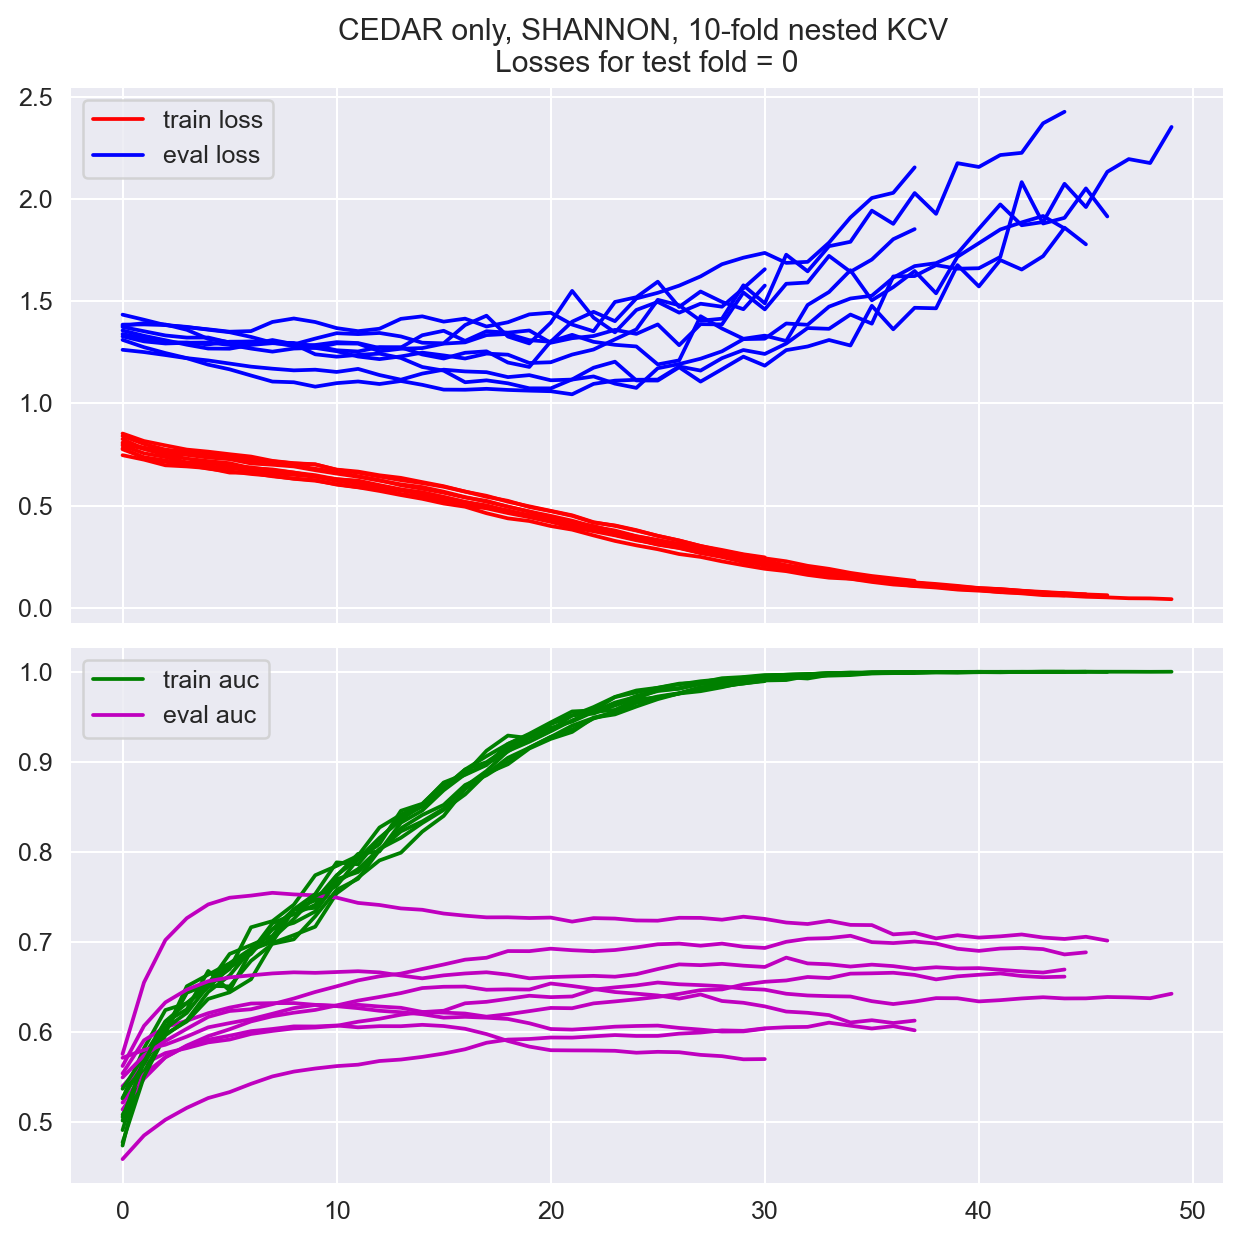

In [16]:
f,a = plt.subplots(2,1,figsize=(7,7), sharex=True)
for k,v in train_results_10_sh[0].items():
    a[0].plot(range(len(v['train']['losses'])), v['train']['losses'], label='train loss', color = 'r')
    a[0].plot(range(len(v['eval']['losses'])), v['eval']['losses'], label='eval loss', color = 'b')
h,l = a[0].get_legend_handles_labels()
a[0].legend(h[:2], l[:2], loc='upper left')
a[0].set_title('CEDAR only, SHANNON, 10-fold nested KCV \nLosses for test fold = 0')
a[0].set_xlabel(None)

for k,v in train_results_10_sh[0].items():
    a[1].plot(range(len(v['train']['auc'])), v['train']['auc'], label='train auc', color = 'g')
    a[1].plot(range(len(v['eval']['auc'])), v['eval']['auc'], label='eval auc', color = 'm')
h,l = a[1].get_legend_handles_labels()
a[1].legend(h[:2], l[:2], loc='upper left')

plt.tight_layout(h_pad=0.9, w_pad=0.9)
# a[1].set_title('CEDAR only, 5fold nested KCV \nLosses for test fold = 0')

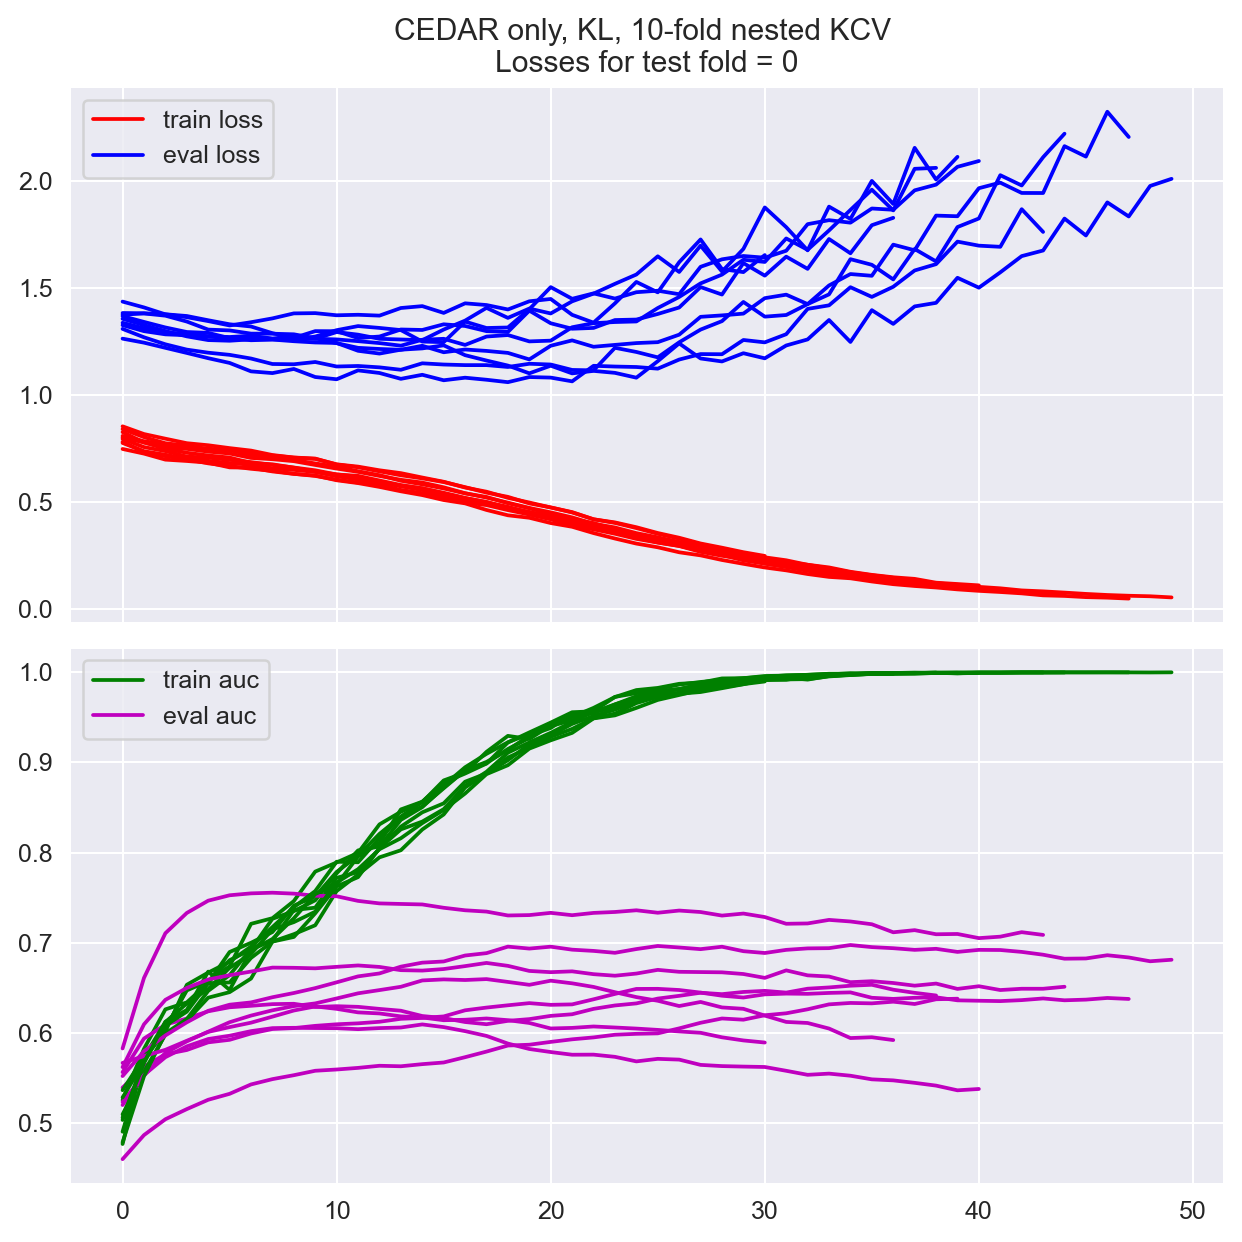

In [18]:
f,a = plt.subplots(2,1,figsize=(7,7), sharex=True)
for k,v in train_results_10_kl[0].items():
    a[0].plot(range(len(v['train']['losses'])), v['train']['losses'], label='train loss', color = 'r')
    a[0].plot(range(len(v['eval']['losses'])), v['eval']['losses'], label='eval loss', color = 'b')
h,l = a[0].get_legend_handles_labels()
a[0].legend(h[:2], l[:2], loc='upper left')
a[0].set_title('CEDAR only, KL, 10-fold nested KCV \nLosses for test fold = 0')
a[0].set_xlabel(None)

for k,v in train_results_10_kl[0].items():
    a[1].plot(range(len(v['train']['auc'])), v['train']['auc'], label='train auc', color = 'g')
    a[1].plot(range(len(v['eval']['auc'])), v['eval']['auc'], label='eval auc', color = 'm')
h,l = a[1].get_legend_handles_labels()
a[1].legend(h[:2], l[:2], loc='upper left')

plt.tight_layout(h_pad=0.9, w_pad=0.9)
# a[1].set_title('CEDAR only, 5fold nested KCV \nLosses for test fold = 0')

### test AUCs

Text(0.5, 1.0, '10 fold crossvalidation (CEDAR only)\nPerformance for average prediction on test set')

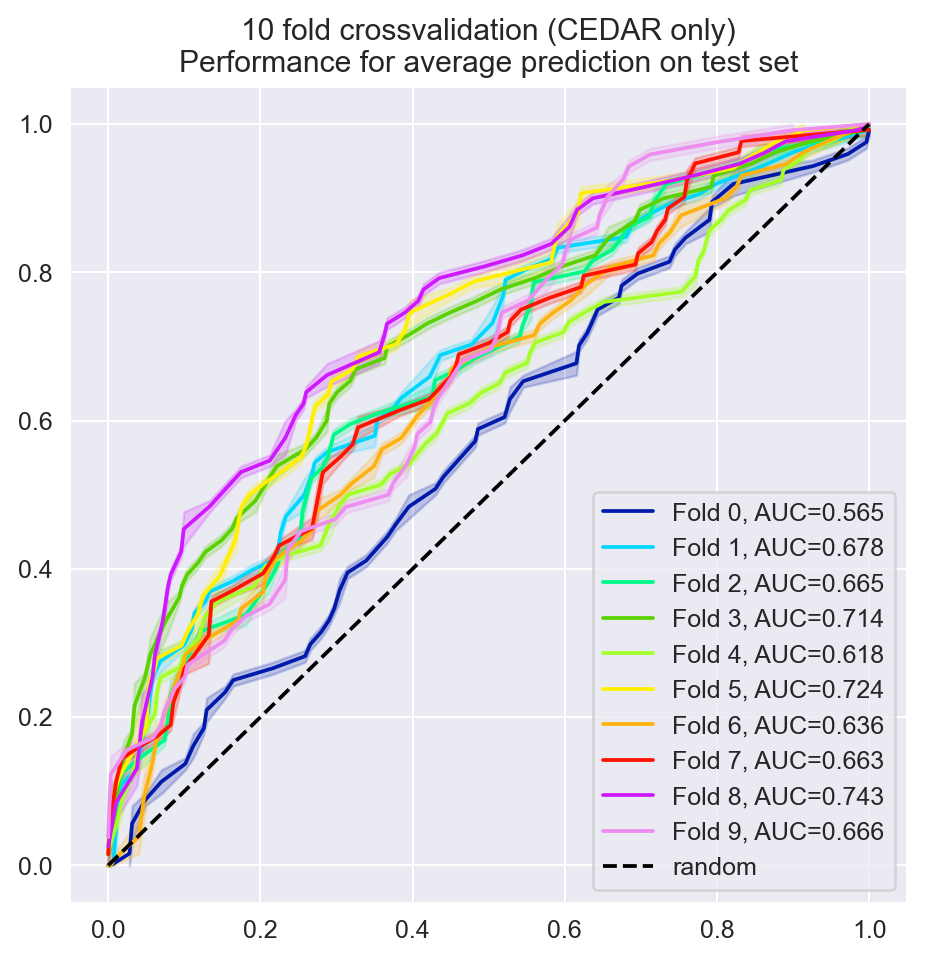

In [150]:
sns.set_palette('gist_ncar',n_colors=10)
f,a = plt.subplots(1,1, figsize= (6,6))
for k in test_results_10:
    fpr=test_results_10[k]['roc_curve'][0]
    tpr=test_results_10[k]['roc_curve'][1]
    auc=test_results_10[k]['auc']
    sns.lineplot(fpr, tpr, ax=a, label=f'Fold {k}, AUC={auc.round(3)}', n_boot=100)
sns.lineplot([0,1],[0,1], ls='--', color='k', label='random')
a.set_title('10 fold crossvalidation (CEDAR only)\nPerformance for average prediction on test set')

### Re-evaluating all 10 models on their test folds and concatenating to get average 

In [9]:
models_fold_10 

NameError: name 'models_fold_10' is not defined

## ADDING HP

In [155]:
mixed_subsampled_hp= pd.read_csv('../data/cedar_mixed_hp_sub75.csv')
mixed_dataset_5fold = pipeline_stratified_kfold('../../../kern_dist/out/cedar_mixed_hp_sub75.pep_0.9.pep', mixed_subsampled_hp, k=5, shuffle=True)
ics_kl = pkl_load('../output/ics_kl.pkl')
ics_shannon = pkl_load('../output/ics_shannon.pkl')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Set up hyperparams
n_epochs = 300
lr = 5e-4
batch_size = 256
# init objects
model = Net(n_filters=16, n_hidden=32, act_cnn=nn.SELU(), act_lin=nn.SELU())
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

models_fold_mixed5, train_results_mixed5, test_results_mixed5= nested_kcv_train(mixed_dataset_5fold, ics_shannon, model, criterion, optimizer, device, batch_size,
                                                                    n_epochs, early_stopping=True, patience=50, delta=1e-6, filename='model')

Using cuda
folds: Outer:	0	Inner:	1


  1%|▌                                                                                       | 2/300 [00:00<00:38,  7.80it/s]

Train Epoch: 0	Train Loss: 0.70720	Eval Loss:0.75919
	Train AUC, Accuracy:	(0.5094427287933216, 0.587933845795481)
	Eval AUC, Accuracy:	(0.5733962022068257, 0.9154334038054969)


 10%|████████▉                                                                              | 31/300 [00:02<00:24, 11.20it/s]

Train Epoch: 29	Train Loss: 0.18594	Eval Loss:0.45455
	Train AUC, Accuracy:	(0.9816670018763254, 0.9613324015839739)
	Eval AUC, Accuracy:	(0.6178983833718246, 0.8653981677237491)


 20%|█████████████████▋                                                                     | 61/300 [00:05<00:19, 12.47it/s]

Train Epoch: 59	Train Loss: 0.03104	Eval Loss:0.68520
	Train AUC, Accuracy:	(0.9986303078752206, 0.9979035639412998)
	Eval AUC, Accuracy:	(0.6350910957146524, 0.8414376321353065)


Early Stopping at epoch=78;current best valid loss:0.8105139613151551; previous avg losses: (0.6379829640291175,), previous losses std: 0.11279813719709066
folds: Outer:	0	Inner:	2


  1%|▉                                                                                       | 3/300 [00:00<00:27, 10.75it/s]

Train Epoch: 0	Train Loss: 0.72290	Eval Loss:0.77909
	Train AUC, Accuracy:	(0.517891052497818, 0.577751756440281)
	Eval AUC, Accuracy:	(0.514619284007039, 0.897364771151179)


 10%|████████▉                                                                              | 31/300 [00:02<00:23, 11.53it/s]

Train Epoch: 29	Train Loss: 0.18186	Eval Loss:0.53440
	Train AUC, Accuracy:	(0.979705803996972, 0.9662763466042155)
	Eval AUC, Accuracy:	(0.5728836708428545, 0.8231622746185853)


 20%|█████████████████▋                                                                     | 61/300 [00:05<00:20, 11.57it/s]

Train Epoch: 59	Train Loss: 0.02882	Eval Loss:0.85200
	Train AUC, Accuracy:	(0.9997254134299405, 0.9990632318501171)
	Eval AUC, Accuracy:	(0.5420219052872115, 0.8203883495145631)


Early Stopping at epoch=74;current best valid loss:0.9943223834037781; previous avg losses: (0.7534488602560393,), previous losses std: 0.1449932824764094
folds: Outer:	0	Inner:	3


  1%|▉                                                                                       | 3/300 [00:00<00:28, 10.57it/s]

Train Epoch: 0	Train Loss: 0.78336	Eval Loss:0.83185
	Train AUC, Accuracy:	(0.5048155017571261, 0.4592454587796926)
	Eval AUC, Accuracy:	(0.5157250358337314, 0.502820874471086)


 10%|████████▉                                                                              | 31/300 [00:02<00:23, 11.24it/s]

Train Epoch: 29	Train Loss: 0.20573	Eval Loss:0.53292
	Train AUC, Accuracy:	(0.9694982428738775, 0.9527247321844434)
	Eval AUC, Accuracy:	(0.5555482560917343, 0.8272214386459803)


 20%|█████████████████▋                                                                     | 61/300 [00:05<00:18, 12.84it/s]

Train Epoch: 59	Train Loss: 0.03334	Eval Loss:0.73425
	Train AUC, Accuracy:	(0.9999160484185865, 0.9972054028877504)
	Eval AUC, Accuracy:	(0.5846512183468705, 0.8279266572637518)


Early Stopping at epoch=77;current best valid loss:0.8355666995048523; previous avg losses: (0.6761989497408575,), previous losses std: 0.10759967656281545
folds: Outer:	0	Inner:	4


  1%|▌                                                                                       | 2/300 [00:00<00:27, 10.97it/s]

Train Epoch: 0	Train Loss: 0.78335	Eval Loss:0.79513
	Train AUC, Accuracy:	(0.4880998264936534, 0.5174106099555971)
	Eval AUC, Accuracy:	(0.4997648647670955, 0.8674110258199581)


 11%|█████████▎                                                                             | 32/300 [00:03<00:24, 10.97it/s]

Train Epoch: 29	Train Loss: 0.19271	Eval Loss:0.50116
	Train AUC, Accuracy:	(0.9793330192829529, 0.9619069876139285)
	Eval AUC, Accuracy:	(0.5815436929495604, 0.8248429867411026)


 21%|█████████████████▉                                                                     | 62/300 [00:05<00:19, 12.29it/s]

Train Epoch: 59	Train Loss: 0.03004	Eval Loss:0.80970
	Train AUC, Accuracy:	(0.999927327184694, 0.9983641037625614)
	Eval AUC, Accuracy:	(0.5823817390360662, 0.7969295184926727)


Early Stopping at epoch=82;current best valid loss:0.9264016509056091; previous avg losses: (0.7484794198250284,), previous losses std: 0.12612659541341611
folds: Outer:	1	Inner:	0


  1%|▌                                                                                       | 2/300 [00:00<00:30,  9.84it/s]

Train Epoch: 0	Train Loss: 0.71980	Eval Loss:0.74248
	Train AUC, Accuracy:	(0.5008426916232379, 0.5963195900302819)
	Eval AUC, Accuracy:	(0.47913561401933497, 0.9094101123595506)


 11%|█████████▎                                                                             | 32/300 [00:02<00:22, 11.93it/s]

Train Epoch: 29	Train Loss: 0.20261	Eval Loss:0.47598
	Train AUC, Accuracy:	(0.9683914264401497, 0.9576054041462847)
	Eval AUC, Accuracy:	(0.5490048187722606, 0.8672752808988764)


 21%|█████████████████▉                                                                     | 62/300 [00:05<00:19, 12.17it/s]

Train Epoch: 59	Train Loss: 0.03541	Eval Loss:0.78810
	Train AUC, Accuracy:	(0.9997810529317267, 0.9958071278825996)
	Eval AUC, Accuracy:	(0.5580078417287719, 0.8160112359550562)


Early Stopping at epoch=75;current best valid loss:0.9249047994613647; previous avg losses: (0.6932417144580764,), previous losses std: 0.13375402093381591
folds: Outer:	1	Inner:	2


  1%|▉                                                                                       | 3/300 [00:00<00:32,  9.17it/s]

Train Epoch: 0	Train Loss: 0.75777	Eval Loss:0.79588
	Train AUC, Accuracy:	(0.47839328942933235, 0.5225730994152047)
	Eval AUC, Accuracy:	(0.525937015732934, 0.8515950069348127)


 10%|████████▉                                                                              | 31/300 [00:02<00:23, 11.50it/s]

Train Epoch: 29	Train Loss: 0.18375	Eval Loss:0.49253
	Train AUC, Accuracy:	(0.9804577012085369, 0.9670175438596491)
	Eval AUC, Accuracy:	(0.5837260000525306, 0.8543689320388349)


 20%|█████████████████▋                                                                     | 61/300 [00:05<00:18, 12.88it/s]

Train Epoch: 59	Train Loss: 0.03052	Eval Loss:0.80293
	Train AUC, Accuracy:	(0.9998641045489004, 0.9983625730994152)
	Eval AUC, Accuracy:	(0.5754209019515142, 0.8231622746185853)


Early Stopping at epoch=75;current best valid loss:0.9158792614936828; previous avg losses: (0.7053914160144573,), previous losses std: 0.13568271200151483
folds: Outer:	1	Inner:	3


  1%|▌                                                                                       | 2/300 [00:00<00:25, 11.81it/s]

Train Epoch: 0	Train Loss: 0.83196	Eval Loss:0.86508
	Train AUC, Accuracy:	(0.5494010526798497, 0.4496394510351244)
	Eval AUC, Accuracy:	(0.5597885809842332, 0.14527503526093088)


 11%|█████████▎                                                                             | 32/300 [00:03<00:30,  8.65it/s]

Train Epoch: 29	Train Loss: 0.22471	Eval Loss:0.45572
	Train AUC, Accuracy:	(0.9578030021247216, 0.944870900209351)
	Eval AUC, Accuracy:	(0.5906593406593408, 0.8709449929478138)


 20%|█████████████████▋                                                                     | 61/300 [00:05<00:18, 12.63it/s]

Train Epoch: 59	Train Loss: 0.03855	Eval Loss:0.75340
	Train AUC, Accuracy:	(0.9997853623491167, 0.9965108164689462)
	Eval AUC, Accuracy:	(0.5608337314859054, 0.8293370944992948)


Early Stopping at epoch=78;current best valid loss:0.8837778985500335; previous avg losses: (0.6792729960412397,), previous losses std: 0.14629771985718906
folds: Outer:	1	Inner:	4


  1%|▉                                                                                       | 3/300 [00:00<00:25, 11.65it/s]

Train Epoch: 0	Train Loss: 0.76993	Eval Loss:0.81597
	Train AUC, Accuracy:	(0.5352366640668468, 0.5053688141923436)
	Eval AUC, Accuracy:	(0.536626834356272, 0.7487787857641311)


 10%|████████▉                                                                              | 31/300 [00:02<00:21, 12.70it/s]

Train Epoch: 29	Train Loss: 0.19160	Eval Loss:0.48363
	Train AUC, Accuracy:	(0.9790202150821737, 0.9596171802054155)
	Eval AUC, Accuracy:	(0.6119002544283801, 0.842986741102582)


 20%|█████████████████▋                                                                     | 61/300 [00:04<00:18, 13.15it/s]

Train Epoch: 59	Train Loss: 0.02956	Eval Loss:0.68092
	Train AUC, Accuracy:	(0.9997827837720424, 0.9978991596638656)
	Eval AUC, Accuracy:	(0.5931738433155274, 0.8450802512212142)


Early Stopping at epoch=78;current best valid loss:0.8176781058311462; previous avg losses: (0.6451903397939642,), previous losses std: 0.11266415724123593
folds: Outer:	2	Inner:	0


  1%|▌                                                                                       | 2/300 [00:00<00:25, 11.59it/s]

Train Epoch: 0	Train Loss: 0.81108	Eval Loss:0.84122
	Train AUC, Accuracy:	(0.5180954593737928, 0.4686182669789227)
	Eval AUC, Accuracy:	(0.5816407769896141, 0.34691011235955055)


 11%|█████████▎                                                                             | 32/300 [00:02<00:22, 12.04it/s]

Train Epoch: 29	Train Loss: 0.21548	Eval Loss:0.45730
	Train AUC, Accuracy:	(0.9702111046079444, 0.9489461358313818)
	Eval AUC, Accuracy:	(0.6016760946993506, 0.8462078651685393)


 21%|█████████████████▉                                                                     | 62/300 [00:05<00:18, 12.99it/s]

Train Epoch: 59	Train Loss: 0.03543	Eval Loss:0.65651
	Train AUC, Accuracy:	(0.9998637287493501, 0.9978922716627635)
	Eval AUC, Accuracy:	(0.6101104426685823, 0.8441011235955056)


Early Stopping at epoch=80;current best valid loss:0.7714023590087891; previous avg losses: (0.6226813209300138,), previous losses std: 0.10056262525238456
folds: Outer:	2	Inner:	1


  1%|▌                                                                                       | 2/300 [00:00<00:25, 11.82it/s]

Train Epoch: 0	Train Loss: 0.73090	Eval Loss:0.74183
	Train AUC, Accuracy:	(0.4650772006069997, 0.5749707602339181)
	Eval AUC, Accuracy:	(0.5008724659994868, 0.9154334038054969)


 11%|█████████▎                                                                             | 32/300 [00:02<00:20, 12.86it/s]

Train Epoch: 29	Train Loss: 0.19429	Eval Loss:0.43699
	Train AUC, Accuracy:	(0.9780528846474112, 0.9588304093567251)
	Eval AUC, Accuracy:	(0.6580254041570439, 0.8653981677237491)


 21%|█████████████████▉                                                                     | 62/300 [00:05<00:19, 12.07it/s]

Train Epoch: 59	Train Loss: 0.03110	Eval Loss:0.69584
	Train AUC, Accuracy:	(0.9998327953028138, 0.9969590643274854)
	Eval AUC, Accuracy:	(0.640620990505517, 0.8449612403100775)


Early Stopping at epoch=75;current best valid loss:0.798373955488205; previous avg losses: (0.6202576404931595,), previous losses std: 0.11539079832597621
folds: Outer:	2	Inner:	3


  1%|▉                                                                                       | 3/300 [00:00<00:26, 11.27it/s]

Train Epoch: 0	Train Loss: 0.71535	Eval Loss:0.77788
	Train AUC, Accuracy:	(0.5701950354609928, 0.5898035547240411)
	Eval AUC, Accuracy:	(0.5469033683707596, 0.8984485190409027)


 10%|████████▉                                                                              | 31/300 [00:02<00:21, 12.72it/s]

Train Epoch: 29	Train Loss: 0.18065	Eval Loss:0.51427
	Train AUC, Accuracy:	(0.9823349699945445, 0.965154349859682)
	Eval AUC, Accuracy:	(0.5445293836598184, 0.8370944992947814)


 20%|█████████████████▋                                                                     | 61/300 [00:04<00:18, 13.18it/s]

Train Epoch: 59	Train Loss: 0.03051	Eval Loss:0.77115
	Train AUC, Accuracy:	(0.9998977086743044, 0.9978952291861553)
	Eval AUC, Accuracy:	(0.5459209268991878, 0.8314527503526093)


Early Stopping at epoch=76;current best valid loss:0.9192545056343079; previous avg losses: (0.7057857652099765,), previous losses std: 0.12549471316518243
folds: Outer:	2	Inner:	4


  1%|▉                                                                                       | 3/300 [00:00<00:25, 11.59it/s]

Train Epoch: 0	Train Loss: 0.78522	Eval Loss:0.84187
	Train AUC, Accuracy:	(0.5501060982356836, 0.4987092231870453)
	Eval AUC, Accuracy:	(0.5463065681108391, 0.377529658060014)


 10%|████████▉                                                                              | 31/300 [00:02<00:20, 13.17it/s]

Train Epoch: 29	Train Loss: 0.18206	Eval Loss:0.48788
	Train AUC, Accuracy:	(0.9831602185311002, 0.9685519831025581)
	Eval AUC, Accuracy:	(0.6474719947908503, 0.8199581297976274)


 20%|█████████████████▋                                                                     | 61/300 [00:04<00:18, 13.16it/s]

Train Epoch: 59	Train Loss: 0.02726	Eval Loss:0.69141
	Train AUC, Accuracy:	(0.9999435864602066, 0.9981225064538841)
	Eval AUC, Accuracy:	(0.6272624229781385, 0.8241451500348919)


Early Stopping at epoch=74;current best valid loss:0.8258300304412842; previous avg losses: (0.6098896530209755,), previous losses std: 0.10896499712900676
folds: Outer:	3	Inner:	0


  1%|▌                                                                                       | 2/300 [00:00<00:25, 11.72it/s]

Train Epoch: 0	Train Loss: 0.82381	Eval Loss:0.85632
	Train AUC, Accuracy:	(0.4898883899518417, 0.45971122496506756)
	Eval AUC, Accuracy:	(0.5290682709287361, 0.22612359550561797)


 11%|█████████▎                                                                             | 32/300 [00:02<00:21, 12.47it/s]

Train Epoch: 29	Train Loss: 0.20932	Eval Loss:0.48719
	Train AUC, Accuracy:	(0.9737426786411558, 0.9548206800186306)
	Eval AUC, Accuracy:	(0.5922839783304898, 0.8426966292134831)


 21%|█████████████████▉                                                                     | 62/300 [00:04<00:17, 13.24it/s]

Train Epoch: 59	Train Loss: 0.03603	Eval Loss:0.74003
	Train AUC, Accuracy:	(0.9998971755824547, 0.9962738705170004)
	Eval AUC, Accuracy:	(0.5956900422016701, 0.8349719101123596)


Early Stopping at epoch=75;current best valid loss:0.8882245540618896; previous avg losses: (0.6565970864831185,), previous losses std: 0.12877775449699858
folds: Outer:	3	Inner:	1


  1%|▌                                                                                       | 2/300 [00:00<00:27, 10.82it/s]

Train Epoch: 0	Train Loss: 0.78208	Eval Loss:0.81328
	Train AUC, Accuracy:	(0.5186772970686994, 0.5019772040009305)
	Eval AUC, Accuracy:	(0.566871952784193, 0.7625088090204369)


 11%|█████████▎                                                                             | 32/300 [00:02<00:23, 11.20it/s]

Train Epoch: 29	Train Loss: 0.20457	Eval Loss:0.46901
	Train AUC, Accuracy:	(0.9753981942413419, 0.9525471039776692)
	Eval AUC, Accuracy:	(0.6192519887092636, 0.8590556730091614)


 21%|█████████████████▉                                                                     | 62/300 [00:05<00:18, 12.76it/s]

Train Epoch: 59	Train Loss: 0.03542	Eval Loss:0.71672
	Train AUC, Accuracy:	(0.9993630930240853, 0.9972086531751571)
	Eval AUC, Accuracy:	(0.5881960482422376, 0.8590556730091614)


Early Stopping at epoch=79;current best valid loss:0.8499703764915466; previous avg losses: (0.6728195536501553,), previous losses std: 0.12356276117519202
folds: Outer:	3	Inner:	2


  1%|▌                                                                                       | 2/300 [00:00<00:31,  9.40it/s]

Train Epoch: 0	Train Loss: 0.83524	Eval Loss:0.90936
	Train AUC, Accuracy:	(0.5306533006001091, 0.4324134705332086)
	Eval AUC, Accuracy:	(0.5084232920967615, 0.10194174757281553)


 11%|█████████▎                                                                             | 32/300 [00:02<00:21, 12.60it/s]

Train Epoch: 29	Train Loss: 0.20988	Eval Loss:0.53488
	Train AUC, Accuracy:	(0.9678082378614294, 0.9553320860617399)
	Eval AUC, Accuracy:	(0.5983820555249126, 0.8183079056865464)


 21%|█████████████████▉                                                                     | 62/300 [00:05<00:20, 11.46it/s]

Train Epoch: 59	Train Loss: 0.03472	Eval Loss:0.76095
	Train AUC, Accuracy:	(0.9998867975995636, 0.9981290926099158)
	Eval AUC, Accuracy:	(0.5776324429385653, 0.8224687933425797)


Early Stopping at epoch=74;current best valid loss:0.8663857102394104; previous avg losses: (0.6635934955003311,), previous losses std: 0.1192321905586043
folds: Outer:	3	Inner:	4


  0%|▎                                                                                       | 1/300 [00:00<00:32,  9.17it/s]

Train Epoch: 0	Train Loss: 0.71847	Eval Loss:0.74727
	Train AUC, Accuracy:	(0.5103334709917379, 0.5806301050175029)
	Eval AUC, Accuracy:	(0.5450133243298647, 0.9113747383112352)


 10%|████████▉                                                                              | 31/300 [00:02<00:22, 11.71it/s]

Train Epoch: 29	Train Loss: 0.19524	Eval Loss:0.45630
	Train AUC, Accuracy:	(0.9755961517982603, 0.9565927654609101)
	Eval AUC, Accuracy:	(0.6052200021704791, 0.8548499651081647)


 20%|█████████████████▋                                                                     | 61/300 [00:05<00:18, 12.97it/s]

Train Epoch: 59	Train Loss: 0.03158	Eval Loss:0.71154
	Train AUC, Accuracy:	(0.9989363940251057, 0.9981330221703617)
	Eval AUC, Accuracy:	(0.5717584497956132, 0.8367062107466853)


Early Stopping at epoch=76;current best valid loss:0.8034269452095032; previous avg losses: (0.6459310324824586,), previous losses std: 0.11409943473847671
folds: Outer:	4	Inner:	0


  1%|▌                                                                                       | 2/300 [00:00<00:26, 11.11it/s]

Train Epoch: 0	Train Loss: 0.82221	Eval Loss:0.87752
	Train AUC, Accuracy:	(0.49367551847511665, 0.4484692685206824)
	Eval AUC, Accuracy:	(0.5298015623597019, 0.10463483146067416)


 11%|█████████▎                                                                             | 32/300 [00:03<00:24, 10.84it/s]

Train Epoch: 29	Train Loss: 0.20553	Eval Loss:0.47078
	Train AUC, Accuracy:	(0.9747585251052133, 0.9513905118018229)
	Eval AUC, Accuracy:	(0.5882254347370626, 0.8455056179775281)


 21%|█████████████████▉                                                                     | 62/300 [00:05<00:17, 13.31it/s]

Train Epoch: 59	Train Loss: 0.03364	Eval Loss:0.76315
	Train AUC, Accuracy:	(0.9998533566405434, 0.9976630053750877)
	Eval AUC, Accuracy:	(0.5728652240280148, 0.8139044943820225)


Early Stopping at epoch=76;current best valid loss:0.9137025475502014; previous avg losses: (0.6899375379085539,), previous losses std: 0.12353602274331298
folds: Outer:	4	Inner:	1


  1%|▌                                                                                       | 2/300 [00:00<00:25, 11.82it/s]

Train Epoch: 0	Train Loss: 0.71645	Eval Loss:0.76526
	Train AUC, Accuracy:	(0.5095460815970855, 0.5763305322128851)
	Eval AUC, Accuracy:	(0.5151206055940467, 0.9154334038054969)


 11%|█████████▎                                                                             | 32/300 [00:02<00:20, 12.78it/s]

Train Epoch: 29	Train Loss: 0.17903	Eval Loss:0.48195
	Train AUC, Accuracy:	(0.9847173775522907, 0.9631185807656396)
	Eval AUC, Accuracy:	(0.6003015139851168, 0.8618745595489782)


 21%|█████████████████▉                                                                     | 62/300 [00:04<00:18, 13.10it/s]

Train Epoch: 59	Train Loss: 0.02723	Eval Loss:0.71483
	Train AUC, Accuracy:	(0.9999472837809342, 0.9983660130718954)
	Eval AUC, Accuracy:	(0.5936874518860662, 0.8442565186751233)


Early Stopping at epoch=75;current best valid loss:0.8425952374935151; previous avg losses: (0.6418387318752249,), previous losses std: 0.116071495053288
folds: Outer:	4	Inner:	2


  1%|▉                                                                                       | 3/300 [00:00<00:24, 12.19it/s]

Train Epoch: 0	Train Loss: 0.75498	Eval Loss:0.81267
	Train AUC, Accuracy:	(0.5433398718664998, 0.5221778925134944)
	Eval AUC, Accuracy:	(0.4920731226853675, 0.7891816920943134)


 10%|████████▉                                                                              | 31/300 [00:02<00:20, 12.93it/s]

Train Epoch: 29	Train Loss: 0.19727	Eval Loss:0.49685
	Train AUC, Accuracy:	(0.9732389120207058, 0.9511851678009857)
	Eval AUC, Accuracy:	(0.5923357760092454, 0.8294036061026352)


 20%|█████████████████▋                                                                     | 61/300 [00:04<00:18, 12.91it/s]

Train Epoch: 59	Train Loss: 0.03257	Eval Loss:0.75271
	Train AUC, Accuracy:	(0.9998525091790946, 0.9971837596808261)
	Eval AUC, Accuracy:	(0.5633441021196124, 0.840499306518724)


Early Stopping at epoch=72;current best valid loss:0.8713166177272796; previous avg losses: (0.6578452180842964,), previous losses std: 0.120833837023737
folds: Outer:	4	Inner:	3


  1%|▉                                                                                       | 3/300 [00:00<00:25, 11.43it/s]

Train Epoch: 0	Train Loss: 0.81196	Eval Loss:0.84728
	Train AUC, Accuracy:	(0.5285310030103036, 0.47584597432905484)
	Eval AUC, Accuracy:	(0.5268394648829431, 0.2954866008462623)


 10%|████████▉                                                                              | 31/300 [00:02<00:21, 12.59it/s]

Train Epoch: 29	Train Loss: 0.20957	Eval Loss:0.50751
	Train AUC, Accuracy:	(0.9685015493063835, 0.9516919486581097)
	Eval AUC, Accuracy:	(0.5448041089345437, 0.8427362482369535)


 20%|█████████████████▋                                                                     | 61/300 [00:05<00:24,  9.76it/s]

Train Epoch: 59	Train Loss: 0.03402	Eval Loss:0.75921
	Train AUC, Accuracy:	(0.9992026201848778, 0.9976662777129521)
	Eval AUC, Accuracy:	(0.5670150501672242, 0.8272214386459803)


Early Stopping at epoch=78;current best valid loss:0.9043335914611816; previous avg losses: (0.7062122325507962,), previous losses std: 0.13010571691528985


Text(0.5, 1.0, '5 fold crossvalidation (CEDAR+HP)\nPerformance for average prediction on test set')

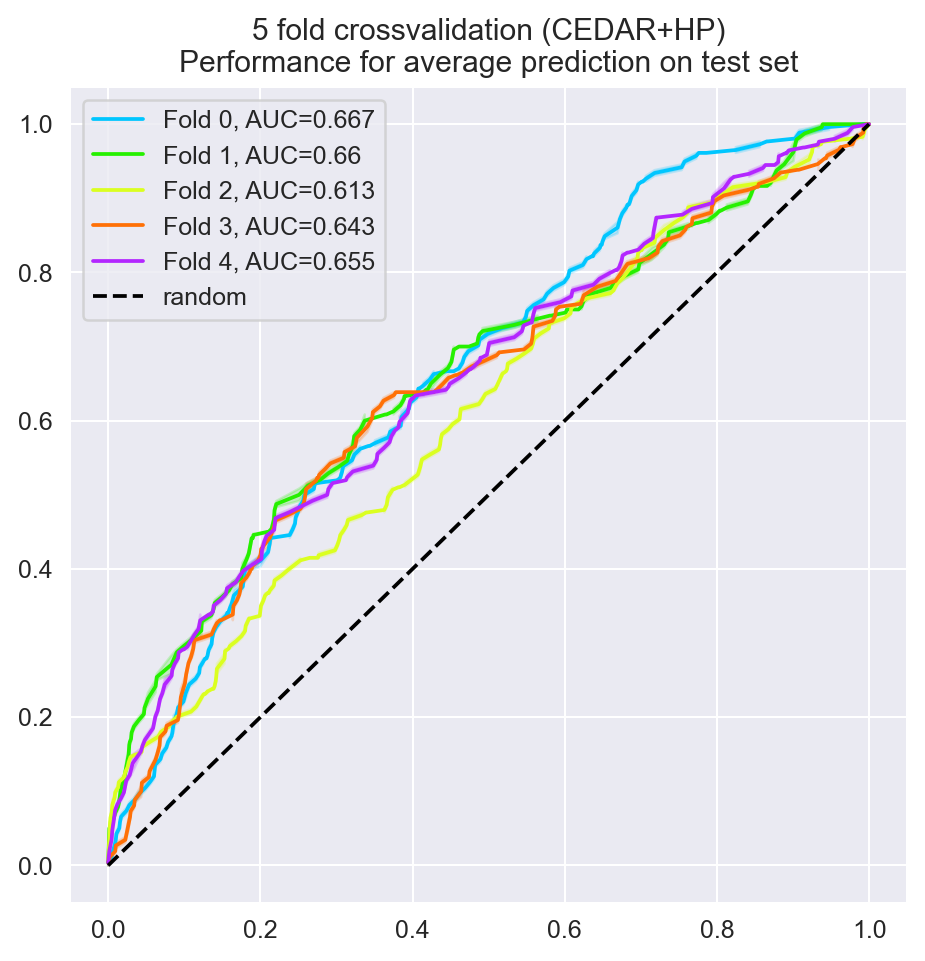

In [160]:
sns.set_palette('gist_ncar',n_colors=5)
f,a = plt.subplots(1,1, figsize= (6,6))
for k in test_results_mixed5:
    fpr=test_results_mixed5[k]['roc_curve'][0]
    tpr=test_results_mixed5[k]['roc_curve'][1]
    auc=test_results_mixed5[k]['auc']
    sns.lineplot(fpr, tpr, ax=a, label=f'Fold {k}, AUC={auc.round(3)}', n_boot=100)
sns.lineplot([0,1],[0,1], ls='--', color='k', label='random')
a.set_title('5 fold crossvalidation (CEDAR+HP)\nPerformance for average prediction on test set')

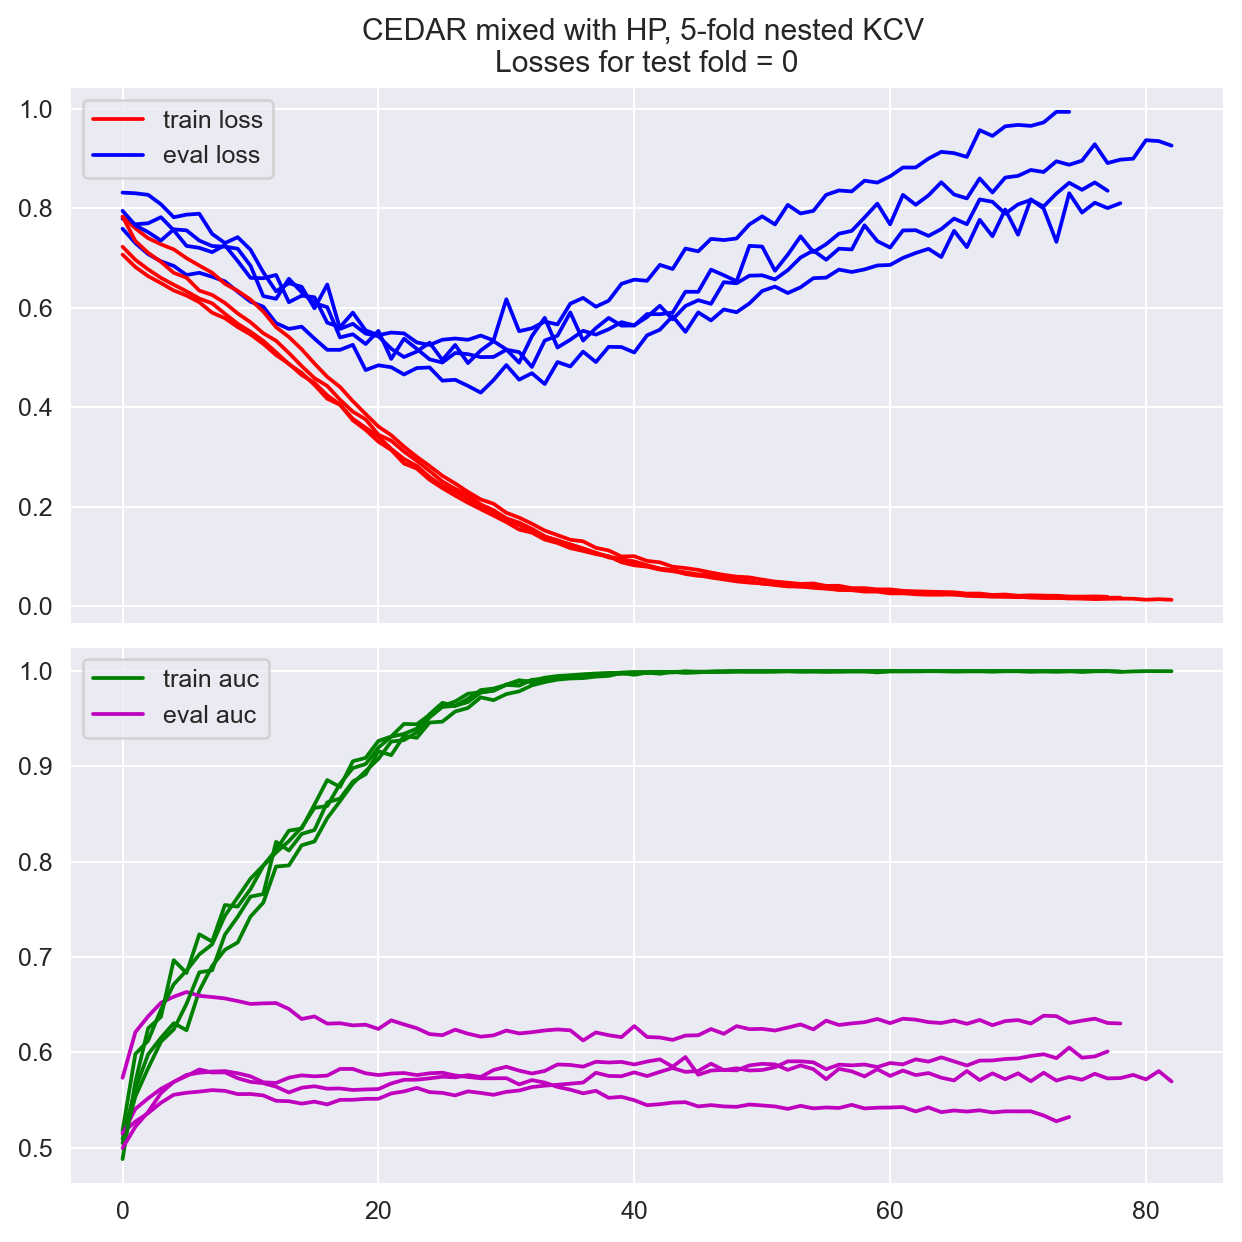

In [198]:
f,a = plt.subplots(2,1,figsize=(7,7), sharex=True)
for k,v in train_results_mixed5[0].items():
    a[0].plot(range(len(v['train']['losses'])), v['train']['losses'], label='train loss', color = 'r')
    a[0].plot(range(len(v['eval']['losses'])), v['eval']['losses'], label='eval loss', color = 'b')
h,l = a[0].get_legend_handles_labels()
a[0].legend(h[:2], l[:2], loc='upper left')
a[0].set_title('CEDAR mixed with HP, 5-fold nested KCV \nLosses for test fold = 0')
a[0].set_xlabel(None)

for k,v in train_results_mixed5[0].items():
    a[1].plot(range(len(v['train']['auc'])), v['train']['auc'], label='train auc', color = 'g')
    a[1].plot(range(len(v['eval']['auc'])), v['eval']['auc'], label='eval auc', color = 'm')
h,l = a[1].get_legend_handles_labels()
a[1].legend(h[:2], l[:2], loc='upper left')

plt.tight_layout(h_pad=0.9, w_pad=0.9)
